##### Copyright 2018 The TensorFlow Authors.


In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

&lt;style&gt; td {   text-align: center; }  th {   text-align: center; } &lt;/style&gt;

# 눈에 띄는 이미지 캡션

<table class="tfo-notebook-buttons" align="left">
  <td><a target="_blank" href="https://www.tensorflow.org/tutorials/text/image_captioning"><img src="https://www.tensorflow.org/images/tf_logo_32px.png">TensorFlow.org에서보기</a></td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ko/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png">Google Colab에서 실행하기</a> </td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ko/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">GitHub에서 소스 보기</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ko/tutorials/text/image_captioning.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">노트북 다운로드</a></td>
</table>

아래 예와 같은 이미지가 주어졌을 때의 목표는 "파도를 타는 서퍼"와 같은 캡션을 생성하는 것입니다.

<table style="text-align: center;">
<tr>
  <td><img src="https://tensorflow.org/images/imcap_prediction.png" data-md-type="image" alt="예측"></td>
</tr>
<tr>
  <th>서핑하는 남자, 출처: <a href="https://commons.wikimedia.org/wiki/Surfing#/media/File:Surfing_in_Hawaii.jpg">wikimedia</a>
</th>
</tr>
</table>

여기에서 사용된 모델 아키텍처는 [Show, Attend and Tell: Neural Image Caption Generation with Visual Attention](https://arxiv.org/abs/1502.03044)의 영감을 받았지만 2단 레이어 트랜스포머 디코더를 사용하도록 업데이트되었습니다. 이 튜토리얼을 최대한 활용하려면 [텍스트 생성](https://www.tensorflow.org/text/tutorials/text_generation),  [seq2seq 모델 및 어텐션](https://www.tensorflow.org/text/tutorials/nmt_with_attention) 또는 [트랜스포머](https://www.tensorflow.org/text/tutorials/transformer)를 약간 경험해 보셔야 합니다.

이 튜토리얼에서 빌드된 모델 아키텍처는 아래와 같습니다. 특성은 이미지에서 추출되어 트랜스포머 디코더의 크로스 어텐션 레이어로 전달되었습니다.

<table>
<tr>
  <th>모델 아키텍처</th>
</tr>
<tr>
  <td>    <img width="400" src="https://tensorflow.org/images/tutorials/transformer/ImageCaptioning.png">
</td>
</tr>
</table>

트랜스포머 디코더는 주로 어텐션 레이어에서 빌드됩니다. 이는 셀프 어텐션을 사용하여 생성되는 시퀀스를 처리하고 크로스 어텐션을 사용하여 이미지를 처리합니다.

크로스 어텐션 레이어의 어텐션 가중치를 검사하면 모델이 단어를 생성할 때 이미지의 어떤 부분을 모델이 보고 있는지 알 수 있습니다.

![예측](https://tensorflow.org/images/surf.jpg)

이 노트북은 엔드 투 엔드 예제입니다. 노트북을 실행하면 노트북은 데이터세트를 다운로드하며 이미지 특성을 추출하고 캐싱하여 디코더 모델을 훈련합니다. 그런 다음 모델을 사용하여 새로운 이미지에 캡션을 생성합니다.

## 설치

In [2]:
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [3]:
!pip uninstall -y tensorflow estimator keras

Found existing installation: tensorflow 2.11.0


Uninstalling tensorflow-2.11.0:


  Successfully uninstalled tensorflow-2.11.0


Found existing installation: keras 2.11.0


Uninstalling keras-2.11.0:
  Successfully uninstalled keras-2.11.0


In [4]:
!pip install -U tensorflow_text tensorflow tensorflow_datasets

  Using cached tensorflow-2.11.0-cp39-cp39-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (588.3 MB)


  Using cached keras-2.11.0-py2.py3-none-any.whl (1.7 MB)


In [5]:
!pip install einops

이 튜토리얼은 주로 데이터세트를 로딩하기 위해 가져오기를 많이 사용합니다.

In [6]:
#@title
import concurrent.futures
import collections
import dataclasses
import hashlib
import itertools
import json
import math
import os
import pathlib
import random
import re
import string
import time
import urllib.request

import einops
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image
import requests
import tqdm

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import tensorflow_datasets as tfds

2022-12-14 21:23:54.920413: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:23:54.920526: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2022-12-14 21:23:54.920537: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed properly.


## [선택 사항] 데이터 처리

이 섹션은 캡션 데이터세트를 다운로드하고 훈련을 위해 이를 준비합니다. 입력 텍스트를 토큰화하고 사전 훈련된 특정 추출 모델을 통해 모든 이미지를 실행한 결과를 캐싱합니다. 이는 이 섹션의 모든 것을 이해하는 데 중요하지는 않습니다.

 <section class="expandable tfo-display-only-on-site">
 <button type="button" class="button-red button expand-control">토글 섹션</button>
</section>


### 데이터세트 선택

이 튜토리얼은 데이터세트를 선택할 수 있도록 설정되었습니다. [Flickr8k](https://www.ijcai.org/Proceedings/15/Papers/593.pdf) 또는 [Conceptual Captions](https://ai.google.com/research/ConceptualCaptions/) 데이터세트의 작은 슬라이스 중 하나입니다. 이 두 가지는 처음부터 다운로드되고 변환되었지만 [TensorFlow Datasets](https://www.tensorflow.org/datasets)([Coco Captions](https://www.tensorflow.org/datasets/catalog/coco_captions) 및 전체 [Conceptual Captions](https://www.tensorflow.org/datasets/community_catalog/huggingface/conceptual_captions))에서 사용할 수 있는 캡션 데이터세트를 사용하기 위해 튜토리얼을 변환하는 것은 어렵지 않습니다.


#### Flickr8k

In [7]:
def flickr8k(path='flickr8k'):
  path = pathlib.Path(path)

  if len(list(path.rglob('*'))) < 16197:
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_Dataset.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    tf.keras.utils.get_file(
        origin='https://github.com/jbrownlee/Datasets/releases/download/Flickr8k/Flickr8k_text.zip',
        cache_dir='.',
        cache_subdir=path,
        extract=True)
    
  captions = (path/"Flickr8k.token.txt").read_text().splitlines()
  captions = (line.split('\t') for line in captions)
  captions = ((fname.split('#')[0], caption) for (fname, caption) in captions)

  cap_dict = collections.defaultdict(list)
  for fname, cap in captions:
    cap_dict[fname].append(cap)

  train_files = (path/'Flickr_8k.trainImages.txt').read_text().splitlines()
  train_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in train_files]

  test_files = (path/'Flickr_8k.testImages.txt').read_text().splitlines()
  test_captions = [(str(path/'Flicker8k_Dataset'/fname), cap_dict[fname]) for fname in test_files]

  train_ds = tf.data.experimental.from_list(train_captions)
  test_ds = tf.data.experimental.from_list(test_captions)

  return train_ds, test_ds

#### Conceptual Captions

In [8]:
def conceptual_captions(*, data_dir="conceptual_captions", num_train, num_val):
  def iter_index(index_path):
    with open(index_path) as f:
      for line in f:
        caption, url = line.strip().split('\t')
        yield caption, url

  def download_image_urls(data_dir, urls):
    ex = concurrent.futures.ThreadPoolExecutor(max_workers=100)
    def save_image(url):
      hash = hashlib.sha1(url.encode())
      # Name the files after the hash of the URL.
      file_path = data_dir/f'{hash.hexdigest()}.jpeg'
      if file_path.exists():
        # Only download each file once.
        return file_path

      try:
        result = requests.get(url, timeout=5)
      except Exception:
        file_path = None
      else:
        file_path.write_bytes(result.content)
      return file_path
    
    result = []
    out_paths = ex.map(save_image, urls)
    for file_path in tqdm.tqdm(out_paths, total=len(urls)):
      result.append(file_path)

    return result

  def ds_from_index_file(index_path, data_dir, count):
    data_dir.mkdir(exist_ok=True)
    index = list(itertools.islice(iter_index(index_path), count))
    captions = [caption for caption, url in index]
    urls = [url for caption, url in index]

    paths = download_image_urls(data_dir, urls)

    new_captions = []
    new_paths = []
    for cap, path in zip(captions, paths):
      if path is None:
        # Download failed, so skip this pair.
        continue
      new_captions.append(cap)
      new_paths.append(path)
    
    new_paths = [str(p) for p in new_paths]

    ds = tf.data.Dataset.from_tensor_slices((new_paths, new_captions))
    ds = ds.map(lambda path,cap: (path, cap[tf.newaxis])) # 1 caption per image
    return ds

  data_dir = pathlib.Path(data_dir)
  train_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Train/GCC-training.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  val_index_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/gcc-data/Validation/GCC-1.1.0-Validation.tsv',
    cache_subdir=data_dir,
    cache_dir='.')
  
  train_raw = ds_from_index_file(train_index_path, data_dir=data_dir/'train', count=num_train)
  test_raw = ds_from_index_file(val_index_path, data_dir=data_dir/'val', count=num_val)

  return train_raw, test_raw

#### 데이터세트 다운로드

Flickr8k는 이미지당 5개의 캡션과 더욱 소규모의 다운로드를 위한 더 많은 데이터를 포함하고 있어 좋은 선택입니다.

In [9]:
choose = 'flickr8k'

if choose == 'flickr8k':
  train_raw, test_raw = flickr8k()
else:
  train_raw, test_raw = conceptual_captions(num_train=10000, num_val=5000)

      8192/1115419746 [..............................] - ETA: 0s

     81920/1115419746 [..............................] - ETA: 14:45

    278528/1115419746 [..............................] - ETA: 8:49 

    655360/1115419746 [..............................] - ETA: 5:10

   1310720/1115419746 [..............................] - ETA: 3:26

   3145728/1115419746 [..............................] - ETA: 1:50

   5660672/1115419746 [..............................] - ETA: 1:12

   8396800/1115419746 [..............................] - ETA: 56s 

  12591104/1115419746 [..............................] - ETA: 42s

  16785408/1115419746 [..............................] - ETA: 35s

  22339584/1115419746 [..............................] - ETA: 28s

  28041216/1115419746 [..............................] - ETA: 24s

  31432704/1115419746 [..............................] - ETA: 23s

  37756928/1115419746 [>.............................] - ETA: 22s

  41951232/1115419746 [>.............................] - ETA: 22s

  46145536/1115419746 [>.............................] - ETA: 21s

  53903360/1115419746 [>.............................] - ETA: 19s

  58728448/1115419746 [>.............................] - ETA: 18s

  64774144/1115419746 [>.............................] - ETA: 17s

  69935104/1115419746 [>.............................] - ETA: 17s

  74760192/1115419746 [=>............................] - ETA: 16s

  79699968/1115419746 [=>............................] - ETA: 16s

  86827008/1115419746 [=>............................] - ETA: 15s

  88817664/1115419746 [=>............................] - ETA: 15s

  94691328/1115419746 [=>............................] - ETA: 15s

  98050048/1115419746 [=>............................] - ETA: 15s

 104865792/1115419746 [=>............................] - ETA: 15s

 113205248/1115419746 [==>...........................] - ETA: 14s

 113254400/1115419746 [==>...........................] - ETA: 14s

 119496704/1115419746 [==>...........................] - ETA: 14s

 121970688/1115419746 [==>...........................] - ETA: 14s

 126984192/1115419746 [==>...........................] - ETA: 14s

 130031616/1115419746 [==>...........................] - ETA: 14s

 138420224/1115419746 [==>...........................] - ETA: 13s

 146628608/1115419746 [==>...........................] - ETA: 13s

 151003136/1115419746 [===>..........................] - ETA: 13s

 155688960/1115419746 [===>..........................] - ETA: 13s

 159391744/1115419746 [===>..........................] - ETA: 13s

 163586048/1115419746 [===>..........................] - ETA: 13s

 165797888/1115419746 [===>..........................] - ETA: 13s

 168337408/1115419746 [===>..........................] - ETA: 13s

 172810240/1115419746 [===>..........................] - ETA: 13s

 180461568/1115419746 [===>..........................] - ETA: 13s

 190685184/1115419746 [====>.........................] - ETA: 12s

 196583424/1115419746 [====>.........................] - ETA: 12s

 201334784/1115419746 [====>.........................] - ETA: 12s

 205529088/1115419746 [====>.........................] - ETA: 12s

 210206720/1115419746 [====>.........................] - ETA: 12s

 214401024/1115419746 [====>.........................] - ETA: 11s

 221683712/1115419746 [====>.........................] - ETA: 11s

 226500608/1115419746 [=====>........................] - ETA: 11s

 232382464/1115419746 [=====>........................] - ETA: 11s

 235773952/1115419746 [=====>........................] - ETA: 11s

 241655808/1115419746 [=====>........................] - ETA: 11s

 245669888/1115419746 [=====>........................] - ETA: 11s

 249987072/1115419746 [=====>........................] - ETA: 11s

 253517824/1115419746 [=====>........................] - ETA: 11s

 260055040/1115419746 [=====>........................] - ETA: 10s

 264249344/1115419746 [======>.......................] - ETA: 10s

 271425536/1115419746 [======>.......................] - ETA: 10s

 273342464/1115419746 [======>.......................] - ETA: 10s

 278962176/1115419746 [======>.......................] - ETA: 10s

 281042944/1115419746 [======>.......................] - ETA: 10s

 285220864/1115419746 [======>.......................] - ETA: 10s

 289398784/1115419746 [======>.......................] - ETA: 10s

 291184640/1115419746 [======>.......................] - ETA: 10s

 293609472/1115419746 [======>.......................] - ETA: 10s

 297803776/1115419746 [=======>......................] - ETA: 10s

 301998080/1115419746 [=======>......................] - ETA: 10s

 306192384/1115419746 [=======>......................] - ETA: 10s

 310386688/1115419746 [=======>......................] - ETA: 10s

 314580992/1115419746 [=======>......................] - ETA: 10s

 318775296/1115419746 [=======>......................] - ETA: 10s

 322969600/1115419746 [=======>......................] - ETA: 10s

 327163904/1115419746 [=======>......................] - ETA: 10s

 331358208/1115419746 [=======>......................] - ETA: 10s

 335552512/1115419746 [========>.....................] - ETA: 10s

 339746816/1115419746 [========>.....................] - ETA: 10s

 343941120/1115419746 [========>.....................] - ETA: 10s

 348135424/1115419746 [========>.....................] - ETA: 10s

 352329728/1115419746 [========>.....................] - ETA: 10s

 356524032/1115419746 [========>.....................] - ETA: 10s

 358998016/1115419746 [========>.....................] - ETA: 10s

 364912640/1115419746 [========>.....................] - ETA: 10s

 369106944/1115419746 [========>.....................] - ETA: 10s

 373301248/1115419746 [=========>....................] - ETA: 10s

 377495552/1115419746 [=========>....................] - ETA: 9s 

 381689856/1115419746 [=========>....................] - ETA: 9s

 385884160/1115419746 [=========>....................] - ETA: 9s

 390078464/1115419746 [=========>....................] - ETA: 9s

 394272768/1115419746 [=========>....................] - ETA: 9s

 398467072/1115419746 [=========>....................] - ETA: 9s

 402661376/1115419746 [=========>....................] - ETA: 9s

 406855680/1115419746 [=========>....................] - ETA: 9s

 411049984/1115419746 [==========>...................] - ETA: 9s

 415244288/1115419746 [==========>...................] - ETA: 9s

 419438592/1115419746 [==========>...................] - ETA: 9s

 423632896/1115419746 [==========>...................] - ETA: 9s

 427827200/1115419746 [==========>...................] - ETA: 9s

 432021504/1115419746 [==========>...................] - ETA: 9s

 436215808/1115419746 [==========>...................] - ETA: 9s

 440623104/1115419746 [==========>...................] - ETA: 9s

 444604416/1115419746 [==========>...................] - ETA: 9s

 448798720/1115419746 [===========>..................] - ETA: 9s

 452993024/1115419746 [===========>..................] - ETA: 9s

 458358784/1115419746 [===========>..................] - ETA: 9s

 461381632/1115419746 [===========>..................] - ETA: 9s

 465575936/1115419746 [===========>..................] - ETA: 9s

 469770240/1115419746 [===========>..................] - ETA: 9s

 473964544/1115419746 [===========>..................] - ETA: 8s

 478158848/1115419746 [===========>..................] - ETA: 8s

 482353152/1115419746 [===========>..................] - ETA: 8s

 486547456/1115419746 [============>.................] - ETA: 8s

 490741760/1115419746 [============>.................] - ETA: 8s

 494936064/1115419746 [============>.................] - ETA: 8s

 499130368/1115419746 [============>.................] - ETA: 8s

 503324672/1115419746 [============>.................] - ETA: 8s

 507518976/1115419746 [============>.................] - ETA: 8s

 511836160/1115419746 [============>.................] - ETA: 8s

 515907584/1115419746 [============>.................] - ETA: 8s

 520101888/1115419746 [============>.................] - ETA: 8s

 524296192/1115419746 [=============>................] - ETA: 8s

 528490496/1115419746 [=============>................] - ETA: 8s

 532684800/1115419746 [=============>................] - ETA: 8s

 536879104/1115419746 [=============>................] - ETA: 8s

 541073408/1115419746 [=============>................] - ETA: 8s

 545267712/1115419746 [=============>................] - ETA: 8s

 549462016/1115419746 [=============>................] - ETA: 8s

 552984576/1115419746 [=============>................] - ETA: 8s

 555376640/1115419746 [=============>................] - ETA: 8s

 557850624/1115419746 [==============>...............] - ETA: 8s

 562044928/1115419746 [==============>...............] - ETA: 8s

 565149696/1115419746 [==============>...............] - ETA: 7s

 567959552/1115419746 [==============>...............] - ETA: 7s

 570433536/1115419746 [==============>...............] - ETA: 7s

 574627840/1115419746 [==============>...............] - ETA: 7s

 578822144/1115419746 [==============>...............] - ETA: 7s

 583016448/1115419746 [==============>...............] - ETA: 7s

 587210752/1115419746 [==============>...............] - ETA: 7s

 591405056/1115419746 [==============>...............] - ETA: 7s

 595599360/1115419746 [===============>..............] - ETA: 7s

 599547904/1115419746 [===============>..............] - ETA: 7s

 601530368/1115419746 [===============>..............] - ETA: 7s

 603987968/1115419746 [===============>..............] - ETA: 7s

 608182272/1115419746 [===============>..............] - ETA: 7s

 612376576/1115419746 [===============>..............] - ETA: 7s

 616570880/1115419746 [===============>..............] - ETA: 7s

 620765184/1115419746 [===============>..............] - ETA: 7s

 624959488/1115419746 [===============>..............] - ETA: 7s

 629153792/1115419746 [===============>..............] - ETA: 7s

 633348096/1115419746 [================>.............] - ETA: 7s

 637468672/1115419746 [================>.............] - ETA: 7s

 639295488/1115419746 [================>.............] - ETA: 7s

 641736704/1115419746 [================>.............] - ETA: 7s

 645931008/1115419746 [================>.............] - ETA: 7s

 650125312/1115419746 [================>.............] - ETA: 7s

 654319616/1115419746 [================>.............] - ETA: 7s

 658513920/1115419746 [================>.............] - ETA: 6s

 662609920/1115419746 [================>.............] - ETA: 6s

 664510464/1115419746 [================>.............] - ETA: 6s

 666902528/1115419746 [================>.............] - ETA: 6s

 671096832/1115419746 [=================>............] - ETA: 6s

 675291136/1115419746 [=================>............] - ETA: 6s

 679485440/1115419746 [=================>............] - ETA: 6s

 683679744/1115419746 [=================>............] - ETA: 6s

 687874048/1115419746 [=================>............] - ETA: 6s

 692068352/1115419746 [=================>............] - ETA: 6s

 696262656/1115419746 [=================>............] - ETA: 6s

 700456960/1115419746 [=================>............] - ETA: 6s

 704651264/1115419746 [=================>............] - ETA: 6s

 708845568/1115419746 [==================>...........] - ETA: 6s

 713039872/1115419746 [==================>...........] - ETA: 6s

 716914688/1115419746 [==================>...........] - ETA: 6s

 718544896/1115419746 [==================>...........] - ETA: 6s

 721199104/1115419746 [==================>...........] - ETA: 6s

 723279872/1115419746 [==================>...........] - ETA: 6s

 725622784/1115419746 [==================>...........] - ETA: 6s

 729587712/1115419746 [==================>...........] - ETA: 6s

 731127808/1115419746 [==================>...........] - ETA: 6s

 734011392/1115419746 [==================>...........] - ETA: 5s

 737976320/1115419746 [==================>...........] - ETA: 5s

 739516416/1115419746 [==================>...........] - ETA: 5s

 742400000/1115419746 [==================>...........] - ETA: 5s

 746201088/1115419746 [===================>..........] - ETA: 5s

 746594304/1115419746 [===================>..........] - ETA: 5s

 750559232/1115419746 [===================>..........] - ETA: 5s

 752099328/1115419746 [===================>..........] - ETA: 5s

 754982912/1115419746 [===================>..........] - ETA: 5s

 757620736/1115419746 [===================>..........] - ETA: 5s

 759177216/1115419746 [===================>..........] - ETA: 5s

 762699776/1115419746 [===================>..........] - ETA: 5s

 763371520/1115419746 [===================>..........] - ETA: 5s

 766222336/1115419746 [===================>..........] - ETA: 5s

 767688704/1115419746 [===================>..........] - ETA: 5s

 771530752/1115419746 [===================>..........] - ETA: 5s

 773070848/1115419746 [===================>..........] - ETA: 5s

 775954432/1115419746 [===================>..........] - ETA: 5s

 779919360/1115419746 [===================>..........] - ETA: 5s

 781459456/1115419746 [====================>.........] - ETA: 5s

 784343040/1115419746 [====================>.........] - ETA: 5s

 787963904/1115419746 [====================>.........] - ETA: 5s

 788537344/1115419746 [====================>.........] - ETA: 5s

 792518656/1115419746 [====================>.........] - ETA: 5s

 794058752/1115419746 [====================>.........] - ETA: 5s

 796925952/1115419746 [====================>.........] - ETA: 5s

 800940032/1115419746 [====================>.........] - ETA: 5s

 802463744/1115419746 [====================>.........] - ETA: 5s

 805314560/1115419746 [====================>.........] - ETA: 5s

 809361408/1115419746 [====================>.........] - ETA: 5s

 810852352/1115419746 [====================>.........] - ETA: 5s

 813703168/1115419746 [====================>.........] - ETA: 5s

 816422912/1115419746 [====================>.........] - ETA: 4s

 817897472/1115419746 [====================>.........] - ETA: 4s

 820879360/1115419746 [=====================>........] - ETA: 4s

 822091776/1115419746 [=====================>........] - ETA: 4s

 825860096/1115419746 [=====================>........] - ETA: 4s

 826359808/1115419746 [=====================>........] - ETA: 4s

 829054976/1115419746 [=====================>........] - ETA: 4s

 830480384/1115419746 [=====================>........] - ETA: 4s

 834658304/1115419746 [=====================>........] - ETA: 4s

 834674688/1115419746 [=====================>........] - ETA: 4s

 838868992/1115419746 [=====================>........] - ETA: 4s

 841752576/1115419746 [=====================>........] - ETA: 4s

 844472320/1115419746 [=====================>........] - ETA: 4s

 847257600/1115419746 [=====================>........] - ETA: 4s

 851099648/1115419746 [=====================>........] - ETA: 4s

 852877312/1115419746 [=====================>........] - ETA: 4s

 855646208/1115419746 [======================>.......] - ETA: 4s

 859267072/1115419746 [======================>.......] - ETA: 4s

 861265920/1115419746 [======================>.......] - ETA: 4s

 864034816/1115419746 [======================>.......] - ETA: 4s

 867540992/1115419746 [======================>.......] - ETA: 4s

 869670912/1115419746 [======================>.......] - ETA: 4s

 871096320/1115419746 [======================>.......] - ETA: 4s

 872423424/1115419746 [======================>.......] - ETA: 4s

 874446848/1115419746 [======================>.......] - ETA: 4s

 875978752/1115419746 [======================>.......] - ETA: 4s

 877322240/1115419746 [======================>.......] - ETA: 4s

 879452160/1115419746 [======================>.......] - ETA: 4s

 880812032/1115419746 [======================>.......] - ETA: 4s

 882221056/1115419746 [======================>.......] - ETA: 4s

 884367360/1115419746 [======================>.......] - ETA: 4s

 885710848/1115419746 [======================>.......] - ETA: 4s

 887840768/1115419746 [======================>.......] - ETA: 3s

 889200640/1115419746 [======================>.......] - ETA: 3s

 891330560/1115419746 [======================>.......] - ETA: 3s

 893394944/1115419746 [=======================>......] - ETA: 3s

 895524864/1115419746 [=======================>......] - ETA: 3s

 897564672/1115419746 [=======================>......] - ETA: 3s

 898293760/1115419746 [=======================>......] - ETA: 3s

 900423680/1115419746 [=======================>......] - ETA: 3s

 901783552/1115419746 [=======================>......] - ETA: 3s

 903913472/1115419746 [=======================>......] - ETA: 3s

 905977856/1115419746 [=======================>......] - ETA: 3s

 908107776/1115419746 [=======================>......] - ETA: 3s

 910172160/1115419746 [=======================>......] - ETA: 3s

 912318464/1115419746 [=======================>......] - ETA: 3s

 914366464/1115419746 [=======================>......] - ETA: 3s

 916529152/1115419746 [=======================>......] - ETA: 3s

 918560768/1115419746 [=======================>......] - ETA: 3s

 920739840/1115419746 [=======================>......] - ETA: 3s

 922198016/1115419746 [=======================>......] - ETA: 3s

 923475968/1115419746 [=======================>......] - ETA: 3s

 925409280/1115419746 [=======================>......] - ETA: 3s

 926785536/1115419746 [=======================>......] - ETA: 3s

 927457280/1115419746 [=======================>......] - ETA: 3s

 928997376/1115419746 [=======================>......] - ETA: 3s

 930537472/1115419746 [========================>.....] - ETA: 3s

 931143680/1115419746 [========================>.....] - ETA: 3s

 932159488/1115419746 [========================>.....] - ETA: 3s

 934068224/1115419746 [========================>.....] - ETA: 3s

 935256064/1115419746 [========================>.....] - ETA: 3s

 935845888/1115419746 [========================>.....] - ETA: 3s

 937385984/1115419746 [========================>.....] - ETA: 3s

 938926080/1115419746 [========================>.....] - ETA: 3s

 939532288/1115419746 [========================>.....] - ETA: 3s

 941072384/1115419746 [========================>.....] - ETA: 3s

 942612480/1115419746 [========================>.....] - ETA: 3s

 943726592/1115419746 [========================>.....] - ETA: 3s

 945266688/1115419746 [========================>.....] - ETA: 3s

 946298880/1115419746 [========================>.....] - ETA: 3s

 947838976/1115419746 [========================>.....] - ETA: 3s

 948428800/1115419746 [========================>.....] - ETA: 3s

 949985280/1115419746 [========================>.....] - ETA: 3s

 951541760/1115419746 [========================>.....] - ETA: 3s

 952115200/1115419746 [========================>.....] - ETA: 3s

 953671680/1115419746 [========================>.....] - ETA: 3s

 955244544/1115419746 [========================>.....] - ETA: 3s

 956309504/1115419746 [========================>.....] - ETA: 3s

 957882368/1115419746 [========================>.....] - ETA: 3s

 959471616/1115419746 [========================>.....] - ETA: 3s

 960503808/1115419746 [========================>.....] - ETA: 2s

 962093056/1115419746 [========================>.....] - ETA: 2s

 963715072/1115419746 [========================>.....] - ETA: 2s

 964698112/1115419746 [========================>.....] - ETA: 2s

 966320128/1115419746 [========================>.....] - ETA: 2s

 967942144/1115419746 [=========================>....] - ETA: 2s

 968892416/1115419746 [=========================>....] - ETA: 2s

 970530816/1115419746 [=========================>....] - ETA: 2s

 972185600/1115419746 [=========================>....] - ETA: 2s

 973086720/1115419746 [=========================>....] - ETA: 2s

 974741504/1115419746 [=========================>....] - ETA: 2s

 975855616/1115419746 [=========================>....] - ETA: 2s

 977281024/1115419746 [=========================>....] - ETA: 2s

 978952192/1115419746 [=========================>....] - ETA: 2s

 980557824/1115419746 [=========================>....] - ETA: 2s

 981475328/1115419746 [=========================>....] - ETA: 2s

 983162880/1115419746 [=========================>....] - ETA: 2s

 984309760/1115419746 [=========================>....] - ETA: 2s

 985686016/1115419746 [=========================>....] - ETA: 2s

 989110272/1115419746 [=========================>....] - ETA: 2s

 989863936/1115419746 [=========================>....] - ETA: 2s

 991600640/1115419746 [=========================>....] - ETA: 2s

 992747520/1115419746 [=========================>....] - ETA: 2s

 994058240/1115419746 [=========================>....] - ETA: 2s

 995680256/1115419746 [=========================>....] - ETA: 2s

 996974592/1115419746 [=========================>....] - ETA: 2s

 998252544/1115419746 [=========================>....] - ETA: 2s

1000005632/1115419746 [=========================>....] - ETA: 2s

1001865216/1115419746 [=========================>....] - ETA: 2s

1002446848/1115419746 [=========================>....] - ETA: 2s

1004216320/1115419746 [==========================>...] - ETA: 2s

1006002176/1115419746 [==========================>...] - ETA: 2s

1006641152/1115419746 [==========================>...] - ETA: 2s

1008427008/1115419746 [==========================>...] - ETA: 2s

1010229248/1115419746 [==========================>...] - ETA: 2s

1010835456/1115419746 [==========================>...] - ETA: 2s

1012637696/1115419746 [==========================>...] - ETA: 2s

1014439936/1115419746 [==========================>...] - ETA: 2s

1015619584/1115419746 [==========================>...] - ETA: 2s

1017438208/1115419746 [==========================>...] - ETA: 2s

1019224064/1115419746 [==========================>...] - ETA: 2s

1021042688/1115419746 [==========================>...] - ETA: 1s

1022861312/1115419746 [==========================>...] - ETA: 1s

1024024576/1115419746 [==========================>...] - ETA: 1s

1025859584/1115419746 [==========================>...] - ETA: 1s

1027612672/1115419746 [==========================>...] - ETA: 1s

1029447680/1115419746 [==========================>...] - ETA: 1s

1031282688/1115419746 [==========================>...] - ETA: 1s

1032413184/1115419746 [==========================>...] - ETA: 1s

1034264576/1115419746 [==========================>...] - ETA: 1s

1036001280/1115419746 [==========================>...] - ETA: 1s

1037230080/1115419746 [==========================>...] - ETA: 1s

1039081472/1115419746 [==========================>...] - ETA: 1s

1040195584/1115419746 [==========================>...] - ETA: 1s

1042046976/1115419746 [===========================>..] - ETA: 1s

1043898368/1115419746 [===========================>..] - ETA: 1s

1044996096/1115419746 [===========================>..] - ETA: 1s

1046863872/1115419746 [===========================>..] - ETA: 1s

1048584192/1115419746 [===========================>..] - ETA: 1s

1050451968/1115419746 [===========================>..] - ETA: 1s

1052336128/1115419746 [===========================>..] - ETA: 1s

1053401088/1115419746 [===========================>..] - ETA: 1s

1055285248/1115419746 [===========================>..] - ETA: 1s

1056972800/1115419746 [===========================>..] - ETA: 1s

1058873344/1115419746 [===========================>..] - ETA: 1s

1060790272/1115419746 [===========================>..] - ETA: 1s

1061806080/1115419746 [===========================>..] - ETA: 1s

1063739392/1115419746 [===========================>..] - ETA: 1s

1065132032/1115419746 [===========================>..] - ETA: 1s

1066000384/1115419746 [===========================>..] - ETA: 1s

1067933696/1115419746 [===========================>..] - ETA: 1s

1069522944/1115419746 [===========================>..] - ETA: 0s

1070194688/1115419746 [===========================>..] - ETA: 0s

1072160768/1115419746 [===========================>..] - ETA: 0s

1073750016/1115419746 [===========================>..] - ETA: 0s

1075716096/1115419746 [===========================>..] - ETA: 0s

1077714944/1115419746 [===========================>..] - ETA: 0s

1078599680/1115419746 [============================>.] - ETA: 0s

1080598528/1115419746 [============================>.] - ETA: 0s

1082138624/1115419746 [============================>.] - ETA: 0s

1083465728/1115419746 [============================>.] - ETA: 0s

1085464576/1115419746 [============================>.] - ETA: 0s

1086332928/1115419746 [============================>.] - ETA: 0s

1088364544/1115419746 [============================>.] - ETA: 0s

1090396160/1115419746 [============================>.] - ETA: 0s

1091198976/1115419746 [============================>.] - ETA: 0s

1092558848/1115419746 [============================>.] - ETA: 0s

1094606848/1115419746 [============================>.] - ETA: 0s

1095409664/1115419746 [============================>.] - ETA: 0s

1097474048/1115419746 [============================>.] - ETA: 0s

1098915840/1115419746 [============================>.] - ETA: 0s

1100996608/1115419746 [============================>.] - ETA: 0s

1103077376/1115419746 [============================>.] - ETA: 0s

1103798272/1115419746 [============================>.] - ETA: 0s

1105895424/1115419746 [============================>.] - ETA: 0s

1107304448/1115419746 [============================>.] - ETA: 0s

1109401600/1115419746 [============================>.] - ETA: 0s

1111498752/1115419746 [============================>.] - ETA: 0s

1113612288/1115419746 [============================>.] - ETA: 0s

1115414528/1115419746 [============================>.] - ETA: 0s

1115419746/1115419746 [==============================] - 25s 0us/step


   8192/2340801 [..............................] - ETA: 0s

  98304/2340801 [>.............................] - ETA: 1s

 262144/2340801 [==>...........................] - ETA: 1s

 688128/2340801 [=======>......................] - ETA: 0s

1441792/2340801 [=================>............] - ETA: 0s

1835008/2340801 [======================>.......] - ETA: 0s

2340801/2340801 [==============================] - 1s 0us/step


위의 두 데이터세트에 대한 로더는 `(image_path, captions)` 쌍을 포함하는 `tf.data.Dataset`를 반환합니다. Conceptual Captions는 이미지당 캡션 1개를 포함하는 한편 Flickr8k는 이미지당 5개의 캡션을 포함합니다.

In [10]:
train_raw.element_spec

(TensorSpec(shape=(), dtype=tf.string, name=None),
 TensorSpec(shape=(5,), dtype=tf.string, name=None))

In [11]:
for ex_path, ex_captions in train_raw.take(1):
  print(ex_path)
  print(ex_captions)

tf.Tensor(b'flickr8k/Flicker8k_Dataset/2513260012_03d33305cf.jpg', shape=(), dtype=string)
tf.Tensor(
[b'A black dog is running after a white dog in the snow .'
 b'Black dog chasing brown dog through snow'
 b'Two dogs chase each other across the snowy ground .'
 b'Two dogs play together in the snow .'
 b'Two dogs running through a low lying body of water .'], shape=(5,), dtype=string)


### 이미지 특성 추출기

각 이미지에서 특성을 추출하기 위해 이미지 모델(imagenet에서 사전 훈련됨)을 사용할 것입니다. 모델은 이미지 분류기로 훈련되었지만, 설정 `include_top=False`는 최종 분류 레이어 없이 모델을 반환하므로 특성 맵의 최종 레이어를 사용할 수 있습니다.


In [12]:
IMAGE_SHAPE=(224, 224, 3)
mobilenet = tf.keras.applications.MobileNetV3Small(
    input_shape=IMAGE_SHAPE,
    include_top=False,
    include_preprocessing=True)
mobilenet.trainable=False

   8192/4334752 [..............................] - ETA: 0s

4334752/4334752 [==============================] - 0s 0us/step


다음은 모델에 맞게 이미지를 로드하고 크기를 조정하는 함수입니다.

In [13]:
def load_image(image_path):
    img = tf.io.read_file(image_path)
    img = tf.io.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, IMAGE_SHAPE[:-1])
    return img

모델은 입력 매치의 각 이미지에 대한 특성 맵을 반환합니다.

In [14]:
test_img_batch = load_image(ex_path)[tf.newaxis, :]

print(test_img_batch.shape)
print(mobilenet(test_img_batch).shape)

(1, 224, 224, 3)


(1, 7, 7, 576)


### 텍스트 토크나이저/벡터라이저 설정

[TextVectorization](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization) 레이어를 사용하여 다음 단계에 따라 텍스트 캡션을 정수 시퀀스로 변환하게 됩니다.

- [adapt](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TextVectorization#adapt)를 사용하여 모든 캡션을 반복하고 캡션을 단어로 분할하고 상위 단어의 어휘를 계산합니다.
- 각 단어를 어휘의 인덱스에 매핑하여 모든 캡션을 토큰화합니다. 모든 출력 시퀀스는 길이 50으로 채워집니다.
- 단어에서 인덱스로, 인덱스에서 단어로의 매핑을 생성하여 결과를 표시합니다.

In [15]:
def standardize(s):
  s = tf.strings.lower(s)
  s = tf.strings.regex_replace(s, f'[{re.escape(string.punctuation)}]', '')
  s = tf.strings.join(['[START]', s, '[END]'], separator=' ')
  return s

In [16]:
# Use the top 5000 words for a vocabulary.
vocabulary_size = 5000
tokenizer = tf.keras.layers.TextVectorization(
    max_tokens=vocabulary_size,
    standardize=standardize,
    ragged=True)
# Learn the vocabulary from the caption data.

In [17]:
tokenizer.adapt(train_raw.map(lambda fp,txt: txt).unbatch().batch(1024))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


In [18]:
tokenizer.get_vocabulary()[:10]

['', '[UNK]', 'a', '[START]', '[END]', 'in', 'the', 'on', 'is', 'and']

In [19]:
t = tokenizer([['a cat in a hat'], ['a robot dog']])
t

<tf.RaggedTensor [[3, 2, 655, 5, 2, 97, 4], [3, 2, 1937, 10, 4]]>

In [20]:
# Create mappings for words to indices and indices to words.
word_to_index = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary())
index_to_word = tf.keras.layers.StringLookup(
    mask_token="",
    vocabulary=tokenizer.get_vocabulary(),
    invert=True)

In [21]:
w = index_to_word(t)
w.to_list()

[[b'[START]', b'a', b'cat', b'in', b'a', b'hat', b'[END]'],
 [b'[START]', b'a', b'robot', b'dog', b'[END]']]

In [22]:
tf.strings.reduce_join(w, separator=' ', axis=-1).numpy()

array([b'[START] a cat in a hat [END]', b'[START] a robot dog [END]'],
      dtype=object)

### 데이터세트 준비

`train_raw` 및 `test_raw` 데이터세트는 1:많은 `(image, captions)` 쌍을 포함합니다.

이 함수는 이미지를 복제하여 캡션에 1:1 이미지가 있게 됩니다.

In [23]:
def match_shapes(images, captions):
  caption_shape = einops.parse_shape(captions, 'b c')
  captions = einops.rearrange(captions, 'b c -> (b c)')
  images = einops.repeat(
      images, 'b ... -> (b c) ...',
      c = caption_shape['c'])
  return images, captions

In [24]:
for ex_paths, ex_captions in train_raw.batch(32).take(1):
  break

print('image paths:', ex_paths.shape)
print('captions:', ex_captions.shape)
print()

ex_paths, ex_captions = match_shapes(images=ex_paths, captions=ex_captions)

print('image_paths:', ex_paths.shape)
print('captions:', ex_captions.shape)


image paths: (32,)
captions: (32, 5)

image_paths: (160,)
captions: (160,)


keras 훈련과 호환되려면 데이터세트는 `(inputs, labels)` 쌍을 포함해야 합니다. 텍스트 생성의 경우 토큰은 한 단계 이동된 입력과 라벨입니다. 이 함수는 `(images, texts)` 쌍을 `((images, input_tokens), label_tokens)` 쌍으로 변환합니다.

In [25]:
def prepare_txt(imgs, txts):
  tokens = tokenizer(txts)

  input_tokens = tokens[..., :-1]
  label_tokens = tokens[..., 1:]
  return (imgs, input_tokens), label_tokens

이 함수는 연산을 데이터세트에 추가합니다. 단계는 다음과 같습니다.

1. 이미지를 로드합니다(로드에 실패한 이미지는 무시합니다).
2. 이미지를 복제하여 캡션의 숫자와 매칭합니다.
3. `image, caption` 쌍을 섞고 리배치합니다.
4. 텍스트를 토큰화하고 토큰을 이동하여 `label_tokens`을 추가합니다.
5. `RaggedTensor` 표현에서 텍스트를 패딩 처리된 밀도 높은 `Tensor` 표현으로 변환합니다.

In [26]:
def prepare_dataset(ds, tokenizer, batch_size=32, shuffle_buffer=1000):
  # Load the images and make batches.
  ds = (ds
        .shuffle(10000)
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  def to_tensor(inputs, labels):
    (images, in_tok), out_tok = inputs, labels
    return (images, in_tok.to_tensor()), out_tok.to_tensor()

  return (ds
          .map(match_shapes, tf.data.AUTOTUNE)
          .unbatch()
          .shuffle(shuffle_buffer)
          .batch(batch_size)
          .map(prepare_txt, tf.data.AUTOTUNE)
          .map(to_tensor, tf.data.AUTOTUNE)
          )

모델에 특성 추출기를 설치하고 다음과 같이 데이터세트에서 훈련할 수 있습니다.

In [27]:
train_ds = prepare_dataset(train_raw, tokenizer)
train_ds.element_spec

Instructions for updating:
Use `tf.data.Dataset.ignore_errors` instead.


((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

In [28]:
test_ds = prepare_dataset(test_raw, tokenizer)
test_ds.element_spec

((TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

### [선택 사항] 이미지 특성 캐싱하기

이미지 특성 추출기가 변경되지 않으며 이 튜토리얼은 이미지 증강을 사용하지 않으므로 이미지 특성은 캐싱될 수 있습니다. 텍스트 토큰화의 경우도 동일합니다. 캐시를 설정하는 데 드는 시간은 훈련 및 검증 중 각 epoch에서 다시 획득됩니다. 아래의 코드는 두 개의 함수인 `save_dataset` 및 `load_dataset`를 정의합니다. 

In [29]:
def save_dataset(ds, save_path, image_model, tokenizer, shards=10, batch_size=32):
  # Load the images and make batches.
  ds = (ds
        .map(lambda path, caption: (load_image(path), caption))
        .apply(tf.data.experimental.ignore_errors())
        .batch(batch_size))

  # Run the feature extractor on each batch
  # Don't do this in a .map, because tf.data runs on the CPU. 
  def gen():
    for (images, captions) in tqdm.tqdm(ds): 
      feature_maps = image_model(images)

      feature_maps, captions = match_shapes(feature_maps, captions)
      yield feature_maps, captions

  # Wrap the generator in a new tf.data.Dataset.
  new_ds = tf.data.Dataset.from_generator(
      gen,
      output_signature=(
          tf.TensorSpec(shape=image_model.output_shape),
          tf.TensorSpec(shape=(None,), dtype=tf.string)))

  # Apply the tokenization 
  new_ds = (new_ds
            .map(prepare_txt, tf.data.AUTOTUNE)
            .unbatch()
            .shuffle(1000))

  # Save the dataset into shard files.
  def shard_func(i, item):
    return i % shards
  new_ds.enumerate().save(save_path, shard_func=shard_func)

def load_dataset(save_path, batch_size=32, shuffle=1000, cycle_length=2):
  def custom_reader_func(datasets):
    datasets = datasets.shuffle(1000)
    return datasets.interleave(lambda x: x, cycle_length=cycle_length)
  
  ds = tf.data.Dataset.load(save_path, reader_func=custom_reader_func)

  def drop_index(i, x):
    return x

  ds = (ds
        .map(drop_index, tf.data.AUTOTUNE)
        .shuffle(shuffle)
        .padded_batch(batch_size)
        .prefetch(tf.data.AUTOTUNE))
  return ds

In [30]:
save_dataset(train_raw, 'train_cache', mobilenet, tokenizer)
save_dataset(test_raw, 'test_cache', mobilenet, tokenizer)

0it [00:00, ?it/s]

1it [00:01,  1.83s/it]

2it [00:01,  1.22it/s]

3it [00:02,  2.02it/s]

4it [00:02,  2.94it/s]

5it [00:02,  3.92it/s]

6it [00:02,  4.84it/s]

7it [00:02,  4.21it/s]

8it [00:02,  4.97it/s]

9it [00:02,  5.76it/s]

10it [00:03,  6.56it/s]

11it [00:03,  7.22it/s]

12it [00:03,  7.78it/s]

13it [00:03,  8.23it/s]

14it [00:03,  8.37it/s]

15it [00:03,  8.72it/s]

16it [00:03,  8.61it/s]

17it [00:03,  8.72it/s]

18it [00:03,  8.58it/s]

19it [00:04,  8.77it/s]

20it [00:04,  8.59it/s]

21it [00:04,  8.80it/s]

22it [00:04,  9.02it/s]

23it [00:04,  9.21it/s]

24it [00:04,  9.33it/s]

25it [00:04,  9.42it/s]

26it [00:04,  9.41it/s]

27it [00:04,  9.10it/s]

28it [00:04,  9.20it/s]

29it [00:05,  9.37it/s]

30it [00:05,  9.08it/s]

31it [00:05,  8.93it/s]

32it [00:05,  9.12it/s]

33it [00:05,  9.14it/s]

34it [00:05,  9.25it/s]

35it [00:05,  9.32it/s]

36it [00:05,  9.38it/s]

37it [00:05,  9.30it/s]

38it [00:06,  9.30it/s]

39it [00:06,  9.22it/s]

40it [00:06,  9.27it/s]

41it [00:06,  9.37it/s]

42it [00:06,  9.40it/s]

43it [00:06,  9.36it/s]

44it [00:06,  9.31it/s]

45it [00:06,  9.38it/s]

46it [00:06,  9.31it/s]

47it [00:07,  9.25it/s]

48it [00:07,  9.33it/s]

49it [00:07,  9.45it/s]

50it [00:07,  9.51it/s]

51it [00:07,  9.55it/s]

52it [00:07,  9.52it/s]

53it [00:07,  9.50it/s]

54it [00:07,  9.36it/s]

55it [00:07,  9.39it/s]

56it [00:07,  9.48it/s]

57it [00:08,  9.50it/s]

58it [00:08,  9.62it/s]

59it [00:08,  9.62it/s]

60it [00:08,  9.63it/s]

61it [00:08,  9.54it/s]

62it [00:08,  9.49it/s]

63it [00:08,  9.53it/s]

64it [00:08,  9.51it/s]

65it [00:08,  9.36it/s]

66it [00:09,  9.47it/s]

67it [00:09,  9.47it/s]

68it [00:09,  9.49it/s]

69it [00:09,  9.46it/s]

70it [00:09,  9.45it/s]

71it [00:09,  9.26it/s]

72it [00:09,  9.27it/s]

73it [00:09,  9.26it/s]

74it [00:09,  9.22it/s]

75it [00:09,  9.23it/s]

76it [00:10,  9.25it/s]

77it [00:10,  8.93it/s]

78it [00:10,  9.00it/s]

79it [00:10,  9.13it/s]

80it [00:10,  9.19it/s]

81it [00:10,  9.28it/s]

82it [00:10,  9.31it/s]

83it [00:10,  9.47it/s]

84it [00:10,  9.42it/s]

85it [00:11,  9.29it/s]

86it [00:11,  9.24it/s]

87it [00:11,  9.23it/s]

88it [00:11,  9.20it/s]

89it [00:11,  9.15it/s]

90it [00:11,  9.05it/s]

91it [00:11,  9.05it/s]

92it [00:11,  9.04it/s]

93it [00:11,  9.16it/s]

94it [00:12,  9.16it/s]

95it [00:12,  9.17it/s]

96it [00:12,  9.25it/s]

97it [00:12,  9.29it/s]

98it [00:12,  9.26it/s]

99it [00:12,  9.35it/s]

100it [00:12,  9.44it/s]

101it [00:12,  9.54it/s]

102it [00:12,  9.48it/s]

103it [00:13,  9.47it/s]

104it [00:13,  9.46it/s]

105it [00:13,  9.49it/s]

106it [00:13,  9.57it/s]

107it [00:13,  9.70it/s]

108it [00:13,  9.74it/s]

109it [00:13,  9.65it/s]

110it [00:13,  9.67it/s]

111it [00:13,  9.66it/s]

112it [00:13,  9.62it/s]

113it [00:14,  9.37it/s]

114it [00:14,  9.44it/s]

115it [00:14,  9.50it/s]

116it [00:14,  9.58it/s]

117it [00:14,  9.68it/s]

118it [00:14,  9.70it/s]

119it [00:14,  9.65it/s]

120it [00:14,  9.52it/s]

121it [00:14,  9.41it/s]

122it [00:15,  9.30it/s]

123it [00:15,  9.28it/s]

124it [00:15,  9.30it/s]

125it [00:15,  9.36it/s]

126it [00:15,  9.37it/s]

127it [00:15,  9.45it/s]

128it [00:15,  9.46it/s]

129it [00:15,  9.40it/s]

130it [00:15,  9.40it/s]

131it [00:15,  9.40it/s]

132it [00:16,  9.41it/s]

133it [00:16,  9.36it/s]

134it [00:16,  9.35it/s]

135it [00:16,  8.85it/s]

136it [00:16,  8.74it/s]

137it [00:16,  8.93it/s]

138it [00:16,  9.07it/s]

139it [00:16,  8.96it/s]

140it [00:16,  9.14it/s]

141it [00:17,  9.25it/s]

142it [00:17,  9.30it/s]

143it [00:17,  9.46it/s]

144it [00:17,  9.24it/s]

145it [00:17,  9.37it/s]

147it [00:17,  9.60it/s]

148it [00:17,  9.58it/s]

149it [00:17,  9.55it/s]

150it [00:18,  9.45it/s]

151it [00:18,  9.51it/s]

152it [00:18,  9.53it/s]

153it [00:18,  9.62it/s]

154it [00:18,  9.62it/s]

155it [00:18,  9.59it/s]

156it [00:18,  9.64it/s]

157it [00:18,  9.19it/s]

158it [00:18,  9.19it/s]

159it [00:18,  9.34it/s]

160it [00:19,  9.38it/s]

161it [00:19,  9.46it/s]

162it [00:19,  9.37it/s]

163it [00:19,  9.33it/s]

164it [00:19,  9.36it/s]

165it [00:19,  9.39it/s]

166it [00:19,  9.40it/s]

167it [00:19,  9.36it/s]

168it [00:19,  9.42it/s]

169it [00:20,  9.48it/s]

170it [00:20,  9.47it/s]

171it [00:20,  9.47it/s]

172it [00:20,  9.51it/s]

173it [00:20,  9.57it/s]

174it [00:20,  9.60it/s]

175it [00:20,  9.61it/s]

176it [00:20,  9.67it/s]

177it [00:20,  9.61it/s]

178it [00:20,  9.68it/s]

179it [00:21,  9.77it/s]

180it [00:21,  9.73it/s]

181it [00:21,  9.65it/s]

182it [00:21,  9.59it/s]

183it [00:21,  9.48it/s]

184it [00:21,  9.47it/s]

185it [00:21,  9.34it/s]

186it [00:21,  9.38it/s]

187it [00:21,  9.49it/s]

188it [00:22,  9.43it/s]

188it [00:22,  8.53it/s]

0it [00:00, ?it/s]

1it [00:00,  3.00it/s]

2it [00:00,  5.03it/s]

3it [00:00,  6.18it/s]

4it [00:00,  6.75it/s]

5it [00:00,  7.50it/s]

6it [00:00,  8.16it/s]

7it [00:00,  8.56it/s]

8it [00:01,  8.85it/s]

9it [00:01,  9.07it/s]

10it [00:01,  9.18it/s]

11it [00:01,  9.23it/s]

12it [00:01,  9.21it/s]

13it [00:01,  9.32it/s]

14it [00:01,  9.27it/s]

15it [00:01,  9.30it/s]

16it [00:01,  8.99it/s]

17it [00:02,  9.12it/s]

18it [00:02,  9.16it/s]

19it [00:02,  9.28it/s]

20it [00:02,  8.94it/s]

21it [00:02,  9.11it/s]

22it [00:02,  9.20it/s]

23it [00:02,  9.18it/s]

24it [00:02,  9.05it/s]

25it [00:02,  8.97it/s]

26it [00:03,  9.16it/s]

27it [00:03,  9.22it/s]

28it [00:03,  9.30it/s]

29it [00:03,  9.24it/s]

30it [00:03,  9.28it/s]

31it [00:03,  9.38it/s]

32it [00:03,  9.44it/s]

32it [00:03,  8.65it/s]

 </section>


## 훈련을 위한 데이터 준비

이러한 사전 처리 단계 후, 데이터세트는 다음과 같습니다.

In [31]:
train_ds = load_dataset('train_cache')
test_ds = load_dataset('test_cache')

In [32]:
train_ds.element_spec

((TensorSpec(shape=(None, 7, 7, 576), dtype=tf.float32, name=None),
  TensorSpec(shape=(None, None), dtype=tf.int64, name=None)),
 TensorSpec(shape=(None, None), dtype=tf.int64, name=None))

데이터세트는 이제 keras 훈련에 적합한 `(input, label)` 쌍을 반환합니다. `inputs`은 `(images, input_tokens)` 쌍입니다. `images`는 특성-추출기 모델로 처리됩니다. `input_tokens`의 각 위치의 경우 모델은 지금까지의 텍스트를 보고 `labels`의 같은 위치에서 나열된 다음 텍스트를 예측하려고 시도합니다.

In [33]:
for (inputs, ex_labels) in train_ds.take(1):
  (ex_img, ex_in_tok) = inputs

print(ex_img.shape)
print(ex_in_tok.shape)
print(ex_labels.shape)

(32, 7, 7, 576)
(32, 21)
(32, 21)


입력 토큰 및 라벨은 동일하며, 다음과 같이 한 단계만 이동하면 됩니다.

In [34]:
print(ex_in_tok[0].numpy())
print(ex_labels[0].numpy())

[  3   2  20 364 197   5   6  65   0   0   0   0   0   0   0   0   0   0
   0   0   0]
[  2  20 364 197   5   6  65   4   0   0   0   0   0   0   0   0   0   0
   0   0   0]


## 트랜스포머 디코더 모델

이 모델은 사전 훈련된 이미지 인코더가 충분하다고 가정하며 텍스트 디코더를 빌드하는 데만 집중합니다. 이 튜토리얼은 2단 레이어 트렌스포머 디코더를 사용합니다.

이 구현은 [Transformers 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)의 구현과 거의 동일합니다. 더 자세한 내용은 이를 다시 참조하세요.

<table>
<tr>
  <th>트랜스포머 인코더 및 디코더.</th>
</tr>
<tr>
  <td>    <img width="400" src="https://www.tensorflow.org/images/tutorials/transformer/Transformer-1layer-words.png">
</td>
</tr>
</table>

모델은 다음과 같은 세 가지 주요 부분으로 구현됩니다.

1. 입력 - 토큰 임베딩 및 위치 인코딩(`SeqEmbedding`).
2. 디코더 - 각각 다음을 포함하는 트랜스포머 디코더 레이어(`DecoderLayer`)의 스택
    1. 추후에 각 출력 위치가 지금까지 출력에 대해 처리할 수 있는 인과적 셀프 어텐션(`CausalSelfAttention`).
    2. 각 출력 위치가 입력 이미지를 추리할 수 있는 크로스 어텐션 레이어(`CrossAttention`).
    3. 각 출력 위치를 독립적으로 추가로 처리하는 피드 포워드 네트워크(`FeedForward`) 레이어.
3. 출력 - 출력 어휘에 대한 멀티 클래스 분류.


### 입력

입력 텍스트는 이미 토큰으로 분할되고 ID 시퀀스로 변환되었습니다.

CNN 또는 RNN와는 다르게 트랜스포머의 어텐션 레이어는 시퀀스의 순서에 대해 변하지 않는다는 점을 기억하세요. 몇몇 위치 입력이 없다면 시퀀스가 아닌 순서 없는 세트만 봅니다. 따라서 각 토큰 ID에 대한 단순한 벡터 임베딩 외에도 임베딩 레이어는 시퀀스 내 각 위치에 대한 임베딩 또한 포함합니다.

`SeqEmbedding` 레이어는 다음과 같이 정의됩니다.

- 각 토큰에 대한 임베딩 벡터를 검색합니다.
- 각 시퀀스 위치에 대한 임베딩 벡터를 검색합니다.
- 두 개를 모두 합합니다.
- `mask_zero=True`를 사용하여 모델에 대한 keras 마스크를 초기화합니다.

참고: 이 구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)에서와 같이 고정된 임베딩을 사용하는 대신 위치 임베딩을 학습합니다. 임베딩을 학습하는 것은 코드가 약간 적지만 더 긴 시퀀스로 일반화되지는 않습니다.

In [35]:
class SeqEmbedding(tf.keras.layers.Layer):
  def __init__(self, vocab_size, max_length, depth):
    super().__init__()
    self.pos_embedding = tf.keras.layers.Embedding(input_dim=max_length, output_dim=depth)

    self.token_embedding = tf.keras.layers.Embedding(
        input_dim=vocab_size,
        output_dim=depth,
        mask_zero=True)
    
    self.add = tf.keras.layers.Add()

  def call(self, seq):
    seq = self.token_embedding(seq) # (batch, seq, depth)

    x = tf.range(tf.shape(seq)[1])  # (seq)
    x = x[tf.newaxis, :]  # (1, seq)
    x = self.pos_embedding(x)  # (1, seq, depth)

    return self.add([seq,x])

### 디코더

디코더는 표준 트랜스포머 디코더로, 각 세 개의 하위 레이어인 `CausalSelfAttention`, `CrossAttention` 및 `FeedForward`를 포함하는 `DecoderLayers`의 스택을 포함합니다. 구현은 [Transformer 튜토리얼](https://www.tensorflow.org/text/tutorials/transformer)과 거의 동일하며, 자세한 내용은 이를 참조하세요.

다음은 `CausalSelfAttention` 레이어입니다.

In [36]:
class CausalSelfAttention(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    # Use Add instead of + so the keras mask propagates through.
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    attn = self.mha(query=x, value=x,
                    use_causal_mask=True)
    x = self.add([x, attn])
    return self.layernorm(x)


아래는 `CrossAttention` 레이어입니다. `return_attention_scores`를 사용하는 데 유의하세요.

In [37]:
class CrossAttention(tf.keras.layers.Layer):
  def __init__(self,**kwargs):
    super().__init__()
    self.mha = tf.keras.layers.MultiHeadAttention(**kwargs)
    self.add = tf.keras.layers.Add() 
    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x, y, **kwargs):
    attn, attention_scores = self.mha(
             query=x, value=y,
             return_attention_scores=True)
    
    self.last_attention_scores = attention_scores

    x = self.add([x, attn])
    return self.layernorm(x)

아래는 `FeedForward` 레이어입니다. `layers.Dense` 레이어는 입력의 최종 축에 적용된다는 점을 기억하세요. 입력의 형태는 `(batch, sequence, channels)`이므로 `batch` 및 `sequence` 축에 걸쳐 포인트별로 자동으로 적용됩니다. 

In [38]:
class FeedForward(tf.keras.layers.Layer):
  def __init__(self, units, dropout_rate=0.1):
    super().__init__()
    self.seq = tf.keras.Sequential([
        tf.keras.layers.Dense(units=2*units, activation='relu'),
        tf.keras.layers.Dense(units=units),
        tf.keras.layers.Dropout(rate=dropout_rate),
    ])

    self.layernorm = tf.keras.layers.LayerNormalization()
  
  def call(self, x):
    x = x + self.seq(x)
    return self.layernorm(x)


다음으로 이러한 세 가지 레이어를 더 큰 규모의 `DecoderLayer`에 배열합니다. 각 디코더 레이어는 시퀀스에 세 개의 더 작은 레이어를 적용합니다. 각 하위 레이어 다음의 `out_seq` 형태는 `(batch, sequence, channels)`입니다. 디코더 레이어는 또한 추후 시각화를 위한 `attention_scores`를 반환합니다.

In [39]:
class DecoderLayer(tf.keras.layers.Layer):
  def __init__(self, units, num_heads=1, dropout_rate=0.1):
    super().__init__()
    
    self.self_attention = CausalSelfAttention(num_heads=num_heads,
                                              key_dim=units,
                                              dropout=dropout_rate)
    self.cross_attention = CrossAttention(num_heads=num_heads,
                                          key_dim=units,
                                          dropout=dropout_rate)
    self.ff = FeedForward(units=units, dropout_rate=dropout_rate)
      

  def call(self, inputs, training=False):
    in_seq, out_seq = inputs

    # Text input
    out_seq = self.self_attention(out_seq)

    out_seq = self.cross_attention(out_seq, in_seq)
    
    self.last_attention_scores = self.cross_attention.last_attention_scores

    out_seq = self.ff(out_seq)

    return out_seq

### 출력

출력 레이어는 각 위치에서 각 토큰에 대한 로짓 예측을 생성하려면 최소한 `layers.Dense` 레이어가 필요합니다.

하지만 이 작업을 좀 더 잘 수행할 수 있도록 추가할 수 있는 몇 가지 다른 특성이 있습니다.

1. **잘못된 토큰 처리**: 모델은 텍스트를 생성합니다. 패드, 알 수 없는, 또는 시작 토큰(`''`, `'[UNK]'`, `'[START]'`)을 생성해서는 안됩니다. 따라서 이들에 대한 편향을 큰 음수 값으로 설정합니다.

    > 참고: 손실 함수의 이러한 토큰 역시 무시해야 합니다.

2. **스마트 초기화**: 밀도가 높은 레이어의 기본 초기화는 거의 균일한 확률로 각 토큰을 초기에 예측하는 모델을 제공합니다. 실제 토큰 분포는 균일한 것과는 거리가 멉니다. 출력 레이어의 초기 편향을 위한 최적값은 각 토큰의 확률 로그입니다. 따라서 `adapt` 메서드를 포함해 토큰의 수를 세고 최적의 초기 편향을 설정합니다. 이는 균일한 분포(`log(vocabulary_size)`)의 엔트로피로부터의 분포의 한계 엔트로피(`-p*log(p)`)로 초기 손실을 줄입니다.


In [40]:
#@title
class TokenOutput(tf.keras.layers.Layer):
  def __init__(self, tokenizer, banned_tokens=('', '[UNK]', '[START]'), **kwargs):
    super().__init__()
    
    self.dense = tf.keras.layers.Dense(
        units=tokenizer.vocabulary_size(), **kwargs)
    self.tokenizer = tokenizer
    self.banned_tokens = banned_tokens

    self.bias = None

  def adapt(self, ds):
    counts = collections.Counter()
    vocab_dict = {name: id 
                  for id, name in enumerate(self.tokenizer.get_vocabulary())}

    for tokens in tqdm.tqdm(ds):
      counts.update(tokens.numpy().flatten())

    counts_arr = np.zeros(shape=(self.tokenizer.vocabulary_size(),))
    counts_arr[np.array(list(counts.keys()), dtype=np.int32)] = list(counts.values())

    counts_arr = counts_arr[:]
    for token in self.banned_tokens:
      counts_arr[vocab_dict[token]] = 0

    total = counts_arr.sum()
    p = counts_arr/total
    p[counts_arr==0] = 1.0
    log_p = np.log(p)  # log(1) == 0

    entropy = -(log_p*p).sum()

    print()
    print(f"Uniform entropy: {np.log(self.tokenizer.vocabulary_size()):0.2f}")
    print(f"Marginal entropy: {entropy:0.2f}")

    self.bias = log_p
    self.bias[counts_arr==0] = -1e9

  def call(self, x):
    x = self.dense(x)
    # TODO(b/250038731): Fix this.
    # An Add layer doesn't work because of the different shapes.
    # This clears the mask, that's okay because it prevents keras from rescaling
    # the losses.
    return x + self.bias


스마트 초기화는 초기 손실을 다음과 같이 상당히 줄입니다.

In [41]:
output_layer = TokenOutput(tokenizer, banned_tokens=('', '[UNK]', '[START]'))
# This might run a little faster if the dataset didn't also have to load the image data.
output_layer.adapt(train_ds.map(lambda inputs, labels: labels))

  0%|          | 0/938 [00:00<?, ?it/s]

  0%|          | 1/938 [00:00<03:08,  4.97it/s]

  3%|▎         | 28/938 [00:00<00:07, 114.05it/s]

  7%|▋         | 62/938 [00:00<00:04, 196.34it/s]

 10%|█         | 97/938 [00:00<00:03, 246.79it/s]

 14%|█▍        | 132/938 [00:00<00:02, 280.04it/s]

 18%|█▊        | 168/938 [00:00<00:02, 303.30it/s]

 22%|██▏       | 204/938 [00:00<00:02, 318.21it/s]

 25%|██▌       | 239/938 [00:00<00:02, 327.33it/s]

 29%|██▉       | 274/938 [00:01<00:01, 332.09it/s]

 33%|███▎      | 309/938 [00:01<00:01, 336.98it/s]

 37%|███▋      | 344/938 [00:01<00:01, 339.19it/s]

 40%|████      | 379/938 [00:01<00:01, 337.98it/s]

 44%|████▍     | 414/938 [00:01<00:01, 340.42it/s]

 48%|████▊     | 449/938 [00:01<00:01, 340.98it/s]

 52%|█████▏    | 484/938 [00:01<00:01, 342.61it/s]

 55%|█████▌    | 519/938 [00:01<00:01, 344.09it/s]

 59%|█████▉    | 555/938 [00:01<00:01, 346.05it/s]

 63%|██████▎   | 591/938 [00:01<00:00, 347.99it/s]

 67%|██████▋   | 627/938 [00:02<00:00, 350.13it/s]

 71%|███████   | 663/938 [00:02<00:00, 350.46it/s]

 75%|███████▍  | 699/938 [00:02<00:00, 349.04it/s]

 78%|███████▊  | 734/938 [00:02<00:00, 346.59it/s]

 82%|████████▏ | 769/938 [00:02<00:00, 345.93it/s]

 86%|████████▌ | 804/938 [00:02<00:00, 345.80it/s]

 90%|████████▉ | 840/938 [00:02<00:00, 347.74it/s]

 93%|█████████▎| 875/938 [00:02<00:00, 347.24it/s]

 99%|█████████▊| 924/938 [00:02<00:00, 389.23it/s]

100%|██████████| 938/938 [00:02<00:00, 327.80it/s]


Uniform entropy: 8.52
Marginal entropy: 5.29


### 모델 빌드하기

모델을 빌드하려면 몇몇 부분을 조합해야 합니다.

1. 이미지 `feature_extractor` 및 텍스트 `tokenizer`.
2. 토큰 ID의 배치를 벡터 `(batch, sequence, channels)`로 변환하기 위한 `seq_embedding` 레이어.
3. 텍스트 및 이미지 데이터를 처리할 `DecoderLayers` 레이어의 스택.
4. 다음 단어가 무엇이어야 하는지에 대한 포인트별 예측을 반환하는 `output_layer`.

In [42]:
class Captioner(tf.keras.Model):
  @classmethod
  def add_method(cls, fun):
    setattr(cls, fun.__name__, fun)
    return fun

  def __init__(self, tokenizer, feature_extractor, output_layer, num_layers=1,
               units=256, max_length=50, num_heads=1, dropout_rate=0.1):
    super().__init__()
    self.feature_extractor = feature_extractor
    self.tokenizer = tokenizer
    self.word_to_index = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary())
    self.index_to_word = tf.keras.layers.StringLookup(
        mask_token="",
        vocabulary=tokenizer.get_vocabulary(),
        invert=True) 

    self.seq_embedding = SeqEmbedding(
        vocab_size=tokenizer.vocabulary_size(),
        depth=units,
        max_length=max_length)

    self.decoder_layers = [
        DecoderLayer(units, num_heads=num_heads, dropout_rate=dropout_rate)
        for n in range(num_layers)]

    self.output_layer = output_layer

훈련을 위해 모델을 호출하면 `image, txt` 쌍을 수신합니다. 이 함수를 더욱 유용하게 하려면 입력에 대해 더 유연해지세요.

- 이미지에 3개의 채널이 있다면 feature_extractor를 통해 실행합니다. 그렇지 않으면 이미 실행된 것으로 가정합니다.
- 텍스트에 dtype `tf.string`이 있다면 토크나이저를 통해 실행하세요.

그런 다음 모델을 실행하는 것은 몇 단계만 수행하면 됩니다.

1. 추출된 이미지 특성을 평면화하여 디코더 레이어에 대한 입력이 될 수 있도록 합니다.
2. 토큰 임베딩을 검색합니다.
3. 이미지 특성 및 텍스트 임베딩에서 `DecoderLayer`의 스택을 실행합니다.
4. 출력 레이어를 실행하여 각 위치에서 다음 토큰을 예측합니다.


In [43]:
  @Captioner.add_method
  def call(self, inputs):
    image, txt = inputs

    if image.shape[-1] == 3:
      # Apply the feature-extractor, if you get an RGB image.
      image = self.feature_extractor(image)
    
    # Flatten the feature map
    image = einops.rearrange(image, 'b h w c -> b (h w) c')


    if txt.dtype == tf.string:
      # Apply the tokenizer if you get string inputs.
      txt = tokenizer(txt)

    txt = self.seq_embedding(txt)

    # Look at the image
    for dec_layer in self.decoder_layers:
      txt = dec_layer(inputs=(image, txt))
      
    txt = self.output_layer(txt)

    return txt

In [44]:
model = Captioner(tokenizer, feature_extractor=mobilenet, output_layer=output_layer,
                  units=256, dropout_rate=0.5, num_layers=2, num_heads=2)

### 캡션 생성하기

훈련을 시작하기 전에, 코드를 약간 작성해 캡션을 생성합니다. 이를 사용하여 훈련이 어떻게 진행되는지 확인합니다.

다음과 같이 테스트 이미지를 다운로드하여 시작합니다.

In [45]:
image_url = 'https://tensorflow.org/images/surf.jpg'
image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
image = load_image(image_path)

 8192/64400 [==>...........................] - ETA: 0s

64400/64400 [==============================] - 0s 0us/step


이 모델로 이미지를 캡션하려면 다음을 수행합니다.

- `img_features` 추출
- `[START]` 토큰으로 출력 토큰 목록 초기화.
- `img_features` 및 `tokens`를 모델로 전달.
    - 이는 로짓 목록을 반환합니다.
    - 이러한 로짓을 기반으로 다음 토큰을 선택합니다.
    - 토큰 목록에 이를 추가하고 루프를 계속합니다.
    - `'[END]'` 토큰이 생성되었다면 루프를 벗어나세요.

이를 위해 "간단한" 메서드를 추가합니다.

In [46]:
@Captioner.add_method
def simple_gen(self, image, temperature=1):
  initial = self.word_to_index([['[START]']]) # (batch, sequence)
  img_features = self.feature_extractor(image[tf.newaxis, ...])

  tokens = initial # (batch, sequence)
  for n in range(50):
    preds = self((img_features, tokens)).numpy()  # (batch, sequence, vocab)
    preds = preds[:,-1, :]  #(batch, vocab)
    if temperature==0:
        next = tf.argmax(preds, axis=-1)[:, tf.newaxis]  # (batch, 1)
    else:
        next = tf.random.categorical(preds/temperature, num_samples=1)  # (batch, 1)
    tokens = tf.concat([tokens, next], axis=1) # (batch, sequence) 

    if next[0] == self.word_to_index('[END]'):
      break
  words = index_to_word(tokens[0, 1:-1])
  result = tf.strings.reduce_join(words, axis=-1, separator=' ')
  return result.numpy().decode()

다음은 모델의 훈련되지 않은, 해당 이미지를 위해 생성된 일부 캡션으로 아직 의미가 그다지 없습니다.

In [47]:
for t in (0.0, 0.5, 1.0):
  result = model.simple_gen(image, temperature=t)
  print(result)

a a a a a a a a


a a a a man a a


boy being together


온도 매개변수를 통해 다음 세 모드 사이에 삽입할 수 있습니다.

1. 그리디 디코딩(`temperature=0.0`) - 각 단계에서 가장 확률이 높은 다음 토큰을 선택합니다.
2. 로짓(`temperature=1.0`)에 따른 랜덤 샘플링.
3. 균일 랜덤 샘플링(`temperature >> 1.0`).

모델이 훈련되지 않았고 빈도 기반 초기화를 사용하였으므로 "그리디" 출력은 (우선) 일반적으로 가장 일반적인 토큰인 `['a', '.', '[END]']`만 포함합니다.

## 훈련

모델을 훈련하려면 다음과 같은 몇몇 추가 컴포넌트가 필요합니다.

- 손실 및 메트릭
- 옵티마이저
- 선택적 콜백

### 손실 및 메트릭

다음은 마스킹 된 손실 및 정확성에 대한 구현입니다.

손실에 대한 마스크를 계산할 때 `loss < 1e8`를 주의하세요. 이 항은 `banned_tokens`에 대한 인공적이고 불가능할 정도로 높은 손실을 버립니다.

In [48]:
def masked_loss(labels, preds):  
  loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels, preds)

  mask = (labels != 0) & (loss < 1e8) 
  mask = tf.cast(mask, loss.dtype)

  loss = loss*mask
  loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)
  return loss

def masked_acc(labels, preds):
  mask = tf.cast(labels!=0, tf.float32)
  preds = tf.argmax(preds, axis=-1)
  labels = tf.cast(labels, tf.int64)
  match = tf.cast(preds == labels, mask.dtype)
  acc = tf.reduce_sum(match*mask)/tf.reduce_sum(mask)
  return acc

### 콜백

훈련 중 피드백을 위해 `keras.callbacks.Callback`을 설정해 각 epoch의 끝에 서퍼 이미지에 대한 일부 캡션을 생성합니다.

In [49]:
class GenerateText(tf.keras.callbacks.Callback):
  def __init__(self):
    image_url = 'https://tensorflow.org/images/surf.jpg'
    image_path = tf.keras.utils.get_file('surf.jpg', origin=image_url)
    self.image = load_image(image_path)

  def on_epoch_end(self, epochs=None, logs=None):
    print()
    print()
    for t in (0.0, 0.5, 1.0):
      result = self.model.simple_gen(self.image, temperature=t)
      print(result)
    print()


이는 첫 번째가 "그리디"인 이전과 같은 이전 예시와 같은 세 개의 출력 문자열을 생성하여 각 단계에서 로짓의 argmax를 선택합니다.

In [50]:
g = GenerateText()
g.model = model
g.on_epoch_end(0)

a a a a a a a a


the a a a a a a a a a


man smiles dog ocean on



또한 `callbacks.EarlyStopping`을 사용하여 모델이 과적합을 시작할 때 훈련을 중단합니다.

In [51]:
callbacks = [
    GenerateText(),
    tf.keras.callbacks.EarlyStopping(
        patience=5, restore_best_weights=True)]

### 훈련

훈련을 구성하고 실행합니다.

In [52]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
           loss=masked_loss,
           metrics=[masked_acc])

빈도 보고를 더 많이 하려면, `Dataset.repeat()` 메서드를 사용하고 `steps_per_epoch` 및 `validation_steps` 인수를 `Model.fit`으로 설정합니다.

`Flickr8k`에서 이러한 설정을 통해 데이터세트에 대한 전체 전달은 배치가 900개 이상이지만 보고-epoch 아래에는 100개의 단계가 있습니다.

In [53]:
history = model.fit(
    train_ds.repeat(),
    steps_per_epoch=100,
    validation_data=test_ds.repeat(),
    validation_steps=20,
    epochs=100,
    callbacks=callbacks)

Epoch 1/100


  1/100 [..............................] - ETA: 17:05 - loss: 5.4794 - masked_acc: 0.0998

  2/100 [..............................] - ETA: 34s - loss: 5.4762 - masked_acc: 0.1165  

  3/100 [..............................] - ETA: 33s - loss: 5.3755 - masked_acc: 0.1207

  4/100 [>.............................] - ETA: 33s - loss: 5.3435 - masked_acc: 0.1263

  5/100 [>.............................] - ETA: 32s - loss: 5.3527 - masked_acc: 0.1270

  6/100 [>.............................] - ETA: 29s - loss: 5.3590 - masked_acc: 0.1295

  7/100 [=>............................] - ETA: 27s - loss: 5.3418 - masked_acc: 0.1344

  8/100 [=>............................] - ETA: 25s - loss: 5.3136 - masked_acc: 0.1359

  9/100 [=>............................] - ETA: 24s - loss: 5.2823 - masked_acc: 0.1354

 11/100 [==>...........................] - ETA: 22s - loss: 5.2809 - masked_acc: 0.1362

 12/100 [==>...........................] - ETA: 21s - loss: 5.2610 - masked_acc: 0.1400

 13/100 [==>...........................] - ETA: 22s - loss: 5.2601 - masked_acc: 0.1406

 14/100 [===>..........................] - ETA: 22s - loss: 5.2518 - masked_acc: 0.1435

 15/100 [===>..........................] - ETA: 21s - loss: 5.2346 - masked_acc: 0.1452

 16/100 [===>..........................] - ETA: 21s - loss: 5.2185 - masked_acc: 0.1471

 17/100 [====>.........................] - ETA: 20s - loss: 5.2220 - masked_acc: 0.1478

 19/100 [====>.........................] - ETA: 19s - loss: 5.2235 - masked_acc: 0.1500

 20/100 [=====>........................] - ETA: 19s - loss: 5.2269 - masked_acc: 0.1513

 22/100 [=====>........................] - ETA: 17s - loss: 5.2119 - masked_acc: 0.1546

 23/100 [=====>........................] - ETA: 17s - loss: 5.2119 - masked_acc: 0.1550

 24/100 [======>.......................] - ETA: 17s - loss: 5.2157 - masked_acc: 0.1559

 25/100 [======>.......................] - ETA: 16s - loss: 5.2178 - masked_acc: 0.1572

 26/100 [======>.......................] - ETA: 16s - loss: 5.2175 - masked_acc: 0.1579

 28/100 [=======>......................] - ETA: 16s - loss: 5.2004 - masked_acc: 0.1608

 30/100 [========>.....................] - ETA: 15s - loss: 5.1994 - masked_acc: 0.1614

 31/100 [========>.....................] - ETA: 14s - loss: 5.2026 - masked_acc: 0.1622

 33/100 [========>.....................] - ETA: 13s - loss: 5.1941 - masked_acc: 0.1661

 35/100 [=========>....................] - ETA: 12s - loss: 5.1848 - masked_acc: 0.1681

 38/100 [==========>...................] - ETA: 11s - loss: 5.1695 - masked_acc: 0.1706

 40/100 [===========>..................] - ETA: 10s - loss: 5.1590 - masked_acc: 0.1725

 41/100 [===========>..................] - ETA: 10s - loss: 5.1523 - masked_acc: 0.1740

 44/100 [============>.................] - ETA: 9s - loss: 5.1406 - masked_acc: 0.1761 

 45/100 [============>.................] - ETA: 9s - loss: 5.1328 - masked_acc: 0.1772

 47/100 [=============>................] - ETA: 8s - loss: 5.1272 - masked_acc: 0.1779

 49/100 [=============>................] - ETA: 8s - loss: 5.1253 - masked_acc: 0.1785

 50/100 [==============>...............] - ETA: 7s - loss: 5.1203 - masked_acc: 0.1794

 52/100 [==============>...............] - ETA: 7s - loss: 5.1188 - masked_acc: 0.1806

 54/100 [===============>..............] - ETA: 6s - loss: 5.1128 - masked_acc: 0.1816

 55/100 [===============>..............] - ETA: 6s - loss: 5.1120 - masked_acc: 0.1823

 57/100 [================>.............] - ETA: 6s - loss: 5.1049 - masked_acc: 0.1834

 60/100 [=================>............] - ETA: 5s - loss: 5.0951 - masked_acc: 0.1854

 62/100 [=================>............] - ETA: 5s - loss: 5.0860 - masked_acc: 0.1872

 64/100 [==================>...........] - ETA: 4s - loss: 5.0823 - masked_acc: 0.1883

 66/100 [==================>...........] - ETA: 4s - loss: 5.0753 - masked_acc: 0.1896

 69/100 [===================>..........] - ETA: 4s - loss: 5.0663 - masked_acc: 0.1911

 71/100 [====================>.........] - ETA: 3s - loss: 5.0643 - masked_acc: 0.1917

 73/100 [====================>.........] - ETA: 3s - loss: 5.0574 - masked_acc: 0.1928

 76/100 [=====================>........] - ETA: 2s - loss: 5.0478 - masked_acc: 0.1938

 77/100 [======================>.......] - ETA: 2s - loss: 5.0462 - masked_acc: 0.1943

 80/100 [=======================>......] - ETA: 2s - loss: 5.0436 - masked_acc: 0.1945

 83/100 [=======================>......] - ETA: 2s - loss: 5.0359 - masked_acc: 0.1961

 85/100 [========================>.....] - ETA: 1s - loss: 5.0315 - masked_acc: 0.1967

 88/100 [=========================>....] - ETA: 1s - loss: 5.0220 - masked_acc: 0.1977

 90/100 [==========================>...] - ETA: 1s - loss: 5.0151 - masked_acc: 0.1984

 93/100 [==========================>...] - ETA: 0s - loss: 5.0092 - masked_acc: 0.1996

 96/100 [===========================>..] - ETA: 0s - loss: 5.0067 - masked_acc: 0.2007

 99/100 [============================>.] - ETA: 0s - loss: 4.9987 - masked_acc: 0.2017

a man in a man in a man


a man in the white in the running


a inflatable child parlor crowd in top grinds



100/100 [==============================] - 24s 140ms/step - loss: 4.9973 - masked_acc: 0.2018 - val_loss: 4.6630 - val_masked_acc: 0.2443


Epoch 2/100


  1/100 [..............................] - ETA: 2s - loss: 4.7670 - masked_acc: 0.2338

  4/100 [>.............................] - ETA: 2s - loss: 4.7560 - masked_acc: 0.2463

  7/100 [=>............................] - ETA: 2s - loss: 4.7410 - masked_acc: 0.2486

  9/100 [=>............................] - ETA: 2s - loss: 4.7379 - masked_acc: 0.2469

 11/100 [==>...........................] - ETA: 2s - loss: 4.7239 - masked_acc: 0.2463

 13/100 [==>...........................] - ETA: 2s - loss: 4.7453 - masked_acc: 0.2452

 15/100 [===>..........................] - ETA: 3s - loss: 4.7368 - masked_acc: 0.2460

 16/100 [===>..........................] - ETA: 3s - loss: 4.7228 - masked_acc: 0.2467

 19/100 [====>.........................] - ETA: 3s - loss: 4.7204 - masked_acc: 0.2463

 21/100 [=====>........................] - ETA: 3s - loss: 4.7146 - masked_acc: 0.2470

 22/100 [=====>........................] - ETA: 3s - loss: 4.7277 - masked_acc: 0.2452

 24/100 [======>.......................] - ETA: 3s - loss: 4.7209 - masked_acc: 0.2453

 26/100 [======>.......................] - ETA: 3s - loss: 4.7252 - masked_acc: 0.2443

 28/100 [=======>......................] - ETA: 3s - loss: 4.7216 - masked_acc: 0.2451

 30/100 [========>.....................] - ETA: 3s - loss: 4.7301 - masked_acc: 0.2450

 33/100 [========>.....................] - ETA: 3s - loss: 4.7357 - masked_acc: 0.2442

 35/100 [=========>....................] - ETA: 3s - loss: 4.7378 - masked_acc: 0.2447

 38/100 [==========>...................] - ETA: 3s - loss: 4.7287 - masked_acc: 0.2450

 40/100 [===========>..................] - ETA: 3s - loss: 4.7332 - masked_acc: 0.2449

 42/100 [===========>..................] - ETA: 3s - loss: 4.7258 - masked_acc: 0.2454

 44/100 [============>.................] - ETA: 2s - loss: 4.7192 - masked_acc: 0.2456

 46/100 [============>.................] - ETA: 2s - loss: 4.7188 - masked_acc: 0.2462

 48/100 [=============>................] - ETA: 2s - loss: 4.7233 - masked_acc: 0.2460

 50/100 [==============>...............] - ETA: 2s - loss: 4.7204 - masked_acc: 0.2458

 52/100 [==============>...............] - ETA: 2s - loss: 4.7164 - masked_acc: 0.2473

 54/100 [===============>..............] - ETA: 2s - loss: 4.7148 - masked_acc: 0.2475

 56/100 [===============>..............] - ETA: 2s - loss: 4.7101 - masked_acc: 0.2481

 58/100 [================>.............] - ETA: 2s - loss: 4.7051 - masked_acc: 0.2483

 60/100 [=================>............] - ETA: 1s - loss: 4.7033 - masked_acc: 0.2481

 62/100 [=================>............] - ETA: 1s - loss: 4.7014 - masked_acc: 0.2483

 64/100 [==================>...........] - ETA: 1s - loss: 4.6982 - masked_acc: 0.2481

 66/100 [==================>...........] - ETA: 1s - loss: 4.6967 - masked_acc: 0.2482

 68/100 [===================>..........] - ETA: 1s - loss: 4.6970 - masked_acc: 0.2484

 70/100 [====================>.........] - ETA: 1s - loss: 4.6878 - masked_acc: 0.2495

 72/100 [====================>.........] - ETA: 1s - loss: 4.6822 - masked_acc: 0.2504

 74/100 [=====================>........] - ETA: 1s - loss: 4.6831 - masked_acc: 0.2507

 76/100 [=====================>........] - ETA: 1s - loss: 4.6808 - masked_acc: 0.2507

 78/100 [======================>.......] - ETA: 1s - loss: 4.6728 - masked_acc: 0.2516

 81/100 [=======================>......] - ETA: 0s - loss: 4.6687 - masked_acc: 0.2519

 83/100 [=======================>......] - ETA: 0s - loss: 4.6676 - masked_acc: 0.2519

 85/100 [========================>.....] - ETA: 0s - loss: 4.6656 - masked_acc: 0.2523

 87/100 [=========================>....] - ETA: 0s - loss: 4.6646 - masked_acc: 0.2523

 89/100 [=========================>....] - ETA: 0s - loss: 4.6562 - masked_acc: 0.2531

 91/100 [==========================>...] - ETA: 0s - loss: 4.6482 - masked_acc: 0.2539

 94/100 [===========================>..] - ETA: 0s - loss: 4.6446 - masked_acc: 0.2542

 97/100 [============================>.] - ETA: 0s - loss: 4.6456 - masked_acc: 0.2544

100/100 [==============================] - ETA: 0s - loss: 4.6423 - masked_acc: 0.2546

a man in a black dog is in a man


a woman in a man of a white white a white yellow in a red in a black


a woman her air with black boy run his is players of an another to a towards rides a stand a

100/100 [==============================] - 9s 87ms/step - loss: 4.6423 - masked_acc: 0.2546 - val_loss: 4.3656 - val_masked_acc: 0.2699


Epoch 3/100


  1/100 [..............................] - ETA: 2s - loss: 4.5053 - masked_acc: 0.2734

  4/100 [>.............................] - ETA: 2s - loss: 4.4782 - masked_acc: 0.2777

  6/100 [>.............................] - ETA: 5s - loss: 4.5263 - masked_acc: 0.2659

  7/100 [=>............................] - ETA: 6s - loss: 4.4745 - masked_acc: 0.2690

  8/100 [=>............................] - ETA: 8s - loss: 4.4914 - masked_acc: 0.2707

 11/100 [==>...........................] - ETA: 6s - loss: 4.4591 - masked_acc: 0.2725

 13/100 [==>...........................] - ETA: 5s - loss: 4.4294 - masked_acc: 0.2758

 15/100 [===>..........................] - ETA: 4s - loss: 4.4308 - masked_acc: 0.2751

 17/100 [====>.........................] - ETA: 4s - loss: 4.4397 - masked_acc: 0.2740

 19/100 [====>.........................] - ETA: 4s - loss: 4.4366 - masked_acc: 0.2747

 21/100 [=====>........................] - ETA: 3s - loss: 4.4413 - masked_acc: 0.2727

 24/100 [======>.......................] - ETA: 3s - loss: 4.4510 - masked_acc: 0.2721

 26/100 [======>.......................] - ETA: 3s - loss: 4.4605 - masked_acc: 0.2720

 28/100 [=======>......................] - ETA: 3s - loss: 4.4642 - masked_acc: 0.2715

 30/100 [========>.....................] - ETA: 2s - loss: 4.4665 - masked_acc: 0.2724

 33/100 [========>.....................] - ETA: 2s - loss: 4.4582 - masked_acc: 0.2728

 34/100 [=========>....................] - ETA: 2s - loss: 4.4649 - masked_acc: 0.2724

 36/100 [=========>....................] - ETA: 2s - loss: 4.4603 - masked_acc: 0.2722

 38/100 [==========>...................] - ETA: 2s - loss: 4.4581 - masked_acc: 0.2718

 40/100 [===========>..................] - ETA: 2s - loss: 4.4547 - masked_acc: 0.2719

 42/100 [===========>..................] - ETA: 2s - loss: 4.4537 - masked_acc: 0.2719

 44/100 [============>.................] - ETA: 2s - loss: 4.4477 - masked_acc: 0.2717

 46/100 [============>.................] - ETA: 2s - loss: 4.4340 - masked_acc: 0.2729

 48/100 [=============>................] - ETA: 2s - loss: 4.4325 - masked_acc: 0.2720

 50/100 [==============>...............] - ETA: 1s - loss: 4.4327 - masked_acc: 0.2723

 52/100 [==============>...............] - ETA: 1s - loss: 4.4318 - masked_acc: 0.2728

 54/100 [===============>..............] - ETA: 1s - loss: 4.4308 - masked_acc: 0.2723

 56/100 [===============>..............] - ETA: 1s - loss: 4.4257 - masked_acc: 0.2727

 59/100 [================>.............] - ETA: 1s - loss: 4.4170 - masked_acc: 0.2749

 61/100 [=================>............] - ETA: 1s - loss: 4.4193 - masked_acc: 0.2746

 63/100 [=================>............] - ETA: 1s - loss: 4.4125 - masked_acc: 0.2756

 65/100 [==================>...........] - ETA: 1s - loss: 4.4124 - masked_acc: 0.2759

 67/100 [===================>..........] - ETA: 1s - loss: 4.4160 - masked_acc: 0.2756

 69/100 [===================>..........] - ETA: 1s - loss: 4.4146 - masked_acc: 0.2756

 71/100 [====================>.........] - ETA: 1s - loss: 4.4154 - masked_acc: 0.2760

 72/100 [====================>.........] - ETA: 1s - loss: 4.4189 - masked_acc: 0.2759

 74/100 [=====================>........] - ETA: 1s - loss: 4.4199 - masked_acc: 0.2755

 76/100 [=====================>........] - ETA: 0s - loss: 4.4186 - masked_acc: 0.2751

 78/100 [======================>.......] - ETA: 0s - loss: 4.4181 - masked_acc: 0.2749

 80/100 [=======================>......] - ETA: 0s - loss: 4.4160 - masked_acc: 0.2752

 82/100 [=======================>......] - ETA: 0s - loss: 4.4152 - masked_acc: 0.2757

 85/100 [========================>.....] - ETA: 0s - loss: 4.4145 - masked_acc: 0.2763

 87/100 [=========================>....] - ETA: 0s - loss: 4.4202 - masked_acc: 0.2759

 89/100 [=========================>....] - ETA: 0s - loss: 4.4163 - masked_acc: 0.2760

 92/100 [==========================>...] - ETA: 0s - loss: 4.4150 - masked_acc: 0.2764

 94/100 [===========================>..] - ETA: 0s - loss: 4.4154 - masked_acc: 0.2768

 96/100 [===========================>..] - ETA: 0s - loss: 4.4108 - masked_acc: 0.2763

 98/100 [============================>.] - ETA: 0s - loss: 4.4123 - masked_acc: 0.2763

a man in a red in the water


a boy is and a small boy in a brown child


two two at a green down a water in the hanging

100/100 [==============================] - 7s 66ms/step - loss: 4.4109 - masked_acc: 0.2766 - val_loss: 4.1544 - val_masked_acc: 0.2931


Epoch 4/100


  1/100 [..............................] - ETA: 2s - loss: 4.2056 - masked_acc: 0.2911

  3/100 [..............................] - ETA: 2s - loss: 4.2252 - masked_acc: 0.2819

  5/100 [>.............................] - ETA: 2s - loss: 4.2805 - masked_acc: 0.2826

  7/100 [=>............................] - ETA: 2s - loss: 4.3064 - masked_acc: 0.2805

  9/100 [=>............................] - ETA: 2s - loss: 4.2921 - masked_acc: 0.2850

 11/100 [==>...........................] - ETA: 2s - loss: 4.3087 - masked_acc: 0.2843

 13/100 [==>...........................] - ETA: 2s - loss: 4.3405 - masked_acc: 0.2828

 15/100 [===>..........................] - ETA: 2s - loss: 4.3119 - masked_acc: 0.2858

 17/100 [====>.........................] - ETA: 2s - loss: 4.3233 - masked_acc: 0.2849

 19/100 [====>.........................] - ETA: 2s - loss: 4.3081 - masked_acc: 0.2855

 21/100 [=====>........................] - ETA: 2s - loss: 4.3162 - masked_acc: 0.2840

 23/100 [=====>........................] - ETA: 2s - loss: 4.3137 - masked_acc: 0.2860

 25/100 [======>.......................] - ETA: 2s - loss: 4.2917 - masked_acc: 0.2876

 27/100 [=======>......................] - ETA: 2s - loss: 4.2889 - masked_acc: 0.2870

 29/100 [=======>......................] - ETA: 2s - loss: 4.2887 - masked_acc: 0.2872

 30/100 [========>.....................] - ETA: 2s - loss: 4.3041 - masked_acc: 0.2856

 32/100 [========>.....................] - ETA: 2s - loss: 4.3130 - masked_acc: 0.2850

 34/100 [=========>....................] - ETA: 2s - loss: 4.3047 - masked_acc: 0.2861

 36/100 [=========>....................] - ETA: 2s - loss: 4.2996 - masked_acc: 0.2865

 38/100 [==========>...................] - ETA: 2s - loss: 4.3022 - masked_acc: 0.2865

 40/100 [===========>..................] - ETA: 2s - loss: 4.3002 - masked_acc: 0.2869

 42/100 [===========>..................] - ETA: 2s - loss: 4.2981 - masked_acc: 0.2877

 44/100 [============>.................] - ETA: 1s - loss: 4.2982 - masked_acc: 0.2880

 46/100 [============>.................] - ETA: 1s - loss: 4.2902 - masked_acc: 0.2891

 48/100 [=============>................] - ETA: 1s - loss: 4.2924 - masked_acc: 0.2890

 50/100 [==============>...............] - ETA: 1s - loss: 4.2835 - masked_acc: 0.2894

 52/100 [==============>...............] - ETA: 1s - loss: 4.2777 - masked_acc: 0.2897

 54/100 [===============>..............] - ETA: 1s - loss: 4.2723 - masked_acc: 0.2902

 56/100 [===============>..............] - ETA: 1s - loss: 4.2659 - masked_acc: 0.2909

 58/100 [================>.............] - ETA: 1s - loss: 4.2613 - masked_acc: 0.2925

 60/100 [=================>............] - ETA: 1s - loss: 4.2617 - masked_acc: 0.2926

 62/100 [=================>............] - ETA: 1s - loss: 4.2546 - masked_acc: 0.2930

 64/100 [==================>...........] - ETA: 1s - loss: 4.2526 - masked_acc: 0.2938

 66/100 [==================>...........] - ETA: 1s - loss: 4.2465 - masked_acc: 0.2941

 68/100 [===================>..........] - ETA: 1s - loss: 4.2514 - masked_acc: 0.2942

 71/100 [====================>.........] - ETA: 0s - loss: 4.2473 - masked_acc: 0.2951

 74/100 [=====================>........] - ETA: 0s - loss: 4.2453 - masked_acc: 0.2958

 77/100 [======================>.......] - ETA: 0s - loss: 4.2409 - masked_acc: 0.2960

 79/100 [======================>.......] - ETA: 0s - loss: 4.2418 - masked_acc: 0.2958

 82/100 [=======================>......] - ETA: 0s - loss: 4.2399 - masked_acc: 0.2960

 85/100 [========================>.....] - ETA: 0s - loss: 4.2416 - masked_acc: 0.2958

 88/100 [=========================>....] - ETA: 0s - loss: 4.2381 - masked_acc: 0.2964

 91/100 [==========================>...] - ETA: 0s - loss: 4.2399 - masked_acc: 0.2961

 93/100 [==========================>...] - ETA: 0s - loss: 4.2375 - masked_acc: 0.2961

 95/100 [===========================>..] - ETA: 0s - loss: 4.2392 - masked_acc: 0.2961

 98/100 [============================>.] - ETA: 0s - loss: 4.2374 - masked_acc: 0.2961

a man in a red shirt is in a red and a red


a boy in a yellow through the water


a motorcyclist a in front of water

100/100 [==============================] - 6s 57ms/step - loss: 4.2346 - masked_acc: 0.2967 - val_loss: 4.0267 - val_masked_acc: 0.3058


Epoch 5/100


  1/100 [..............................] - ETA: 2s - loss: 4.1676 - masked_acc: 0.3104

  3/100 [..............................] - ETA: 2s - loss: 4.1503 - masked_acc: 0.3122

  5/100 [>.............................] - ETA: 2s - loss: 4.1549 - masked_acc: 0.3132

  7/100 [=>............................] - ETA: 2s - loss: 4.1388 - masked_acc: 0.3144

  9/100 [=>............................] - ETA: 2s - loss: 4.1486 - masked_acc: 0.3130

 11/100 [==>...........................] - ETA: 2s - loss: 4.1705 - masked_acc: 0.3098

 14/100 [===>..........................] - ETA: 2s - loss: 4.1559 - masked_acc: 0.3137

 17/100 [====>.........................] - ETA: 2s - loss: 4.1803 - masked_acc: 0.3091

 20/100 [=====>........................] - ETA: 1s - loss: 4.2023 - masked_acc: 0.3078

 22/100 [=====>........................] - ETA: 1s - loss: 4.2009 - masked_acc: 0.3078

 25/100 [======>.......................] - ETA: 1s - loss: 4.1900 - masked_acc: 0.3075

 27/100 [=======>......................] - ETA: 1s - loss: 4.2030 - masked_acc: 0.3047

 29/100 [=======>......................] - ETA: 1s - loss: 4.1945 - masked_acc: 0.3035

 32/100 [========>.....................] - ETA: 1s - loss: 4.1965 - masked_acc: 0.3042

 34/100 [=========>....................] - ETA: 1s - loss: 4.1874 - masked_acc: 0.3049

 36/100 [=========>....................] - ETA: 1s - loss: 4.1833 - masked_acc: 0.3055

 38/100 [==========>...................] - ETA: 1s - loss: 4.1781 - masked_acc: 0.3048

 40/100 [===========>..................] - ETA: 1s - loss: 4.1726 - masked_acc: 0.3056

 42/100 [===========>..................] - ETA: 1s - loss: 4.1768 - masked_acc: 0.3045

 44/100 [============>.................] - ETA: 1s - loss: 4.1785 - masked_acc: 0.3040

 46/100 [============>.................] - ETA: 1s - loss: 4.1702 - masked_acc: 0.3052

 48/100 [=============>................] - ETA: 1s - loss: 4.1657 - masked_acc: 0.3060

 50/100 [==============>...............] - ETA: 1s - loss: 4.1583 - masked_acc: 0.3076

 52/100 [==============>...............] - ETA: 1s - loss: 4.1552 - masked_acc: 0.3068

 54/100 [===============>..............] - ETA: 1s - loss: 4.1598 - masked_acc: 0.3068

 56/100 [===============>..............] - ETA: 1s - loss: 4.1534 - masked_acc: 0.3071

 58/100 [================>.............] - ETA: 1s - loss: 4.1493 - masked_acc: 0.3072

 60/100 [=================>............] - ETA: 1s - loss: 4.1487 - masked_acc: 0.3072

 62/100 [=================>............] - ETA: 0s - loss: 4.1518 - masked_acc: 0.3064

 65/100 [==================>...........] - ETA: 0s - loss: 4.1495 - masked_acc: 0.3072

 67/100 [===================>..........] - ETA: 0s - loss: 4.1498 - masked_acc: 0.3071

 69/100 [===================>..........] - ETA: 0s - loss: 4.1448 - masked_acc: 0.3074

 71/100 [====================>.........] - ETA: 0s - loss: 4.1476 - masked_acc: 0.3067

 74/100 [=====================>........] - ETA: 0s - loss: 4.1462 - masked_acc: 0.3066

 76/100 [=====================>........] - ETA: 0s - loss: 4.1468 - masked_acc: 0.3067

 79/100 [======================>.......] - ETA: 0s - loss: 4.1477 - masked_acc: 0.3060

 81/100 [=======================>......] - ETA: 0s - loss: 4.1415 - masked_acc: 0.3072

 83/100 [=======================>......] - ETA: 0s - loss: 4.1337 - masked_acc: 0.3077

 85/100 [========================>.....] - ETA: 0s - loss: 4.1309 - masked_acc: 0.3080

 87/100 [=========================>....] - ETA: 0s - loss: 4.1313 - masked_acc: 0.3076

 89/100 [=========================>....] - ETA: 0s - loss: 4.1347 - masked_acc: 0.3075

 91/100 [==========================>...] - ETA: 0s - loss: 4.1324 - masked_acc: 0.3077

 93/100 [==========================>...] - ETA: 0s - loss: 4.1294 - masked_acc: 0.3079

 96/100 [===========================>..] - ETA: 0s - loss: 4.1226 - masked_acc: 0.3088

 98/100 [============================>.] - ETA: 0s - loss: 4.1241 - masked_acc: 0.3084

100/100 [==============================] - ETA: 0s - loss: 4.1222 - masked_acc: 0.3088

a man in a red shirt is in the water


a man is in the water


a woman down the the

100/100 [==============================] - 5s 50ms/step - loss: 4.1222 - masked_acc: 0.3088 - val_loss: 3.9308 - val_masked_acc: 0.3205


Epoch 6/100


  1/100 [..............................] - ETA: 2s - loss: 4.0324 - masked_acc: 0.3190

  4/100 [>.............................] - ETA: 2s - loss: 4.0783 - masked_acc: 0.3178

  7/100 [=>............................] - ETA: 2s - loss: 3.9967 - masked_acc: 0.3201

  9/100 [=>............................] - ETA: 2s - loss: 4.0429 - masked_acc: 0.3168

 10/100 [==>...........................] - ETA: 3s - loss: 4.0017 - masked_acc: 0.3239

 13/100 [==>...........................] - ETA: 3s - loss: 4.0108 - masked_acc: 0.3229

 16/100 [===>..........................] - ETA: 2s - loss: 4.0364 - masked_acc: 0.3172

 18/100 [====>.........................] - ETA: 2s - loss: 4.0399 - masked_acc: 0.3173

 21/100 [=====>........................] - ETA: 2s - loss: 4.0246 - masked_acc: 0.3185

 24/100 [======>.......................] - ETA: 2s - loss: 4.0150 - masked_acc: 0.3174

 26/100 [======>.......................] - ETA: 2s - loss: 4.0176 - masked_acc: 0.3160

 28/100 [=======>......................] - ETA: 2s - loss: 4.0132 - masked_acc: 0.3152

 30/100 [========>.....................] - ETA: 2s - loss: 4.0076 - masked_acc: 0.3154

 33/100 [========>.....................] - ETA: 1s - loss: 4.0041 - masked_acc: 0.3162

 35/100 [=========>....................] - ETA: 1s - loss: 4.0060 - masked_acc: 0.3153

 38/100 [==========>...................] - ETA: 1s - loss: 4.0115 - masked_acc: 0.3136

 40/100 [===========>..................] - ETA: 1s - loss: 4.0117 - masked_acc: 0.3137

 42/100 [===========>..................] - ETA: 1s - loss: 4.0153 - masked_acc: 0.3132

 44/100 [============>.................] - ETA: 1s - loss: 4.0161 - masked_acc: 0.3129

 46/100 [============>.................] - ETA: 1s - loss: 4.0150 - masked_acc: 0.3133

 49/100 [=============>................] - ETA: 1s - loss: 4.0161 - masked_acc: 0.3126

 51/100 [==============>...............] - ETA: 1s - loss: 4.0255 - masked_acc: 0.3116

 54/100 [===============>..............] - ETA: 1s - loss: 4.0333 - masked_acc: 0.3115

 56/100 [===============>..............] - ETA: 1s - loss: 4.0373 - masked_acc: 0.3101

 59/100 [================>.............] - ETA: 1s - loss: 4.0399 - masked_acc: 0.3100

 61/100 [=================>............] - ETA: 1s - loss: 4.0378 - masked_acc: 0.3109

 64/100 [==================>...........] - ETA: 0s - loss: 4.0339 - masked_acc: 0.3111

 67/100 [===================>..........] - ETA: 0s - loss: 4.0296 - masked_acc: 0.3119

 69/100 [===================>..........] - ETA: 0s - loss: 4.0253 - masked_acc: 0.3126

 72/100 [====================>.........] - ETA: 0s - loss: 4.0262 - masked_acc: 0.3132

 75/100 [=====================>........] - ETA: 0s - loss: 4.0299 - masked_acc: 0.3129

 78/100 [======================>.......] - ETA: 0s - loss: 4.0248 - masked_acc: 0.3138

 81/100 [=======================>......] - ETA: 0s - loss: 4.0255 - masked_acc: 0.3138

 83/100 [=======================>......] - ETA: 0s - loss: 4.0238 - masked_acc: 0.3141

 86/100 [========================>.....] - ETA: 0s - loss: 4.0242 - masked_acc: 0.3141

 88/100 [=========================>....] - ETA: 0s - loss: 4.0237 - masked_acc: 0.3140

 91/100 [==========================>...] - ETA: 0s - loss: 4.0281 - masked_acc: 0.3137

 93/100 [==========================>...] - ETA: 0s - loss: 4.0258 - masked_acc: 0.3137

 96/100 [===========================>..] - ETA: 0s - loss: 4.0261 - masked_acc: 0.3134

 98/100 [============================>.] - ETA: 0s - loss: 4.0259 - masked_acc: 0.3137

100/100 [==============================] - ETA: 0s - loss: 4.0236 - masked_acc: 0.3136

a man in a red shirt is in the water


a man is sitting in the water


a blue team is playing on the water

100/100 [==============================] - 5s 54ms/step - loss: 4.0236 - masked_acc: 0.3136 - val_loss: 3.8872 - val_masked_acc: 0.3231


Epoch 7/100


  1/100 [..............................] - ETA: 2s - loss: 3.8705 - masked_acc: 0.3144

  3/100 [..............................] - ETA: 2s - loss: 4.0788 - masked_acc: 0.3126

  5/100 [>.............................] - ETA: 2s - loss: 3.9672 - masked_acc: 0.3262

  7/100 [=>............................] - ETA: 2s - loss: 3.9973 - masked_acc: 0.3169

  9/100 [=>............................] - ETA: 2s - loss: 3.9932 - masked_acc: 0.3173

 12/100 [==>...........................] - ETA: 2s - loss: 3.9796 - masked_acc: 0.3183

 14/100 [===>..........................] - ETA: 2s - loss: 3.9601 - masked_acc: 0.3189

 16/100 [===>..........................] - ETA: 2s - loss: 3.9467 - masked_acc: 0.3205

 18/100 [====>.........................] - ETA: 2s - loss: 3.9279 - masked_acc: 0.3241

 21/100 [=====>........................] - ETA: 2s - loss: 3.9334 - masked_acc: 0.3223

 23/100 [=====>........................] - ETA: 1s - loss: 3.9444 - masked_acc: 0.3220

 25/100 [======>.......................] - ETA: 1s - loss: 3.9310 - masked_acc: 0.3227

 27/100 [=======>......................] - ETA: 1s - loss: 3.9180 - masked_acc: 0.3243

 30/100 [========>.....................] - ETA: 1s - loss: 3.9313 - masked_acc: 0.3225

 32/100 [========>.....................] - ETA: 1s - loss: 3.9245 - masked_acc: 0.3226

 34/100 [=========>....................] - ETA: 1s - loss: 3.9317 - masked_acc: 0.3220

 37/100 [==========>...................] - ETA: 1s - loss: 3.9453 - masked_acc: 0.3213

 40/100 [===========>..................] - ETA: 1s - loss: 3.9324 - masked_acc: 0.3221

 42/100 [===========>..................] - ETA: 1s - loss: 3.9318 - masked_acc: 0.3214

 44/100 [============>.................] - ETA: 1s - loss: 3.9337 - masked_acc: 0.3219

 46/100 [============>.................] - ETA: 1s - loss: 3.9326 - masked_acc: 0.3228

 49/100 [=============>................] - ETA: 1s - loss: 3.9353 - masked_acc: 0.3222

 51/100 [==============>...............] - ETA: 1s - loss: 3.9277 - masked_acc: 0.3229

 53/100 [==============>...............] - ETA: 1s - loss: 3.9285 - masked_acc: 0.3219

 55/100 [===============>..............] - ETA: 1s - loss: 3.9247 - masked_acc: 0.3224

 57/100 [================>.............] - ETA: 1s - loss: 3.9233 - masked_acc: 0.3230

 59/100 [================>.............] - ETA: 1s - loss: 3.9262 - masked_acc: 0.3231

 61/100 [=================>............] - ETA: 1s - loss: 3.9253 - masked_acc: 0.3232

 63/100 [=================>............] - ETA: 0s - loss: 3.9255 - masked_acc: 0.3228

 65/100 [==================>...........] - ETA: 0s - loss: 3.9232 - masked_acc: 0.3228

 68/100 [===================>..........] - ETA: 0s - loss: 3.9204 - masked_acc: 0.3241

 71/100 [====================>.........] - ETA: 0s - loss: 3.9179 - masked_acc: 0.3240

 73/100 [====================>.........] - ETA: 0s - loss: 3.9133 - masked_acc: 0.3246

 75/100 [=====================>........] - ETA: 0s - loss: 3.9160 - masked_acc: 0.3242

 77/100 [======================>.......] - ETA: 0s - loss: 3.9114 - masked_acc: 0.3248

 80/100 [=======================>......] - ETA: 0s - loss: 3.9097 - masked_acc: 0.3254

 83/100 [=======================>......] - ETA: 0s - loss: 3.9059 - masked_acc: 0.3255

 85/100 [========================>.....] - ETA: 0s - loss: 3.9062 - masked_acc: 0.3251

 88/100 [=========================>....] - ETA: 0s - loss: 3.9130 - masked_acc: 0.3247

 91/100 [==========================>...] - ETA: 0s - loss: 3.9116 - masked_acc: 0.3247

 93/100 [==========================>...] - ETA: 0s - loss: 3.9181 - masked_acc: 0.3241

 95/100 [===========================>..] - ETA: 0s - loss: 3.9211 - masked_acc: 0.3242

 97/100 [============================>.] - ETA: 0s - loss: 3.9210 - masked_acc: 0.3243

100/100 [==============================] - ETA: 0s - loss: 3.9255 - masked_acc: 0.3239

a man in a blue shirt is jumping in the water


a man in a large water


the on the canoe snowy swinging

100/100 [==============================] - 5s 50ms/step - loss: 3.9255 - masked_acc: 0.3239 - val_loss: 3.8013 - val_masked_acc: 0.3318


Epoch 8/100


  1/100 [..............................] - ETA: 2s - loss: 3.9126 - masked_acc: 0.3257

  4/100 [>.............................] - ETA: 2s - loss: 3.8521 - masked_acc: 0.3260

  6/100 [>.............................] - ETA: 2s - loss: 3.8313 - masked_acc: 0.3244

  8/100 [=>............................] - ETA: 2s - loss: 3.8157 - masked_acc: 0.3246

 10/100 [==>...........................] - ETA: 2s - loss: 3.8346 - masked_acc: 0.3243

 12/100 [==>...........................] - ETA: 2s - loss: 3.8548 - masked_acc: 0.3281

 15/100 [===>..........................] - ETA: 2s - loss: 3.8305 - masked_acc: 0.3353

 17/100 [====>.........................] - ETA: 2s - loss: 3.8501 - masked_acc: 0.3319

 19/100 [====>.........................] - ETA: 2s - loss: 3.8610 - masked_acc: 0.3326

 22/100 [=====>........................] - ETA: 2s - loss: 3.8574 - masked_acc: 0.3339

 24/100 [======>.......................] - ETA: 1s - loss: 3.8638 - masked_acc: 0.3329

 27/100 [=======>......................] - ETA: 1s - loss: 3.8705 - masked_acc: 0.3319

 29/100 [=======>......................] - ETA: 1s - loss: 3.8748 - masked_acc: 0.3305

 31/100 [========>.....................] - ETA: 1s - loss: 3.8865 - masked_acc: 0.3287

 33/100 [========>.....................] - ETA: 1s - loss: 3.8807 - masked_acc: 0.3281

 35/100 [=========>....................] - ETA: 1s - loss: 3.8867 - masked_acc: 0.3272

 37/100 [==========>...................] - ETA: 1s - loss: 3.8765 - masked_acc: 0.3277

 39/100 [==========>...................] - ETA: 1s - loss: 3.8776 - masked_acc: 0.3289

 41/100 [===========>..................] - ETA: 1s - loss: 3.8750 - masked_acc: 0.3293

 43/100 [===========>..................] - ETA: 1s - loss: 3.8698 - masked_acc: 0.3307

 45/100 [============>.................] - ETA: 1s - loss: 3.8730 - masked_acc: 0.3301

 47/100 [=============>................] - ETA: 1s - loss: 3.8719 - masked_acc: 0.3306

 49/100 [=============>................] - ETA: 1s - loss: 3.8675 - masked_acc: 0.3310

 52/100 [==============>...............] - ETA: 1s - loss: 3.8689 - masked_acc: 0.3308

 54/100 [===============>..............] - ETA: 1s - loss: 3.8610 - masked_acc: 0.3308

 57/100 [================>.............] - ETA: 1s - loss: 3.8606 - masked_acc: 0.3308

 59/100 [================>.............] - ETA: 1s - loss: 3.8597 - masked_acc: 0.3312

 62/100 [=================>............] - ETA: 0s - loss: 3.8591 - masked_acc: 0.3316

 65/100 [==================>...........] - ETA: 0s - loss: 3.8579 - masked_acc: 0.3315

 68/100 [===================>..........] - ETA: 0s - loss: 3.8605 - masked_acc: 0.3310

 70/100 [====================>.........] - ETA: 0s - loss: 3.8644 - masked_acc: 0.3308

 72/100 [====================>.........] - ETA: 0s - loss: 3.8637 - masked_acc: 0.3310

 74/100 [=====================>........] - ETA: 0s - loss: 3.8661 - masked_acc: 0.3307

 76/100 [=====================>........] - ETA: 0s - loss: 3.8655 - masked_acc: 0.3308

 78/100 [======================>.......] - ETA: 0s - loss: 3.8635 - masked_acc: 0.3307

 81/100 [=======================>......] - ETA: 0s - loss: 3.8652 - masked_acc: 0.3312

 84/100 [========================>.....] - ETA: 0s - loss: 3.8652 - masked_acc: 0.3313

 87/100 [=========================>....] - ETA: 0s - loss: 3.8698 - masked_acc: 0.3304

 89/100 [=========================>....] - ETA: 0s - loss: 3.8639 - masked_acc: 0.3308

 92/100 [==========================>...] - ETA: 0s - loss: 3.8633 - masked_acc: 0.3310

 95/100 [===========================>..] - ETA: 0s - loss: 3.8596 - masked_acc: 0.3312

 98/100 [============================>.] - ETA: 0s - loss: 3.8617 - masked_acc: 0.3311

a man in a blue shirt is jumping in the water


a woman in a red shirt is in the water


a man on a a holds water on a picture of the water

100/100 [==============================] - 6s 57ms/step - loss: 3.8677 - masked_acc: 0.3308 - val_loss: 3.7248 - val_masked_acc: 0.3376


Epoch 9/100


  1/100 [..............................] - ETA: 2s - loss: 3.7246 - masked_acc: 0.3220

  4/100 [>.............................] - ETA: 2s - loss: 3.8581 - masked_acc: 0.3244

  6/100 [>.............................] - ETA: 2s - loss: 3.8469 - masked_acc: 0.3245

  8/100 [=>............................] - ETA: 2s - loss: 3.8076 - masked_acc: 0.3283

 11/100 [==>...........................] - ETA: 2s - loss: 3.7967 - masked_acc: 0.3270

 14/100 [===>..........................] - ETA: 2s - loss: 3.7911 - masked_acc: 0.3261

 17/100 [====>.........................] - ETA: 2s - loss: 3.8030 - masked_acc: 0.3266

 19/100 [====>.........................] - ETA: 2s - loss: 3.7965 - masked_acc: 0.3254

 22/100 [=====>........................] - ETA: 1s - loss: 3.8064 - masked_acc: 0.3241

 25/100 [======>.......................] - ETA: 1s - loss: 3.8149 - masked_acc: 0.3256

 28/100 [=======>......................] - ETA: 1s - loss: 3.8185 - masked_acc: 0.3269

 31/100 [========>.....................] - ETA: 1s - loss: 3.8033 - masked_acc: 0.3280

 34/100 [=========>....................] - ETA: 1s - loss: 3.7942 - masked_acc: 0.3305

 37/100 [==========>...................] - ETA: 1s - loss: 3.7891 - masked_acc: 0.3320

 39/100 [==========>...................] - ETA: 1s - loss: 3.7986 - masked_acc: 0.3316

 41/100 [===========>..................] - ETA: 1s - loss: 3.7927 - masked_acc: 0.3330

 43/100 [===========>..................] - ETA: 1s - loss: 3.7943 - masked_acc: 0.3332

 45/100 [============>.................] - ETA: 1s - loss: 3.7996 - masked_acc: 0.3318

 47/100 [=============>................] - ETA: 1s - loss: 3.8021 - masked_acc: 0.3319

 48/100 [=============>................] - ETA: 1s - loss: 3.8075 - masked_acc: 0.3315

 50/100 [==============>...............] - ETA: 1s - loss: 3.8047 - masked_acc: 0.3321

 52/100 [==============>...............] - ETA: 1s - loss: 3.8075 - masked_acc: 0.3322

 55/100 [===============>..............] - ETA: 1s - loss: 3.8022 - masked_acc: 0.3320

 58/100 [================>.............] - ETA: 1s - loss: 3.8051 - masked_acc: 0.3327

 61/100 [=================>............] - ETA: 1s - loss: 3.7995 - masked_acc: 0.3325

 63/100 [=================>............] - ETA: 1s - loss: 3.7991 - masked_acc: 0.3325

 65/100 [==================>...........] - ETA: 0s - loss: 3.7880 - masked_acc: 0.3328

 68/100 [===================>..........] - ETA: 0s - loss: 3.7896 - masked_acc: 0.3333

 71/100 [====================>.........] - ETA: 0s - loss: 3.7908 - masked_acc: 0.3338

 74/100 [=====================>........] - ETA: 0s - loss: 3.7817 - masked_acc: 0.3352

 76/100 [=====================>........] - ETA: 0s - loss: 3.7829 - masked_acc: 0.3351

 78/100 [======================>.......] - ETA: 0s - loss: 3.7893 - masked_acc: 0.3354

 80/100 [=======================>......] - ETA: 0s - loss: 3.7943 - masked_acc: 0.3345

 82/100 [=======================>......] - ETA: 0s - loss: 3.7974 - masked_acc: 0.3351

 84/100 [========================>.....] - ETA: 0s - loss: 3.8025 - masked_acc: 0.3349

 86/100 [========================>.....] - ETA: 0s - loss: 3.8029 - masked_acc: 0.3349

 89/100 [=========================>....] - ETA: 0s - loss: 3.8032 - masked_acc: 0.3345

 92/100 [==========================>...] - ETA: 0s - loss: 3.8054 - masked_acc: 0.3343

 95/100 [===========================>..] - ETA: 0s - loss: 3.8050 - masked_acc: 0.3340

 97/100 [============================>.] - ETA: 0s - loss: 3.8098 - masked_acc: 0.3332

 99/100 [============================>.] - ETA: 0s - loss: 3.8062 - masked_acc: 0.3335

a man in a blue shirt is jumping in the water


a man is a yellow shirt is walking through a pool


a money a and red shirt in sing in the wave

100/100 [==============================] - 6s 60ms/step - loss: 3.8032 - masked_acc: 0.3338 - val_loss: 3.6805 - val_masked_acc: 0.3426


Epoch 10/100


  1/100 [..............................] - ETA: 2s - loss: 3.5846 - masked_acc: 0.3531

  3/100 [..............................] - ETA: 2s - loss: 3.7536 - masked_acc: 0.3349

  5/100 [>.............................] - ETA: 2s - loss: 3.7538 - masked_acc: 0.3332

  8/100 [=>............................] - ETA: 2s - loss: 3.7635 - masked_acc: 0.3317

 11/100 [==>...........................] - ETA: 2s - loss: 3.7453 - masked_acc: 0.3342

 14/100 [===>..........................] - ETA: 2s - loss: 3.7556 - masked_acc: 0.3335

 16/100 [===>..........................] - ETA: 2s - loss: 3.7467 - masked_acc: 0.3348

 19/100 [====>.........................] - ETA: 2s - loss: 3.7529 - masked_acc: 0.3386

 21/100 [=====>........................] - ETA: 1s - loss: 3.7528 - masked_acc: 0.3389

 24/100 [======>.......................] - ETA: 1s - loss: 3.7492 - masked_acc: 0.3420

 27/100 [=======>......................] - ETA: 1s - loss: 3.7632 - masked_acc: 0.3434

 29/100 [=======>......................] - ETA: 1s - loss: 3.7566 - masked_acc: 0.3431

 32/100 [========>.....................] - ETA: 1s - loss: 3.7501 - masked_acc: 0.3435

 34/100 [=========>....................] - ETA: 1s - loss: 3.7438 - masked_acc: 0.3450

 36/100 [=========>....................] - ETA: 1s - loss: 3.7417 - masked_acc: 0.3439

 38/100 [==========>...................] - ETA: 1s - loss: 3.7457 - masked_acc: 0.3429

 41/100 [===========>..................] - ETA: 1s - loss: 3.7348 - masked_acc: 0.3448

 43/100 [===========>..................] - ETA: 1s - loss: 3.7414 - masked_acc: 0.3444

 46/100 [============>.................] - ETA: 1s - loss: 3.7360 - masked_acc: 0.3442

 48/100 [=============>................] - ETA: 1s - loss: 3.7471 - masked_acc: 0.3435

 50/100 [==============>...............] - ETA: 1s - loss: 3.7474 - masked_acc: 0.3429

 52/100 [==============>...............] - ETA: 1s - loss: 3.7429 - masked_acc: 0.3435

 54/100 [===============>..............] - ETA: 1s - loss: 3.7395 - masked_acc: 0.3435

 56/100 [===============>..............] - ETA: 1s - loss: 3.7394 - masked_acc: 0.3437

 58/100 [================>.............] - ETA: 1s - loss: 3.7467 - masked_acc: 0.3435

 61/100 [=================>............] - ETA: 1s - loss: 3.7377 - masked_acc: 0.3440

 64/100 [==================>...........] - ETA: 0s - loss: 3.7350 - masked_acc: 0.3444

 66/100 [==================>...........] - ETA: 0s - loss: 3.7391 - masked_acc: 0.3438

 69/100 [===================>..........] - ETA: 0s - loss: 3.7378 - masked_acc: 0.3432

 71/100 [====================>.........] - ETA: 0s - loss: 3.7353 - masked_acc: 0.3430

 73/100 [====================>.........] - ETA: 0s - loss: 3.7316 - masked_acc: 0.3432

 76/100 [=====================>........] - ETA: 0s - loss: 3.7321 - masked_acc: 0.3428

 78/100 [======================>.......] - ETA: 0s - loss: 3.7323 - masked_acc: 0.3426

 80/100 [=======================>......] - ETA: 0s - loss: 3.7331 - masked_acc: 0.3421

 82/100 [=======================>......] - ETA: 0s - loss: 3.7306 - masked_acc: 0.3425

 84/100 [========================>.....] - ETA: 0s - loss: 3.7305 - masked_acc: 0.3415

 87/100 [=========================>....] - ETA: 0s - loss: 3.7271 - masked_acc: 0.3420

 89/100 [=========================>....] - ETA: 0s - loss: 3.7259 - masked_acc: 0.3416

 91/100 [==========================>...] - ETA: 0s - loss: 3.7220 - masked_acc: 0.3421

 93/100 [==========================>...] - ETA: 0s - loss: 3.7231 - masked_acc: 0.3414

 95/100 [===========================>..] - ETA: 0s - loss: 3.7211 - masked_acc: 0.3414

 97/100 [============================>.] - ETA: 0s - loss: 3.7211 - masked_acc: 0.3414

 99/100 [============================>.] - ETA: 0s - loss: 3.7149 - masked_acc: 0.3418

a man in a red shirt is jumping in the water


a man in a red shirt is jumping in a red is holding a blue above the water


a boy girl in leaves above the ocean

100/100 [==============================] - 6s 60ms/step - loss: 3.7143 - masked_acc: 0.3415 - val_loss: 3.6240 - val_masked_acc: 0.3424


Epoch 11/100


  1/100 [..............................] - ETA: 2s - loss: 3.5358 - masked_acc: 0.3280

  4/100 [>.............................] - ETA: 2s - loss: 3.6879 - masked_acc: 0.3477

  7/100 [=>............................] - ETA: 2s - loss: 3.6557 - masked_acc: 0.3479

  9/100 [=>............................] - ETA: 2s - loss: 3.6753 - masked_acc: 0.3463

 11/100 [==>...........................] - ETA: 2s - loss: 3.6870 - masked_acc: 0.3409

 13/100 [==>...........................] - ETA: 2s - loss: 3.6794 - masked_acc: 0.3378

 16/100 [===>..........................] - ETA: 2s - loss: 3.6157 - masked_acc: 0.3459

 18/100 [====>.........................] - ETA: 2s - loss: 3.6036 - masked_acc: 0.3490

 20/100 [=====>........................] - ETA: 1s - loss: 3.6064 - masked_acc: 0.3487

 23/100 [=====>........................] - ETA: 1s - loss: 3.5971 - masked_acc: 0.3498

 26/100 [======>.......................] - ETA: 1s - loss: 3.6091 - masked_acc: 0.3492

 29/100 [=======>......................] - ETA: 1s - loss: 3.6169 - masked_acc: 0.3470

 31/100 [========>.....................] - ETA: 1s - loss: 3.6215 - masked_acc: 0.3454

 33/100 [========>.....................] - ETA: 1s - loss: 3.6172 - masked_acc: 0.3459

 34/100 [=========>....................] - ETA: 1s - loss: 3.6217 - masked_acc: 0.3456

 36/100 [=========>....................] - ETA: 1s - loss: 3.6243 - masked_acc: 0.3461

 39/100 [==========>...................] - ETA: 1s - loss: 3.6147 - masked_acc: 0.3482

 42/100 [===========>..................] - ETA: 1s - loss: 3.5963 - masked_acc: 0.3505

 44/100 [============>.................] - ETA: 1s - loss: 3.6096 - masked_acc: 0.3503

 46/100 [============>.................] - ETA: 1s - loss: 3.6098 - masked_acc: 0.3499

 49/100 [=============>................] - ETA: 1s - loss: 3.6019 - masked_acc: 0.3512

 52/100 [==============>...............] - ETA: 1s - loss: 3.6064 - masked_acc: 0.3519

 55/100 [===============>..............] - ETA: 1s - loss: 3.6206 - masked_acc: 0.3505

 58/100 [================>.............] - ETA: 1s - loss: 3.6242 - masked_acc: 0.3495

 61/100 [=================>............] - ETA: 1s - loss: 3.6242 - masked_acc: 0.3494

 64/100 [==================>...........] - ETA: 0s - loss: 3.6171 - masked_acc: 0.3503

 67/100 [===================>..........] - ETA: 0s - loss: 3.6224 - masked_acc: 0.3497

 70/100 [====================>.........] - ETA: 0s - loss: 3.6278 - masked_acc: 0.3493

 73/100 [====================>.........] - ETA: 0s - loss: 3.6262 - masked_acc: 0.3492

 75/100 [=====================>........] - ETA: 0s - loss: 3.6258 - masked_acc: 0.3493

 77/100 [======================>.......] - ETA: 0s - loss: 3.6235 - masked_acc: 0.3500

 80/100 [=======================>......] - ETA: 0s - loss: 3.6276 - masked_acc: 0.3499

 82/100 [=======================>......] - ETA: 0s - loss: 3.6248 - masked_acc: 0.3500

 85/100 [========================>.....] - ETA: 0s - loss: 3.6263 - masked_acc: 0.3497

 87/100 [=========================>....] - ETA: 0s - loss: 3.6185 - masked_acc: 0.3506

 90/100 [==========================>...] - ETA: 0s - loss: 3.6223 - masked_acc: 0.3501

 93/100 [==========================>...] - ETA: 0s - loss: 3.6223 - masked_acc: 0.3493

 96/100 [===========================>..] - ETA: 0s - loss: 3.6217 - masked_acc: 0.3492

 99/100 [============================>.] - ETA: 0s - loss: 3.6224 - masked_acc: 0.3491

a man in a blue shirt is jumping into the water


person on a water in the water


a woman playing a dock off some waterfall

100/100 [==============================] - 5s 53ms/step - loss: 3.6225 - masked_acc: 0.3489 - val_loss: 3.5840 - val_masked_acc: 0.3431


Epoch 12/100


  1/100 [..............................] - ETA: 2s - loss: 3.4547 - masked_acc: 0.3427

  3/100 [..............................] - ETA: 2s - loss: 3.5277 - masked_acc: 0.3421

  6/100 [>.............................] - ETA: 2s - loss: 3.5767 - masked_acc: 0.3477

  7/100 [=>............................] - ETA: 4s - loss: 3.5455 - masked_acc: 0.3512

  9/100 [=>............................] - ETA: 4s - loss: 3.5196 - masked_acc: 0.3566

 11/100 [==>...........................] - ETA: 3s - loss: 3.5334 - masked_acc: 0.3563

 13/100 [==>...........................] - ETA: 3s - loss: 3.5469 - masked_acc: 0.3535

 16/100 [===>..........................] - ETA: 3s - loss: 3.5574 - masked_acc: 0.3496

 18/100 [====>.........................] - ETA: 2s - loss: 3.5496 - masked_acc: 0.3499

 21/100 [=====>........................] - ETA: 2s - loss: 3.5537 - masked_acc: 0.3506

 23/100 [=====>........................] - ETA: 2s - loss: 3.5595 - masked_acc: 0.3515

 26/100 [======>.......................] - ETA: 2s - loss: 3.5743 - masked_acc: 0.3528

 28/100 [=======>......................] - ETA: 2s - loss: 3.5859 - masked_acc: 0.3522

 30/100 [========>.....................] - ETA: 2s - loss: 3.6003 - masked_acc: 0.3503

 32/100 [========>.....................] - ETA: 2s - loss: 3.6003 - masked_acc: 0.3500

 34/100 [=========>....................] - ETA: 1s - loss: 3.5958 - masked_acc: 0.3503

 35/100 [=========>....................] - ETA: 2s - loss: 3.5882 - masked_acc: 0.3510

 37/100 [==========>...................] - ETA: 2s - loss: 3.5980 - masked_acc: 0.3515

 40/100 [===========>..................] - ETA: 2s - loss: 3.6008 - masked_acc: 0.3503

 43/100 [===========>..................] - ETA: 1s - loss: 3.5956 - masked_acc: 0.3512

 45/100 [============>.................] - ETA: 1s - loss: 3.6041 - masked_acc: 0.3496

 47/100 [=============>................] - ETA: 1s - loss: 3.5994 - masked_acc: 0.3498

 49/100 [=============>................] - ETA: 1s - loss: 3.5990 - masked_acc: 0.3500

 51/100 [==============>...............] - ETA: 1s - loss: 3.5974 - masked_acc: 0.3512

 53/100 [==============>...............] - ETA: 1s - loss: 3.5964 - masked_acc: 0.3506

 55/100 [===============>..............] - ETA: 1s - loss: 3.6047 - masked_acc: 0.3500

 57/100 [================>.............] - ETA: 1s - loss: 3.6075 - masked_acc: 0.3506

 59/100 [================>.............] - ETA: 1s - loss: 3.6060 - masked_acc: 0.3510

 61/100 [=================>............] - ETA: 1s - loss: 3.6031 - masked_acc: 0.3519

 63/100 [=================>............] - ETA: 1s - loss: 3.5996 - masked_acc: 0.3518

 66/100 [==================>...........] - ETA: 1s - loss: 3.5962 - masked_acc: 0.3530

 68/100 [===================>..........] - ETA: 0s - loss: 3.6000 - masked_acc: 0.3528

 71/100 [====================>.........] - ETA: 0s - loss: 3.6051 - masked_acc: 0.3521

 73/100 [====================>.........] - ETA: 0s - loss: 3.6033 - masked_acc: 0.3526

 75/100 [=====================>........] - ETA: 0s - loss: 3.6049 - masked_acc: 0.3523

 78/100 [======================>.......] - ETA: 0s - loss: 3.6054 - masked_acc: 0.3522

 81/100 [=======================>......] - ETA: 0s - loss: 3.6074 - masked_acc: 0.3514

 83/100 [=======================>......] - ETA: 0s - loss: 3.6037 - masked_acc: 0.3519

 85/100 [========================>.....] - ETA: 0s - loss: 3.6027 - masked_acc: 0.3518

 87/100 [=========================>....] - ETA: 0s - loss: 3.6029 - masked_acc: 0.3520

 89/100 [=========================>....] - ETA: 0s - loss: 3.6018 - masked_acc: 0.3522

 91/100 [==========================>...] - ETA: 0s - loss: 3.5972 - masked_acc: 0.3522

 93/100 [==========================>...] - ETA: 0s - loss: 3.5964 - masked_acc: 0.3525

 95/100 [===========================>..] - ETA: 0s - loss: 3.5961 - masked_acc: 0.3522

 97/100 [============================>.] - ETA: 0s - loss: 3.5975 - masked_acc: 0.3520

 99/100 [============================>.] - ETA: 0s - loss: 3.5929 - masked_acc: 0.3519

a man in a blue shirt is jumping in the water


a man in a blue shirt is jumping over a pool


a small boy in beer in a river

100/100 [==============================] - 6s 60ms/step - loss: 3.5916 - masked_acc: 0.3518 - val_loss: 3.4882 - val_masked_acc: 0.3528


Epoch 13/100


  1/100 [..............................] - ETA: 2s - loss: 3.7028 - masked_acc: 0.3154

  3/100 [..............................] - ETA: 2s - loss: 3.5467 - masked_acc: 0.3549

  6/100 [>.............................] - ETA: 2s - loss: 3.5901 - masked_acc: 0.3551

  8/100 [=>............................] - ETA: 2s - loss: 3.5559 - masked_acc: 0.3610

 11/100 [==>...........................] - ETA: 2s - loss: 3.6145 - masked_acc: 0.3555

 13/100 [==>...........................] - ETA: 2s - loss: 3.6123 - masked_acc: 0.3523

 15/100 [===>..........................] - ETA: 2s - loss: 3.6048 - masked_acc: 0.3529

 17/100 [====>.........................] - ETA: 2s - loss: 3.6054 - masked_acc: 0.3489

 20/100 [=====>........................] - ETA: 2s - loss: 3.6219 - masked_acc: 0.3461

 22/100 [=====>........................] - ETA: 1s - loss: 3.6130 - masked_acc: 0.3460

 24/100 [======>.......................] - ETA: 1s - loss: 3.6166 - masked_acc: 0.3441

 26/100 [======>.......................] - ETA: 1s - loss: 3.6167 - masked_acc: 0.3444

 28/100 [=======>......................] - ETA: 1s - loss: 3.6215 - masked_acc: 0.3439

 30/100 [========>.....................] - ETA: 1s - loss: 3.6240 - masked_acc: 0.3434

 33/100 [========>.....................] - ETA: 1s - loss: 3.6162 - masked_acc: 0.3438

 36/100 [=========>....................] - ETA: 1s - loss: 3.6213 - masked_acc: 0.3438

 39/100 [==========>...................] - ETA: 1s - loss: 3.6284 - masked_acc: 0.3432

 41/100 [===========>..................] - ETA: 1s - loss: 3.6265 - masked_acc: 0.3430

 44/100 [============>.................] - ETA: 1s - loss: 3.6292 - masked_acc: 0.3424

 47/100 [=============>................] - ETA: 1s - loss: 3.6416 - masked_acc: 0.3419

 50/100 [==============>...............] - ETA: 1s - loss: 3.6346 - masked_acc: 0.3429

 53/100 [==============>...............] - ETA: 1s - loss: 3.6342 - masked_acc: 0.3421

 55/100 [===============>..............] - ETA: 1s - loss: 3.6265 - masked_acc: 0.3421

 58/100 [================>.............] - ETA: 1s - loss: 3.6226 - masked_acc: 0.3417

 60/100 [=================>............] - ETA: 1s - loss: 3.6136 - masked_acc: 0.3428

 63/100 [=================>............] - ETA: 0s - loss: 3.6204 - masked_acc: 0.3423

 66/100 [==================>...........] - ETA: 0s - loss: 3.6183 - masked_acc: 0.3430

 68/100 [===================>..........] - ETA: 0s - loss: 3.6169 - masked_acc: 0.3433

 71/100 [====================>.........] - ETA: 0s - loss: 3.6180 - masked_acc: 0.3439

 73/100 [====================>.........] - ETA: 0s - loss: 3.6153 - masked_acc: 0.3443

 75/100 [=====================>........] - ETA: 0s - loss: 3.6101 - masked_acc: 0.3443

 78/100 [======================>.......] - ETA: 0s - loss: 3.6051 - masked_acc: 0.3449

 81/100 [=======================>......] - ETA: 0s - loss: 3.5998 - masked_acc: 0.3456

 83/100 [=======================>......] - ETA: 0s - loss: 3.5981 - masked_acc: 0.3461

 85/100 [========================>.....] - ETA: 0s - loss: 3.5971 - masked_acc: 0.3460

 88/100 [=========================>....] - ETA: 0s - loss: 3.5963 - masked_acc: 0.3464

 91/100 [==========================>...] - ETA: 0s - loss: 3.5867 - masked_acc: 0.3475

 94/100 [===========================>..] - ETA: 0s - loss: 3.5807 - masked_acc: 0.3483

 97/100 [============================>.] - ETA: 0s - loss: 3.5820 - masked_acc: 0.3482

100/100 [==============================] - ETA: 0s - loss: 3.5806 - masked_acc: 0.3484

a man in a red shirt is swimming pool


a person and a red dog is swimming pool


two women pose to a skate in a deck

100/100 [==============================] - 5s 52ms/step - loss: 3.5806 - masked_acc: 0.3484 - val_loss: 3.4243 - val_masked_acc: 0.3611


Epoch 14/100


  1/100 [..............................] - ETA: 2s - loss: 3.4383 - masked_acc: 0.3361

  3/100 [..............................] - ETA: 2s - loss: 3.5692 - masked_acc: 0.3354

  5/100 [>.............................] - ETA: 2s - loss: 3.5670 - masked_acc: 0.3489

  7/100 [=>............................] - ETA: 2s - loss: 3.5681 - masked_acc: 0.3490

  9/100 [=>............................] - ETA: 2s - loss: 3.5626 - masked_acc: 0.3475

 11/100 [==>...........................] - ETA: 2s - loss: 3.5604 - masked_acc: 0.3519

 14/100 [===>..........................] - ETA: 2s - loss: 3.5503 - masked_acc: 0.3586

 17/100 [====>.........................] - ETA: 2s - loss: 3.5259 - masked_acc: 0.3596

 19/100 [====>.........................] - ETA: 2s - loss: 3.5264 - masked_acc: 0.3589

 22/100 [=====>........................] - ETA: 2s - loss: 3.5211 - masked_acc: 0.3602

 24/100 [======>.......................] - ETA: 1s - loss: 3.5380 - masked_acc: 0.3580

 26/100 [======>.......................] - ETA: 1s - loss: 3.5329 - masked_acc: 0.3597

 28/100 [=======>......................] - ETA: 1s - loss: 3.5393 - masked_acc: 0.3580

 30/100 [========>.....................] - ETA: 1s - loss: 3.5213 - masked_acc: 0.3596

 32/100 [========>.....................] - ETA: 1s - loss: 3.5256 - masked_acc: 0.3593

 34/100 [=========>....................] - ETA: 1s - loss: 3.5290 - masked_acc: 0.3586

 36/100 [=========>....................] - ETA: 1s - loss: 3.5340 - masked_acc: 0.3576

 39/100 [==========>...................] - ETA: 1s - loss: 3.5381 - masked_acc: 0.3567

 41/100 [===========>..................] - ETA: 1s - loss: 3.5358 - masked_acc: 0.3579

 43/100 [===========>..................] - ETA: 1s - loss: 3.5397 - masked_acc: 0.3571

 45/100 [============>.................] - ETA: 1s - loss: 3.5407 - masked_acc: 0.3566

 47/100 [=============>................] - ETA: 1s - loss: 3.5517 - masked_acc: 0.3561

 49/100 [=============>................] - ETA: 1s - loss: 3.5377 - masked_acc: 0.3571

 52/100 [==============>...............] - ETA: 1s - loss: 3.5323 - masked_acc: 0.3573

 54/100 [===============>..............] - ETA: 1s - loss: 3.5296 - masked_acc: 0.3575

 56/100 [===============>..............] - ETA: 1s - loss: 3.5272 - masked_acc: 0.3574

 58/100 [================>.............] - ETA: 1s - loss: 3.5324 - masked_acc: 0.3562

 61/100 [=================>............] - ETA: 1s - loss: 3.5305 - masked_acc: 0.3561

 63/100 [=================>............] - ETA: 0s - loss: 3.5319 - masked_acc: 0.3563

 65/100 [==================>...........] - ETA: 0s - loss: 3.5373 - masked_acc: 0.3557

 67/100 [===================>..........] - ETA: 0s - loss: 3.5338 - masked_acc: 0.3554

 69/100 [===================>..........] - ETA: 0s - loss: 3.5333 - masked_acc: 0.3555

 71/100 [====================>.........] - ETA: 0s - loss: 3.5305 - masked_acc: 0.3557

 73/100 [====================>.........] - ETA: 0s - loss: 3.5307 - masked_acc: 0.3551

 75/100 [=====================>........] - ETA: 0s - loss: 3.5273 - masked_acc: 0.3557

 77/100 [======================>.......] - ETA: 0s - loss: 3.5246 - masked_acc: 0.3556

 79/100 [======================>.......] - ETA: 0s - loss: 3.5245 - masked_acc: 0.3562

 81/100 [=======================>......] - ETA: 0s - loss: 3.5176 - masked_acc: 0.3574

 83/100 [=======================>......] - ETA: 0s - loss: 3.5171 - masked_acc: 0.3577

 85/100 [========================>.....] - ETA: 0s - loss: 3.5168 - masked_acc: 0.3574

 87/100 [=========================>....] - ETA: 0s - loss: 3.5157 - masked_acc: 0.3571

 89/100 [=========================>....] - ETA: 0s - loss: 3.5196 - masked_acc: 0.3567

 91/100 [==========================>...] - ETA: 0s - loss: 3.5184 - masked_acc: 0.3568

 93/100 [==========================>...] - ETA: 0s - loss: 3.5180 - masked_acc: 0.3565

 95/100 [===========================>..] - ETA: 0s - loss: 3.5183 - masked_acc: 0.3562

 97/100 [============================>.] - ETA: 0s - loss: 3.5152 - masked_acc: 0.3564

 99/100 [============================>.] - ETA: 0s - loss: 3.5164 - masked_acc: 0.3566

a man in a red shirt is jumping into the water


a man in a blue shirt is looking at a wave


a skateboarder is performing in the ocean

100/100 [==============================] - 5s 55ms/step - loss: 3.5139 - masked_acc: 0.3570 - val_loss: 3.4775 - val_masked_acc: 0.3508


Epoch 15/100


  1/100 [..............................] - ETA: 2s - loss: 3.3146 - masked_acc: 0.3952

  3/100 [..............................] - ETA: 2s - loss: 3.5704 - masked_acc: 0.3477

  5/100 [>.............................] - ETA: 2s - loss: 3.6246 - masked_acc: 0.3368

  7/100 [=>............................] - ETA: 2s - loss: 3.5993 - masked_acc: 0.3350

  9/100 [=>............................] - ETA: 2s - loss: 3.5722 - masked_acc: 0.3397

 11/100 [==>...........................] - ETA: 2s - loss: 3.5595 - masked_acc: 0.3404

 13/100 [==>...........................] - ETA: 2s - loss: 3.5542 - masked_acc: 0.3409

 15/100 [===>..........................] - ETA: 2s - loss: 3.5313 - masked_acc: 0.3416

 17/100 [====>.........................] - ETA: 2s - loss: 3.5257 - masked_acc: 0.3438

 19/100 [====>.........................] - ETA: 2s - loss: 3.5169 - masked_acc: 0.3438

 21/100 [=====>........................] - ETA: 2s - loss: 3.4932 - masked_acc: 0.3470

 23/100 [=====>........................] - ETA: 2s - loss: 3.4913 - masked_acc: 0.3514

 24/100 [======>.......................] - ETA: 2s - loss: 3.4982 - masked_acc: 0.3495

 27/100 [=======>......................] - ETA: 2s - loss: 3.5116 - masked_acc: 0.3501

 29/100 [=======>......................] - ETA: 2s - loss: 3.5096 - masked_acc: 0.3516

 31/100 [========>.....................] - ETA: 2s - loss: 3.5074 - masked_acc: 0.3508

 33/100 [========>.....................] - ETA: 2s - loss: 3.5089 - masked_acc: 0.3511

 35/100 [=========>....................] - ETA: 2s - loss: 3.5214 - masked_acc: 0.3500

 37/100 [==========>...................] - ETA: 1s - loss: 3.5241 - masked_acc: 0.3504

 40/100 [===========>..................] - ETA: 1s - loss: 3.5202 - masked_acc: 0.3506

 43/100 [===========>..................] - ETA: 1s - loss: 3.5241 - masked_acc: 0.3499

 45/100 [============>.................] - ETA: 1s - loss: 3.5327 - masked_acc: 0.3489

 47/100 [=============>................] - ETA: 1s - loss: 3.5252 - masked_acc: 0.3498

 49/100 [=============>................] - ETA: 1s - loss: 3.5279 - masked_acc: 0.3500

 51/100 [==============>...............] - ETA: 1s - loss: 3.5277 - masked_acc: 0.3492

 53/100 [==============>...............] - ETA: 1s - loss: 3.5307 - masked_acc: 0.3497

 55/100 [===============>..............] - ETA: 1s - loss: 3.5233 - masked_acc: 0.3513

 57/100 [================>.............] - ETA: 1s - loss: 3.5238 - masked_acc: 0.3519

 59/100 [================>.............] - ETA: 1s - loss: 3.5259 - masked_acc: 0.3517

 61/100 [=================>............] - ETA: 1s - loss: 3.5235 - masked_acc: 0.3518

 63/100 [=================>............] - ETA: 1s - loss: 3.5279 - masked_acc: 0.3514

 65/100 [==================>...........] - ETA: 1s - loss: 3.5271 - masked_acc: 0.3517

 67/100 [===================>..........] - ETA: 0s - loss: 3.5221 - masked_acc: 0.3526

 69/100 [===================>..........] - ETA: 0s - loss: 3.5223 - masked_acc: 0.3529

 71/100 [====================>.........] - ETA: 0s - loss: 3.5229 - masked_acc: 0.3531

 73/100 [====================>.........] - ETA: 0s - loss: 3.5235 - masked_acc: 0.3540

 76/100 [=====================>........] - ETA: 0s - loss: 3.5240 - masked_acc: 0.3541

 78/100 [======================>.......] - ETA: 0s - loss: 3.5293 - masked_acc: 0.3536

 80/100 [=======================>......] - ETA: 0s - loss: 3.5265 - masked_acc: 0.3538

 82/100 [=======================>......] - ETA: 0s - loss: 3.5251 - masked_acc: 0.3539

 85/100 [========================>.....] - ETA: 0s - loss: 3.5233 - masked_acc: 0.3538

 87/100 [=========================>....] - ETA: 0s - loss: 3.5256 - masked_acc: 0.3540

 89/100 [=========================>....] - ETA: 0s - loss: 3.5247 - masked_acc: 0.3541

 91/100 [==========================>...] - ETA: 0s - loss: 3.5169 - masked_acc: 0.3545

 93/100 [==========================>...] - ETA: 0s - loss: 3.5169 - masked_acc: 0.3547

 95/100 [===========================>..] - ETA: 0s - loss: 3.5142 - masked_acc: 0.3555

 97/100 [============================>.] - ETA: 0s - loss: 3.5146 - masked_acc: 0.3556

 99/100 [============================>.] - ETA: 0s - loss: 3.5156 - masked_acc: 0.3557

a man in a blue shirt is jumping into the water


a young boy in a wave


the person and a boy shoveling into the water

100/100 [==============================] - 5s 53ms/step - loss: 3.5120 - masked_acc: 0.3560 - val_loss: 3.4817 - val_masked_acc: 0.3532


Epoch 16/100


  1/100 [..............................] - ETA: 2s - loss: 3.4349 - masked_acc: 0.3407

  4/100 [>.............................] - ETA: 2s - loss: 3.5044 - masked_acc: 0.3339

  6/100 [>.............................] - ETA: 2s - loss: 3.4737 - masked_acc: 0.3453

  8/100 [=>............................] - ETA: 2s - loss: 3.4889 - masked_acc: 0.3479

 10/100 [==>...........................] - ETA: 2s - loss: 3.4722 - masked_acc: 0.3532

 13/100 [==>...........................] - ETA: 2s - loss: 3.4750 - masked_acc: 0.3558

 16/100 [===>..........................] - ETA: 2s - loss: 3.4498 - masked_acc: 0.3605

 18/100 [====>.........................] - ETA: 2s - loss: 3.4630 - masked_acc: 0.3586

 20/100 [=====>........................] - ETA: 2s - loss: 3.4485 - masked_acc: 0.3592

 23/100 [=====>........................] - ETA: 1s - loss: 3.4703 - masked_acc: 0.3577

 26/100 [======>.......................] - ETA: 1s - loss: 3.4593 - masked_acc: 0.3570

 29/100 [=======>......................] - ETA: 1s - loss: 3.4645 - masked_acc: 0.3554

 31/100 [========>.....................] - ETA: 1s - loss: 3.4611 - masked_acc: 0.3548

 33/100 [========>.....................] - ETA: 1s - loss: 3.4721 - masked_acc: 0.3541

 35/100 [=========>....................] - ETA: 1s - loss: 3.4654 - masked_acc: 0.3541

 38/100 [==========>...................] - ETA: 1s - loss: 3.4654 - masked_acc: 0.3565

 40/100 [===========>..................] - ETA: 1s - loss: 3.4651 - masked_acc: 0.3575

 42/100 [===========>..................] - ETA: 1s - loss: 3.4632 - masked_acc: 0.3582

 44/100 [============>.................] - ETA: 1s - loss: 3.4697 - masked_acc: 0.3577

 46/100 [============>.................] - ETA: 1s - loss: 3.4706 - masked_acc: 0.3579

 48/100 [=============>................] - ETA: 1s - loss: 3.4747 - masked_acc: 0.3565

 50/100 [==============>...............] - ETA: 1s - loss: 3.4781 - masked_acc: 0.3573

 52/100 [==============>...............] - ETA: 1s - loss: 3.4694 - masked_acc: 0.3583

 54/100 [===============>..............] - ETA: 1s - loss: 3.4694 - masked_acc: 0.3587

 56/100 [===============>..............] - ETA: 1s - loss: 3.4707 - masked_acc: 0.3594

 58/100 [================>.............] - ETA: 1s - loss: 3.4646 - masked_acc: 0.3597

 60/100 [=================>............] - ETA: 1s - loss: 3.4677 - masked_acc: 0.3593

 62/100 [=================>............] - ETA: 0s - loss: 3.4724 - masked_acc: 0.3583

 64/100 [==================>...........] - ETA: 0s - loss: 3.4713 - masked_acc: 0.3586

 67/100 [===================>..........] - ETA: 0s - loss: 3.4756 - masked_acc: 0.3580

 69/100 [===================>..........] - ETA: 0s - loss: 3.4747 - masked_acc: 0.3579

 71/100 [====================>.........] - ETA: 0s - loss: 3.4765 - masked_acc: 0.3582

 73/100 [====================>.........] - ETA: 0s - loss: 3.4784 - masked_acc: 0.3573

 75/100 [=====================>........] - ETA: 0s - loss: 3.4737 - masked_acc: 0.3586

 77/100 [======================>.......] - ETA: 0s - loss: 3.4747 - masked_acc: 0.3586

 79/100 [======================>.......] - ETA: 0s - loss: 3.4788 - masked_acc: 0.3578

 81/100 [=======================>......] - ETA: 0s - loss: 3.4809 - masked_acc: 0.3575

 83/100 [=======================>......] - ETA: 0s - loss: 3.4772 - masked_acc: 0.3580

 85/100 [========================>.....] - ETA: 0s - loss: 3.4789 - masked_acc: 0.3584

 87/100 [=========================>....] - ETA: 0s - loss: 3.4760 - masked_acc: 0.3589

 89/100 [=========================>....] - ETA: 0s - loss: 3.4784 - masked_acc: 0.3583

 92/100 [==========================>...] - ETA: 0s - loss: 3.4762 - masked_acc: 0.3583

 94/100 [===========================>..] - ETA: 0s - loss: 3.4755 - masked_acc: 0.3586

 97/100 [============================>.] - ETA: 0s - loss: 3.4665 - masked_acc: 0.3600

 99/100 [============================>.] - ETA: 0s - loss: 3.4653 - masked_acc: 0.3603

a man in a red shirt is riding a wave


a man in a blue shirt is holding a blue water


a person leaps around a rough middle of a pool in his ice

100/100 [==============================] - 6s 58ms/step - loss: 3.4648 - masked_acc: 0.3603 - val_loss: 3.3895 - val_masked_acc: 0.3593


Epoch 17/100


  1/100 [..............................] - ETA: 2s - loss: 3.9450 - masked_acc: 0.3448

  3/100 [..............................] - ETA: 2s - loss: 3.5781 - masked_acc: 0.3526

  5/100 [>.............................] - ETA: 2s - loss: 3.5328 - masked_acc: 0.3553

  7/100 [=>............................] - ETA: 2s - loss: 3.5095 - masked_acc: 0.3603

  9/100 [=>............................] - ETA: 2s - loss: 3.4561 - masked_acc: 0.3645

 11/100 [==>...........................] - ETA: 2s - loss: 3.4460 - masked_acc: 0.3647

 13/100 [==>...........................] - ETA: 2s - loss: 3.4400 - masked_acc: 0.3647

 15/100 [===>..........................] - ETA: 2s - loss: 3.4379 - masked_acc: 0.3628

 17/100 [====>.........................] - ETA: 2s - loss: 3.4515 - masked_acc: 0.3627

 19/100 [====>.........................] - ETA: 2s - loss: 3.4415 - masked_acc: 0.3640

 21/100 [=====>........................] - ETA: 2s - loss: 3.4335 - masked_acc: 0.3660

 23/100 [=====>........................] - ETA: 2s - loss: 3.4408 - masked_acc: 0.3652

 25/100 [======>.......................] - ETA: 1s - loss: 3.4520 - masked_acc: 0.3648

 27/100 [=======>......................] - ETA: 1s - loss: 3.4514 - masked_acc: 0.3641

 29/100 [=======>......................] - ETA: 1s - loss: 3.4598 - masked_acc: 0.3634

 31/100 [========>.....................] - ETA: 1s - loss: 3.4676 - masked_acc: 0.3632

 34/100 [=========>....................] - ETA: 1s - loss: 3.4640 - masked_acc: 0.3641

 36/100 [=========>....................] - ETA: 1s - loss: 3.4652 - masked_acc: 0.3632

 38/100 [==========>...................] - ETA: 1s - loss: 3.4713 - masked_acc: 0.3628

 40/100 [===========>..................] - ETA: 1s - loss: 3.4576 - masked_acc: 0.3641

 42/100 [===========>..................] - ETA: 1s - loss: 3.4605 - masked_acc: 0.3644

 44/100 [============>.................] - ETA: 1s - loss: 3.4583 - masked_acc: 0.3643

 45/100 [============>.................] - ETA: 1s - loss: 3.4553 - masked_acc: 0.3640

 47/100 [=============>................] - ETA: 1s - loss: 3.4681 - masked_acc: 0.3626

 49/100 [=============>................] - ETA: 1s - loss: 3.4618 - masked_acc: 0.3629

 51/100 [==============>...............] - ETA: 1s - loss: 3.4580 - masked_acc: 0.3630

 54/100 [===============>..............] - ETA: 1s - loss: 3.4578 - masked_acc: 0.3631

 57/100 [================>.............] - ETA: 1s - loss: 3.4530 - masked_acc: 0.3635

 59/100 [================>.............] - ETA: 1s - loss: 3.4567 - masked_acc: 0.3635

 61/100 [=================>............] - ETA: 1s - loss: 3.4592 - masked_acc: 0.3637

 63/100 [=================>............] - ETA: 1s - loss: 3.4603 - masked_acc: 0.3641

 66/100 [==================>...........] - ETA: 0s - loss: 3.4666 - masked_acc: 0.3628

 68/100 [===================>..........] - ETA: 0s - loss: 3.4688 - masked_acc: 0.3623

 70/100 [====================>.........] - ETA: 0s - loss: 3.4674 - masked_acc: 0.3627

 72/100 [====================>.........] - ETA: 0s - loss: 3.4618 - masked_acc: 0.3629

 75/100 [=====================>........] - ETA: 0s - loss: 3.4680 - masked_acc: 0.3619

 77/100 [======================>.......] - ETA: 0s - loss: 3.4645 - masked_acc: 0.3625

 79/100 [======================>.......] - ETA: 0s - loss: 3.4650 - masked_acc: 0.3619

 81/100 [=======================>......] - ETA: 0s - loss: 3.4591 - masked_acc: 0.3625

 83/100 [=======================>......] - ETA: 0s - loss: 3.4496 - masked_acc: 0.3634

 85/100 [========================>.....] - ETA: 0s - loss: 3.4460 - masked_acc: 0.3643

 88/100 [=========================>....] - ETA: 0s - loss: 3.4458 - masked_acc: 0.3640

 90/100 [==========================>...] - ETA: 0s - loss: 3.4476 - masked_acc: 0.3636

 92/100 [==========================>...] - ETA: 0s - loss: 3.4482 - masked_acc: 0.3634

 95/100 [===========================>..] - ETA: 0s - loss: 3.4450 - masked_acc: 0.3639

 97/100 [============================>.] - ETA: 0s - loss: 3.4466 - masked_acc: 0.3639

100/100 [==============================] - ETA: 0s - loss: 3.4460 - masked_acc: 0.3639

a man in a red shirt is swimming pool


two people are in a pool


a yellow clothes is being in a boat with green ocean on a pool

100/100 [==============================] - 6s 58ms/step - loss: 3.4460 - masked_acc: 0.3639 - val_loss: 3.2745 - val_masked_acc: 0.3722


Epoch 18/100


  1/100 [..............................] - ETA: 2s - loss: 3.4373 - masked_acc: 0.3712

  3/100 [..............................] - ETA: 2s - loss: 3.5413 - masked_acc: 0.3528

  5/100 [>.............................] - ETA: 2s - loss: 3.5772 - masked_acc: 0.3518

  7/100 [=>............................] - ETA: 2s - loss: 3.5394 - masked_acc: 0.3524

 10/100 [==>...........................] - ETA: 2s - loss: 3.4654 - masked_acc: 0.3501

 12/100 [==>...........................] - ETA: 2s - loss: 3.4370 - masked_acc: 0.3528

 14/100 [===>..........................] - ETA: 2s - loss: 3.4342 - masked_acc: 0.3527

 17/100 [====>.........................] - ETA: 2s - loss: 3.4321 - masked_acc: 0.3537

 19/100 [====>.........................] - ETA: 2s - loss: 3.4436 - masked_acc: 0.3550

 22/100 [=====>........................] - ETA: 2s - loss: 3.4532 - masked_acc: 0.3556

 25/100 [======>.......................] - ETA: 1s - loss: 3.4511 - masked_acc: 0.3569

 28/100 [=======>......................] - ETA: 1s - loss: 3.4393 - masked_acc: 0.3583

 30/100 [========>.....................] - ETA: 1s - loss: 3.4441 - masked_acc: 0.3585

 32/100 [========>.....................] - ETA: 1s - loss: 3.4394 - masked_acc: 0.3588

 34/100 [=========>....................] - ETA: 1s - loss: 3.4332 - masked_acc: 0.3591

 37/100 [==========>...................] - ETA: 1s - loss: 3.4366 - masked_acc: 0.3582

 39/100 [==========>...................] - ETA: 1s - loss: 3.4321 - masked_acc: 0.3576

 41/100 [===========>..................] - ETA: 1s - loss: 3.4371 - masked_acc: 0.3575

 43/100 [===========>..................] - ETA: 1s - loss: 3.4398 - masked_acc: 0.3575

 46/100 [============>.................] - ETA: 1s - loss: 3.4302 - masked_acc: 0.3584

 48/100 [=============>................] - ETA: 1s - loss: 3.4309 - masked_acc: 0.3588

 50/100 [==============>...............] - ETA: 1s - loss: 3.4387 - masked_acc: 0.3578

 52/100 [==============>...............] - ETA: 1s - loss: 3.4290 - masked_acc: 0.3584

 54/100 [===============>..............] - ETA: 1s - loss: 3.4218 - masked_acc: 0.3590

 57/100 [================>.............] - ETA: 1s - loss: 3.4237 - masked_acc: 0.3587

 59/100 [================>.............] - ETA: 1s - loss: 3.4246 - masked_acc: 0.3589

 62/100 [=================>............] - ETA: 0s - loss: 3.4328 - masked_acc: 0.3584

 65/100 [==================>...........] - ETA: 0s - loss: 3.4319 - masked_acc: 0.3585

 68/100 [===================>..........] - ETA: 0s - loss: 3.4247 - masked_acc: 0.3599

 70/100 [====================>.........] - ETA: 0s - loss: 3.4233 - masked_acc: 0.3605

 73/100 [====================>.........] - ETA: 0s - loss: 3.4245 - masked_acc: 0.3606

 75/100 [=====================>........] - ETA: 0s - loss: 3.4225 - masked_acc: 0.3607

 78/100 [======================>.......] - ETA: 0s - loss: 3.4245 - masked_acc: 0.3604

 80/100 [=======================>......] - ETA: 0s - loss: 3.4228 - masked_acc: 0.3605

 83/100 [=======================>......] - ETA: 0s - loss: 3.4180 - masked_acc: 0.3610

 85/100 [========================>.....] - ETA: 0s - loss: 3.4238 - masked_acc: 0.3607

 88/100 [=========================>....] - ETA: 0s - loss: 3.4243 - masked_acc: 0.3606

 91/100 [==========================>...] - ETA: 0s - loss: 3.4242 - masked_acc: 0.3606

 94/100 [===========================>..] - ETA: 0s - loss: 3.4246 - masked_acc: 0.3610

 97/100 [============================>.] - ETA: 0s - loss: 3.4246 - masked_acc: 0.3613

 99/100 [============================>.] - ETA: 0s - loss: 3.4242 - masked_acc: 0.3613

a man in a red shirt is swimming pool


a man in a blue shirt is swimming pool


a man in a white tshirt waves with his head in a orange high in the air

100/100 [==============================] - 6s 55ms/step - loss: 3.4241 - masked_acc: 0.3614 - val_loss: 3.2940 - val_masked_acc: 0.3669


Epoch 19/100


  1/100 [..............................] - ETA: 2s - loss: 3.4506 - masked_acc: 0.3754

  4/100 [>.............................] - ETA: 2s - loss: 3.2597 - masked_acc: 0.3865

  6/100 [>.............................] - ETA: 2s - loss: 3.2833 - masked_acc: 0.3806

  9/100 [=>............................] - ETA: 2s - loss: 3.3160 - masked_acc: 0.3740

 11/100 [==>...........................] - ETA: 2s - loss: 3.3339 - masked_acc: 0.3765

 14/100 [===>..........................] - ETA: 2s - loss: 3.3503 - masked_acc: 0.3721

 16/100 [===>..........................] - ETA: 2s - loss: 3.3473 - masked_acc: 0.3723

 18/100 [====>.........................] - ETA: 2s - loss: 3.3594 - masked_acc: 0.3720

 20/100 [=====>........................] - ETA: 2s - loss: 3.3495 - masked_acc: 0.3743

 22/100 [=====>........................] - ETA: 2s - loss: 3.3393 - masked_acc: 0.3761

 24/100 [======>.......................] - ETA: 1s - loss: 3.3534 - masked_acc: 0.3724

 26/100 [======>.......................] - ETA: 1s - loss: 3.3715 - masked_acc: 0.3698

 28/100 [=======>......................] - ETA: 1s - loss: 3.3792 - masked_acc: 0.3690

 30/100 [========>.....................] - ETA: 1s - loss: 3.3868 - masked_acc: 0.3695

 32/100 [========>.....................] - ETA: 1s - loss: 3.3815 - masked_acc: 0.3707

 34/100 [=========>....................] - ETA: 1s - loss: 3.3848 - masked_acc: 0.3708

 36/100 [=========>....................] - ETA: 1s - loss: 3.3909 - masked_acc: 0.3686

 38/100 [==========>...................] - ETA: 1s - loss: 3.3897 - masked_acc: 0.3683

 40/100 [===========>..................] - ETA: 1s - loss: 3.3927 - masked_acc: 0.3676

 42/100 [===========>..................] - ETA: 1s - loss: 3.4046 - masked_acc: 0.3659

 44/100 [============>.................] - ETA: 1s - loss: 3.4107 - masked_acc: 0.3646

 47/100 [=============>................] - ETA: 1s - loss: 3.4080 - masked_acc: 0.3646

 49/100 [=============>................] - ETA: 1s - loss: 3.4234 - masked_acc: 0.3633

 51/100 [==============>...............] - ETA: 1s - loss: 3.4210 - masked_acc: 0.3638

 53/100 [==============>...............] - ETA: 1s - loss: 3.4147 - masked_acc: 0.3645

 56/100 [===============>..............] - ETA: 1s - loss: 3.4104 - masked_acc: 0.3635

 59/100 [================>.............] - ETA: 1s - loss: 3.4021 - masked_acc: 0.3645

 62/100 [=================>............] - ETA: 0s - loss: 3.3947 - masked_acc: 0.3647

 65/100 [==================>...........] - ETA: 0s - loss: 3.3988 - masked_acc: 0.3639

 67/100 [===================>..........] - ETA: 0s - loss: 3.3986 - masked_acc: 0.3640

 69/100 [===================>..........] - ETA: 0s - loss: 3.3974 - masked_acc: 0.3646

 71/100 [====================>.........] - ETA: 0s - loss: 3.3950 - masked_acc: 0.3643

 74/100 [=====================>........] - ETA: 0s - loss: 3.3852 - masked_acc: 0.3657

 76/100 [=====================>........] - ETA: 0s - loss: 3.3853 - masked_acc: 0.3660

 78/100 [======================>.......] - ETA: 0s - loss: 3.3852 - masked_acc: 0.3657

 80/100 [=======================>......] - ETA: 0s - loss: 3.3798 - masked_acc: 0.3661

 82/100 [=======================>......] - ETA: 0s - loss: 3.3831 - masked_acc: 0.3656

 84/100 [========================>.....] - ETA: 0s - loss: 3.3778 - masked_acc: 0.3666

 86/100 [========================>.....] - ETA: 0s - loss: 3.3796 - masked_acc: 0.3666

 88/100 [=========================>....] - ETA: 0s - loss: 3.3764 - masked_acc: 0.3675

 91/100 [==========================>...] - ETA: 0s - loss: 3.3795 - masked_acc: 0.3669

 93/100 [==========================>...] - ETA: 0s - loss: 3.3806 - masked_acc: 0.3667

 95/100 [===========================>..] - ETA: 0s - loss: 3.3816 - masked_acc: 0.3665

 98/100 [============================>.] - ETA: 0s - loss: 3.3789 - masked_acc: 0.3667

100/100 [==============================] - ETA: 0s - loss: 3.3747 - masked_acc: 0.3667

a man in a red shirt is jumping into the water


a man in a red hat and white jacket is jump into a wave


a greyhound a young woman standing in a pool

100/100 [==============================] - 6s 57ms/step - loss: 3.3747 - masked_acc: 0.3667 - val_loss: 3.2806 - val_masked_acc: 0.3624


Epoch 20/100


  1/100 [..............................] - ETA: 2s - loss: 3.2814 - masked_acc: 0.3824

  4/100 [>.............................] - ETA: 2s - loss: 3.2008 - masked_acc: 0.3838

  7/100 [=>............................] - ETA: 2s - loss: 3.2576 - masked_acc: 0.3743

 10/100 [==>...........................] - ETA: 2s - loss: 3.2708 - masked_acc: 0.3714

 12/100 [==>...........................] - ETA: 2s - loss: 3.2888 - masked_acc: 0.3684

 14/100 [===>..........................] - ETA: 2s - loss: 3.2918 - masked_acc: 0.3681

 17/100 [====>.........................] - ETA: 2s - loss: 3.2789 - masked_acc: 0.3730

 20/100 [=====>........................] - ETA: 1s - loss: 3.2847 - masked_acc: 0.3725

 22/100 [=====>........................] - ETA: 1s - loss: 3.2713 - masked_acc: 0.3743

 25/100 [======>.......................] - ETA: 1s - loss: 3.2718 - masked_acc: 0.3758

 27/100 [=======>......................] - ETA: 1s - loss: 3.2841 - masked_acc: 0.3738

 29/100 [=======>......................] - ETA: 1s - loss: 3.2756 - masked_acc: 0.3740

 31/100 [========>.....................] - ETA: 1s - loss: 3.2745 - masked_acc: 0.3739

 33/100 [========>.....................] - ETA: 1s - loss: 3.2773 - masked_acc: 0.3722

 35/100 [=========>....................] - ETA: 1s - loss: 3.2850 - masked_acc: 0.3708

 37/100 [==========>...................] - ETA: 1s - loss: 3.2863 - masked_acc: 0.3712

 39/100 [==========>...................] - ETA: 1s - loss: 3.2879 - masked_acc: 0.3710

 41/100 [===========>..................] - ETA: 1s - loss: 3.2857 - masked_acc: 0.3708

 44/100 [============>.................] - ETA: 1s - loss: 3.2782 - masked_acc: 0.3724

 46/100 [============>.................] - ETA: 1s - loss: 3.2696 - masked_acc: 0.3736

 49/100 [=============>................] - ETA: 1s - loss: 3.2728 - masked_acc: 0.3738

 52/100 [==============>...............] - ETA: 1s - loss: 3.2806 - masked_acc: 0.3723

 54/100 [===============>..............] - ETA: 1s - loss: 3.2815 - masked_acc: 0.3729

 56/100 [===============>..............] - ETA: 1s - loss: 3.2835 - masked_acc: 0.3733

 59/100 [================>.............] - ETA: 1s - loss: 3.2811 - masked_acc: 0.3749

 61/100 [=================>............] - ETA: 0s - loss: 3.2846 - masked_acc: 0.3746

 63/100 [=================>............] - ETA: 0s - loss: 3.2816 - masked_acc: 0.3746

 65/100 [==================>...........] - ETA: 0s - loss: 3.2786 - masked_acc: 0.3747

 67/100 [===================>..........] - ETA: 0s - loss: 3.2750 - masked_acc: 0.3748

 69/100 [===================>..........] - ETA: 0s - loss: 3.2803 - masked_acc: 0.3742

 72/100 [====================>.........] - ETA: 0s - loss: 3.2826 - masked_acc: 0.3742

 74/100 [=====================>........] - ETA: 0s - loss: 3.2842 - masked_acc: 0.3738

 76/100 [=====================>........] - ETA: 0s - loss: 3.2790 - masked_acc: 0.3746

 78/100 [======================>.......] - ETA: 0s - loss: 3.2756 - masked_acc: 0.3750

 80/100 [=======================>......] - ETA: 0s - loss: 3.2704 - masked_acc: 0.3763

 82/100 [=======================>......] - ETA: 0s - loss: 3.2697 - masked_acc: 0.3761

 84/100 [========================>.....] - ETA: 0s - loss: 3.2685 - masked_acc: 0.3763

 86/100 [========================>.....] - ETA: 0s - loss: 3.2674 - masked_acc: 0.3761

 89/100 [=========================>....] - ETA: 0s - loss: 3.2683 - masked_acc: 0.3759

 92/100 [==========================>...] - ETA: 0s - loss: 3.2647 - masked_acc: 0.3770

 94/100 [===========================>..] - ETA: 0s - loss: 3.2654 - masked_acc: 0.3770

 96/100 [===========================>..] - ETA: 0s - loss: 3.2627 - masked_acc: 0.3774

 98/100 [============================>.] - ETA: 0s - loss: 3.2628 - masked_acc: 0.3771

a man in a red shirt is swimming pool


a man in a red shirt and white jacket is surfing


closeup kayak in an orange cast cyclist

100/100 [==============================] - 5s 51ms/step - loss: 3.2634 - masked_acc: 0.3765 - val_loss: 3.3122 - val_masked_acc: 0.3580


Epoch 21/100


  1/100 [..............................] - ETA: 2s - loss: 3.5500 - masked_acc: 0.3323

  4/100 [>.............................] - ETA: 2s - loss: 3.3062 - masked_acc: 0.3659

  6/100 [>.............................] - ETA: 2s - loss: 3.3352 - masked_acc: 0.3689

  9/100 [=>............................] - ETA: 2s - loss: 3.3368 - masked_acc: 0.3642

 11/100 [==>...........................] - ETA: 2s - loss: 3.3542 - masked_acc: 0.3592

 14/100 [===>..........................] - ETA: 2s - loss: 3.3523 - masked_acc: 0.3612

 16/100 [===>..........................] - ETA: 2s - loss: 3.3387 - masked_acc: 0.3641

 18/100 [====>.........................] - ETA: 2s - loss: 3.3335 - masked_acc: 0.3643

 21/100 [=====>........................] - ETA: 1s - loss: 3.3171 - masked_acc: 0.3701

 23/100 [=====>........................] - ETA: 1s - loss: 3.3094 - masked_acc: 0.3712

 25/100 [======>.......................] - ETA: 1s - loss: 3.3236 - masked_acc: 0.3706

 28/100 [=======>......................] - ETA: 1s - loss: 3.3227 - masked_acc: 0.3699

 31/100 [========>.....................] - ETA: 1s - loss: 3.3237 - masked_acc: 0.3704

 34/100 [=========>....................] - ETA: 1s - loss: 3.3164 - masked_acc: 0.3717

 36/100 [=========>....................] - ETA: 1s - loss: 3.3091 - masked_acc: 0.3723

 38/100 [==========>...................] - ETA: 1s - loss: 3.3030 - masked_acc: 0.3731

 40/100 [===========>..................] - ETA: 1s - loss: 3.2975 - masked_acc: 0.3741

 43/100 [===========>..................] - ETA: 1s - loss: 3.2941 - masked_acc: 0.3739

 45/100 [============>.................] - ETA: 1s - loss: 3.2956 - masked_acc: 0.3731

 47/100 [=============>................] - ETA: 1s - loss: 3.3040 - masked_acc: 0.3723

 50/100 [==============>...............] - ETA: 1s - loss: 3.2944 - masked_acc: 0.3726

 52/100 [==============>...............] - ETA: 1s - loss: 3.2936 - masked_acc: 0.3721

 54/100 [===============>..............] - ETA: 1s - loss: 3.2865 - masked_acc: 0.3735

 57/100 [================>.............] - ETA: 1s - loss: 3.2844 - masked_acc: 0.3746

 59/100 [================>.............] - ETA: 1s - loss: 3.2808 - masked_acc: 0.3748

 62/100 [=================>............] - ETA: 0s - loss: 3.2830 - masked_acc: 0.3742

 64/100 [==================>...........] - ETA: 0s - loss: 3.2835 - masked_acc: 0.3736

 66/100 [==================>...........] - ETA: 0s - loss: 3.2873 - masked_acc: 0.3730

 68/100 [===================>..........] - ETA: 0s - loss: 3.2894 - masked_acc: 0.3730

 70/100 [====================>.........] - ETA: 0s - loss: 3.2866 - masked_acc: 0.3734

 72/100 [====================>.........] - ETA: 0s - loss: 3.2849 - masked_acc: 0.3728

 74/100 [=====================>........] - ETA: 0s - loss: 3.2784 - masked_acc: 0.3737

 76/100 [=====================>........] - ETA: 0s - loss: 3.2715 - masked_acc: 0.3746

 78/100 [======================>.......] - ETA: 0s - loss: 3.2717 - masked_acc: 0.3747

 81/100 [=======================>......] - ETA: 0s - loss: 3.2712 - masked_acc: 0.3755

 84/100 [========================>.....] - ETA: 0s - loss: 3.2676 - masked_acc: 0.3757

 87/100 [=========================>....] - ETA: 0s - loss: 3.2704 - masked_acc: 0.3755

 90/100 [==========================>...] - ETA: 0s - loss: 3.2683 - masked_acc: 0.3763

 93/100 [==========================>...] - ETA: 0s - loss: 3.2692 - masked_acc: 0.3762

 96/100 [===========================>..] - ETA: 0s - loss: 3.2702 - masked_acc: 0.3758

 98/100 [============================>.] - ETA: 0s - loss: 3.2702 - masked_acc: 0.3759

100/100 [==============================] - ETA: 0s - loss: 3.2708 - masked_acc: 0.3758

a man in a red shirt is swimming pool


a boy is a blue wave on a wave


a person is mohawk is pose in a blue

100/100 [==============================] - 5s 52ms/step - loss: 3.2708 - masked_acc: 0.3758 - val_loss: 3.2734 - val_masked_acc: 0.3624


Epoch 22/100


  1/100 [..............................] - ETA: 2s - loss: 3.0460 - masked_acc: 0.4095

  4/100 [>.............................] - ETA: 2s - loss: 3.2709 - masked_acc: 0.3786

  7/100 [=>............................] - ETA: 2s - loss: 3.3195 - masked_acc: 0.3750

  9/100 [=>............................] - ETA: 4s - loss: 3.2712 - masked_acc: 0.3759

 11/100 [==>...........................] - ETA: 3s - loss: 3.2798 - masked_acc: 0.3738

 13/100 [==>...........................] - ETA: 3s - loss: 3.2425 - masked_acc: 0.3749

 15/100 [===>..........................] - ETA: 3s - loss: 3.2435 - masked_acc: 0.3732

 17/100 [====>.........................] - ETA: 2s - loss: 3.2305 - masked_acc: 0.3745

 19/100 [====>.........................] - ETA: 2s - loss: 3.2428 - masked_acc: 0.3738

 22/100 [=====>........................] - ETA: 2s - loss: 3.2343 - masked_acc: 0.3761

 24/100 [======>.......................] - ETA: 3s - loss: 3.2557 - masked_acc: 0.3740

 26/100 [======>.......................] - ETA: 2s - loss: 3.2452 - masked_acc: 0.3734

 28/100 [=======>......................] - ETA: 2s - loss: 3.2417 - masked_acc: 0.3742

 30/100 [========>.....................] - ETA: 2s - loss: 3.2410 - masked_acc: 0.3729

 32/100 [========>.....................] - ETA: 2s - loss: 3.2572 - masked_acc: 0.3691

 34/100 [=========>....................] - ETA: 2s - loss: 3.2549 - masked_acc: 0.3692

 36/100 [=========>....................] - ETA: 2s - loss: 3.2511 - masked_acc: 0.3707

 38/100 [==========>...................] - ETA: 2s - loss: 3.2538 - masked_acc: 0.3705

 40/100 [===========>..................] - ETA: 2s - loss: 3.2564 - masked_acc: 0.3709

 43/100 [===========>..................] - ETA: 1s - loss: 3.2452 - masked_acc: 0.3724

 46/100 [============>.................] - ETA: 1s - loss: 3.2457 - masked_acc: 0.3726

 48/100 [=============>................] - ETA: 1s - loss: 3.2551 - masked_acc: 0.3713

 50/100 [==============>...............] - ETA: 1s - loss: 3.2575 - masked_acc: 0.3713

 52/100 [==============>...............] - ETA: 1s - loss: 3.2582 - masked_acc: 0.3724

 54/100 [===============>..............] - ETA: 1s - loss: 3.2597 - masked_acc: 0.3725

 56/100 [===============>..............] - ETA: 1s - loss: 3.2660 - masked_acc: 0.3718

 58/100 [================>.............] - ETA: 1s - loss: 3.2683 - masked_acc: 0.3719

 61/100 [=================>............] - ETA: 1s - loss: 3.2633 - masked_acc: 0.3729

 63/100 [=================>............] - ETA: 1s - loss: 3.2673 - masked_acc: 0.3727

 66/100 [==================>...........] - ETA: 1s - loss: 3.2588 - masked_acc: 0.3727

 68/100 [===================>..........] - ETA: 0s - loss: 3.2610 - masked_acc: 0.3723

 70/100 [====================>.........] - ETA: 0s - loss: 3.2537 - masked_acc: 0.3732

 73/100 [====================>.........] - ETA: 0s - loss: 3.2549 - masked_acc: 0.3733

 76/100 [=====================>........] - ETA: 0s - loss: 3.2466 - masked_acc: 0.3745

 78/100 [======================>.......] - ETA: 0s - loss: 3.2483 - masked_acc: 0.3745

 80/100 [=======================>......] - ETA: 0s - loss: 3.2454 - masked_acc: 0.3746

 82/100 [=======================>......] - ETA: 0s - loss: 3.2462 - masked_acc: 0.3752

 84/100 [========================>.....] - ETA: 0s - loss: 3.2463 - masked_acc: 0.3754

 86/100 [========================>.....] - ETA: 0s - loss: 3.2502 - masked_acc: 0.3751

 88/100 [=========================>....] - ETA: 0s - loss: 3.2531 - masked_acc: 0.3744

 90/100 [==========================>...] - ETA: 0s - loss: 3.2526 - masked_acc: 0.3742

 92/100 [==========================>...] - ETA: 0s - loss: 3.2527 - masked_acc: 0.3740

 94/100 [===========================>..] - ETA: 0s - loss: 3.2558 - masked_acc: 0.3738

 97/100 [============================>.] - ETA: 0s - loss: 3.2560 - masked_acc: 0.3741

 99/100 [============================>.] - ETA: 0s - loss: 3.2577 - masked_acc: 0.3735

a man in a red shirt is swimming pool


a person in a blue shirt and white wave


a boy with a dog in a black tshirt in the water

100/100 [==============================] - 6s 58ms/step - loss: 3.2566 - masked_acc: 0.3737 - val_loss: 3.2527 - val_masked_acc: 0.3716


Epoch 23/100


  1/100 [..............................] - ETA: 2s - loss: 3.3508 - masked_acc: 0.3379

  3/100 [..............................] - ETA: 2s - loss: 3.4061 - masked_acc: 0.3530

  5/100 [>.............................] - ETA: 2s - loss: 3.2892 - masked_acc: 0.3688

  7/100 [=>............................] - ETA: 2s - loss: 3.2663 - masked_acc: 0.3754

  9/100 [=>............................] - ETA: 2s - loss: 3.2479 - masked_acc: 0.3757

 11/100 [==>...........................] - ETA: 2s - loss: 3.2335 - masked_acc: 0.3812

 14/100 [===>..........................] - ETA: 2s - loss: 3.2534 - masked_acc: 0.3774

 16/100 [===>..........................] - ETA: 2s - loss: 3.2216 - masked_acc: 0.3782

 19/100 [====>.........................] - ETA: 2s - loss: 3.2117 - masked_acc: 0.3829

 22/100 [=====>........................] - ETA: 1s - loss: 3.2238 - masked_acc: 0.3809

 24/100 [======>.......................] - ETA: 1s - loss: 3.2323 - masked_acc: 0.3808

 26/100 [======>.......................] - ETA: 1s - loss: 3.2335 - masked_acc: 0.3809

 28/100 [=======>......................] - ETA: 1s - loss: 3.2404 - masked_acc: 0.3796

 31/100 [========>.....................] - ETA: 1s - loss: 3.2309 - masked_acc: 0.3783

 33/100 [========>.....................] - ETA: 1s - loss: 3.2367 - masked_acc: 0.3787

 35/100 [=========>....................] - ETA: 1s - loss: 3.2446 - masked_acc: 0.3769

 37/100 [==========>...................] - ETA: 1s - loss: 3.2324 - masked_acc: 0.3789

 39/100 [==========>...................] - ETA: 1s - loss: 3.2269 - masked_acc: 0.3793

 41/100 [===========>..................] - ETA: 1s - loss: 3.2278 - masked_acc: 0.3799

 43/100 [===========>..................] - ETA: 1s - loss: 3.2317 - masked_acc: 0.3789

 46/100 [============>.................] - ETA: 1s - loss: 3.2381 - masked_acc: 0.3782

 48/100 [=============>................] - ETA: 1s - loss: 3.2382 - masked_acc: 0.3781

 51/100 [==============>...............] - ETA: 1s - loss: 3.2406 - masked_acc: 0.3780

 53/100 [==============>...............] - ETA: 1s - loss: 3.2384 - masked_acc: 0.3781

 55/100 [===============>..............] - ETA: 1s - loss: 3.2389 - masked_acc: 0.3779

 57/100 [================>.............] - ETA: 1s - loss: 3.2378 - masked_acc: 0.3789

 60/100 [=================>............] - ETA: 1s - loss: 3.2407 - masked_acc: 0.3789

 63/100 [=================>............] - ETA: 0s - loss: 3.2385 - masked_acc: 0.3789

 66/100 [==================>...........] - ETA: 0s - loss: 3.2348 - masked_acc: 0.3791

 69/100 [===================>..........] - ETA: 0s - loss: 3.2328 - masked_acc: 0.3796

 71/100 [====================>.........] - ETA: 0s - loss: 3.2336 - masked_acc: 0.3793

 73/100 [====================>.........] - ETA: 0s - loss: 3.2317 - masked_acc: 0.3794

 75/100 [=====================>........] - ETA: 0s - loss: 3.2314 - masked_acc: 0.3789

 77/100 [======================>.......] - ETA: 0s - loss: 3.2320 - masked_acc: 0.3794

 79/100 [======================>.......] - ETA: 0s - loss: 3.2353 - masked_acc: 0.3781

 81/100 [=======================>......] - ETA: 0s - loss: 3.2351 - masked_acc: 0.3783

 83/100 [=======================>......] - ETA: 0s - loss: 3.2329 - masked_acc: 0.3788

 85/100 [========================>.....] - ETA: 0s - loss: 3.2367 - masked_acc: 0.3783

 87/100 [=========================>....] - ETA: 0s - loss: 3.2370 - masked_acc: 0.3785

 89/100 [=========================>....] - ETA: 0s - loss: 3.2361 - masked_acc: 0.3786

 91/100 [==========================>...] - ETA: 0s - loss: 3.2361 - masked_acc: 0.3782

 94/100 [===========================>..] - ETA: 0s - loss: 3.2313 - masked_acc: 0.3790

 96/100 [===========================>..] - ETA: 0s - loss: 3.2323 - masked_acc: 0.3791

 99/100 [============================>.] - ETA: 0s - loss: 3.2335 - masked_acc: 0.3788

a man in a blue shirt is swimming pool


a boy wearing a blue shirt is in a pool


a surfer is surfing

100/100 [==============================] - 5s 50ms/step - loss: 3.2340 - masked_acc: 0.3788 - val_loss: 3.2174 - val_masked_acc: 0.3700


Epoch 24/100


  1/100 [..............................] - ETA: 2s - loss: 2.9704 - masked_acc: 0.4106

  3/100 [..............................] - ETA: 2s - loss: 3.2484 - masked_acc: 0.4009

  6/100 [>.............................] - ETA: 2s - loss: 3.1803 - masked_acc: 0.3997

  9/100 [=>............................] - ETA: 2s - loss: 3.2730 - masked_acc: 0.3899

 11/100 [==>...........................] - ETA: 2s - loss: 3.2532 - masked_acc: 0.3874

 13/100 [==>...........................] - ETA: 2s - loss: 3.2432 - masked_acc: 0.3885

 15/100 [===>..........................] - ETA: 2s - loss: 3.2564 - masked_acc: 0.3812

 18/100 [====>.........................] - ETA: 2s - loss: 3.2667 - masked_acc: 0.3775

 20/100 [=====>........................] - ETA: 2s - loss: 3.2442 - masked_acc: 0.3785

 22/100 [=====>........................] - ETA: 1s - loss: 3.2381 - masked_acc: 0.3809

 24/100 [======>.......................] - ETA: 1s - loss: 3.2368 - masked_acc: 0.3800

 26/100 [======>.......................] - ETA: 1s - loss: 3.2166 - masked_acc: 0.3822

 28/100 [=======>......................] - ETA: 1s - loss: 3.2264 - masked_acc: 0.3812

 31/100 [========>.....................] - ETA: 1s - loss: 3.2434 - masked_acc: 0.3806

 34/100 [=========>....................] - ETA: 1s - loss: 3.2611 - masked_acc: 0.3786

 36/100 [=========>....................] - ETA: 1s - loss: 3.2604 - masked_acc: 0.3789

 39/100 [==========>...................] - ETA: 1s - loss: 3.2520 - masked_acc: 0.3783

 41/100 [===========>..................] - ETA: 1s - loss: 3.2487 - masked_acc: 0.3791

 43/100 [===========>..................] - ETA: 1s - loss: 3.2486 - masked_acc: 0.3796

 45/100 [============>.................] - ETA: 1s - loss: 3.2404 - masked_acc: 0.3807

 47/100 [=============>................] - ETA: 1s - loss: 3.2419 - masked_acc: 0.3805

 49/100 [=============>................] - ETA: 1s - loss: 3.2299 - masked_acc: 0.3819

 52/100 [==============>...............] - ETA: 1s - loss: 3.2421 - masked_acc: 0.3810

 55/100 [===============>..............] - ETA: 1s - loss: 3.2302 - masked_acc: 0.3828

 58/100 [================>.............] - ETA: 1s - loss: 3.2254 - masked_acc: 0.3832

 61/100 [=================>............] - ETA: 1s - loss: 3.2272 - masked_acc: 0.3833

 63/100 [=================>............] - ETA: 1s - loss: 3.2300 - masked_acc: 0.3828

 65/100 [==================>...........] - ETA: 0s - loss: 3.2164 - masked_acc: 0.3840

 67/100 [===================>..........] - ETA: 0s - loss: 3.2181 - masked_acc: 0.3837

 69/100 [===================>..........] - ETA: 0s - loss: 3.2174 - masked_acc: 0.3839

 71/100 [====================>.........] - ETA: 0s - loss: 3.2145 - masked_acc: 0.3844

 73/100 [====================>.........] - ETA: 0s - loss: 3.2109 - masked_acc: 0.3847

 75/100 [=====================>........] - ETA: 0s - loss: 3.2101 - masked_acc: 0.3847

 77/100 [======================>.......] - ETA: 0s - loss: 3.2099 - masked_acc: 0.3843

 80/100 [=======================>......] - ETA: 0s - loss: 3.1998 - masked_acc: 0.3845

 83/100 [=======================>......] - ETA: 0s - loss: 3.2002 - masked_acc: 0.3845

 85/100 [========================>.....] - ETA: 0s - loss: 3.2026 - masked_acc: 0.3846

 88/100 [=========================>....] - ETA: 0s - loss: 3.2085 - masked_acc: 0.3842

 91/100 [==========================>...] - ETA: 0s - loss: 3.2127 - masked_acc: 0.3836

 94/100 [===========================>..] - ETA: 0s - loss: 3.2126 - masked_acc: 0.3829

 96/100 [===========================>..] - ETA: 0s - loss: 3.2104 - masked_acc: 0.3837

 98/100 [============================>.] - ETA: 0s - loss: 3.2065 - masked_acc: 0.3845

a man in a red shirt is riding a wave


a man in a red shirt is swimming pool


an old boy holds a wave picture at the a swimming pool

100/100 [==============================] - 6s 57ms/step - loss: 3.2100 - masked_acc: 0.3843 - val_loss: 3.1551 - val_masked_acc: 0.3777


Epoch 25/100


  1/100 [..............................] - ETA: 2s - loss: 2.9783 - masked_acc: 0.4053

  4/100 [>.............................] - ETA: 2s - loss: 3.1572 - masked_acc: 0.3821

  7/100 [=>............................] - ETA: 2s - loss: 3.2299 - masked_acc: 0.3749

 10/100 [==>...........................] - ETA: 2s - loss: 3.1936 - masked_acc: 0.3836

 12/100 [==>...........................] - ETA: 2s - loss: 3.2146 - masked_acc: 0.3785

 15/100 [===>..........................] - ETA: 2s - loss: 3.2253 - masked_acc: 0.3774

 18/100 [====>.........................] - ETA: 2s - loss: 3.2217 - masked_acc: 0.3742

 21/100 [=====>........................] - ETA: 1s - loss: 3.2350 - masked_acc: 0.3735

 23/100 [=====>........................] - ETA: 1s - loss: 3.2351 - masked_acc: 0.3733

 25/100 [======>.......................] - ETA: 1s - loss: 3.2224 - masked_acc: 0.3723

 28/100 [=======>......................] - ETA: 1s - loss: 3.2102 - masked_acc: 0.3737

 31/100 [========>.....................] - ETA: 1s - loss: 3.1951 - masked_acc: 0.3763

 33/100 [========>.....................] - ETA: 1s - loss: 3.1885 - masked_acc: 0.3763

 35/100 [=========>....................] - ETA: 1s - loss: 3.2001 - masked_acc: 0.3757

 37/100 [==========>...................] - ETA: 1s - loss: 3.2071 - masked_acc: 0.3739

 40/100 [===========>..................] - ETA: 1s - loss: 3.2053 - masked_acc: 0.3755

 43/100 [===========>..................] - ETA: 1s - loss: 3.2012 - masked_acc: 0.3771

 45/100 [============>.................] - ETA: 1s - loss: 3.2043 - masked_acc: 0.3766

 48/100 [=============>................] - ETA: 1s - loss: 3.2039 - masked_acc: 0.3766

 50/100 [==============>...............] - ETA: 1s - loss: 3.2101 - masked_acc: 0.3761

 52/100 [==============>...............] - ETA: 1s - loss: 3.2104 - masked_acc: 0.3763

 54/100 [===============>..............] - ETA: 1s - loss: 3.2027 - masked_acc: 0.3769

 56/100 [===============>..............] - ETA: 1s - loss: 3.2018 - masked_acc: 0.3762

 58/100 [================>.............] - ETA: 1s - loss: 3.2002 - masked_acc: 0.3768

 60/100 [=================>............] - ETA: 1s - loss: 3.2066 - masked_acc: 0.3761

 62/100 [=================>............] - ETA: 1s - loss: 3.1966 - masked_acc: 0.3771

 65/100 [==================>...........] - ETA: 0s - loss: 3.2043 - masked_acc: 0.3761

 67/100 [===================>..........] - ETA: 0s - loss: 3.2041 - masked_acc: 0.3767

 69/100 [===================>..........] - ETA: 0s - loss: 3.2014 - masked_acc: 0.3771

 71/100 [====================>.........] - ETA: 0s - loss: 3.2066 - masked_acc: 0.3771

 73/100 [====================>.........] - ETA: 0s - loss: 3.2069 - masked_acc: 0.3768

 76/100 [=====================>........] - ETA: 0s - loss: 3.2080 - masked_acc: 0.3765

 78/100 [======================>.......] - ETA: 0s - loss: 3.2068 - masked_acc: 0.3769

 81/100 [=======================>......] - ETA: 0s - loss: 3.2099 - masked_acc: 0.3764

 84/100 [========================>.....] - ETA: 0s - loss: 3.2112 - masked_acc: 0.3764

 87/100 [=========================>....] - ETA: 0s - loss: 3.2047 - masked_acc: 0.3778

 89/100 [=========================>....] - ETA: 0s - loss: 3.2074 - masked_acc: 0.3780

 91/100 [==========================>...] - ETA: 0s - loss: 3.2057 - masked_acc: 0.3777

 93/100 [==========================>...] - ETA: 0s - loss: 3.2030 - masked_acc: 0.3780

 95/100 [===========================>..] - ETA: 0s - loss: 3.2048 - masked_acc: 0.3778

 97/100 [============================>.] - ETA: 0s - loss: 3.2047 - masked_acc: 0.3782

100/100 [==============================] - ETA: 0s - loss: 3.2055 - masked_acc: 0.3775

a man in a red and white wave


a man in red helmet rides a wave


a little child jumps onto the air in the ocean

100/100 [==============================] - 5s 53ms/step - loss: 3.2055 - masked_acc: 0.3775 - val_loss: 3.1546 - val_masked_acc: 0.3791


Epoch 26/100


  1/100 [..............................] - ETA: 2s - loss: 3.4610 - masked_acc: 0.3542

  3/100 [..............................] - ETA: 2s - loss: 3.3672 - masked_acc: 0.3616

  6/100 [>.............................] - ETA: 2s - loss: 3.2387 - masked_acc: 0.3770

  9/100 [=>............................] - ETA: 2s - loss: 3.2748 - masked_acc: 0.3729

 11/100 [==>...........................] - ETA: 2s - loss: 3.2433 - masked_acc: 0.3769

 13/100 [==>...........................] - ETA: 2s - loss: 3.2349 - masked_acc: 0.3770

 15/100 [===>..........................] - ETA: 2s - loss: 3.2339 - masked_acc: 0.3783

 18/100 [====>.........................] - ETA: 2s - loss: 3.2145 - masked_acc: 0.3772

 20/100 [=====>........................] - ETA: 2s - loss: 3.2201 - masked_acc: 0.3780

 23/100 [=====>........................] - ETA: 1s - loss: 3.1771 - masked_acc: 0.3814

 25/100 [======>.......................] - ETA: 1s - loss: 3.1901 - masked_acc: 0.3814

 28/100 [=======>......................] - ETA: 1s - loss: 3.1878 - masked_acc: 0.3810

 30/100 [========>.....................] - ETA: 1s - loss: 3.1860 - masked_acc: 0.3837

 32/100 [========>.....................] - ETA: 1s - loss: 3.1899 - masked_acc: 0.3837

 35/100 [=========>....................] - ETA: 1s - loss: 3.1891 - masked_acc: 0.3822

 38/100 [==========>...................] - ETA: 1s - loss: 3.1924 - masked_acc: 0.3804

 41/100 [===========>..................] - ETA: 1s - loss: 3.1839 - masked_acc: 0.3810

 44/100 [============>.................] - ETA: 1s - loss: 3.2008 - masked_acc: 0.3797

 46/100 [============>.................] - ETA: 1s - loss: 3.1974 - masked_acc: 0.3793

 48/100 [=============>................] - ETA: 1s - loss: 3.1992 - masked_acc: 0.3787

 51/100 [==============>...............] - ETA: 1s - loss: 3.1916 - masked_acc: 0.3806

 53/100 [==============>...............] - ETA: 1s - loss: 3.1906 - masked_acc: 0.3809

 56/100 [===============>..............] - ETA: 1s - loss: 3.1859 - masked_acc: 0.3826

 59/100 [================>.............] - ETA: 1s - loss: 3.1813 - masked_acc: 0.3827

 62/100 [=================>............] - ETA: 0s - loss: 3.1762 - masked_acc: 0.3830

 65/100 [==================>...........] - ETA: 0s - loss: 3.1775 - masked_acc: 0.3828

 66/100 [==================>...........] - ETA: 0s - loss: 3.1788 - masked_acc: 0.3825

 68/100 [===================>..........] - ETA: 0s - loss: 3.1834 - masked_acc: 0.3823

 70/100 [====================>.........] - ETA: 0s - loss: 3.1871 - masked_acc: 0.3818

 72/100 [====================>.........] - ETA: 0s - loss: 3.1885 - masked_acc: 0.3811

 75/100 [=====================>........] - ETA: 0s - loss: 3.1814 - masked_acc: 0.3822

 77/100 [======================>.......] - ETA: 0s - loss: 3.1789 - masked_acc: 0.3818

 79/100 [======================>.......] - ETA: 0s - loss: 3.1772 - masked_acc: 0.3820

 81/100 [=======================>......] - ETA: 0s - loss: 3.1740 - masked_acc: 0.3822

 84/100 [========================>.....] - ETA: 0s - loss: 3.1700 - masked_acc: 0.3825

 87/100 [=========================>....] - ETA: 0s - loss: 3.1667 - masked_acc: 0.3832

 90/100 [==========================>...] - ETA: 0s - loss: 3.1629 - masked_acc: 0.3840

 93/100 [==========================>...] - ETA: 0s - loss: 3.1614 - masked_acc: 0.3842

 96/100 [===========================>..] - ETA: 0s - loss: 3.1639 - masked_acc: 0.3840

 99/100 [============================>.] - ETA: 0s - loss: 3.1624 - masked_acc: 0.3847

a man in a red shirt is swimming pool


a person in a red and yellow surfboard is riding a wave


the man is blowing snowmobile in shallow water

100/100 [==============================] - 5s 54ms/step - loss: 3.1614 - masked_acc: 0.3847 - val_loss: 3.1898 - val_masked_acc: 0.3706


Epoch 27/100


  1/100 [..............................] - ETA: 2s - loss: 3.1113 - masked_acc: 0.3978

  3/100 [..............................] - ETA: 2s - loss: 3.1741 - masked_acc: 0.3871

  5/100 [>.............................] - ETA: 2s - loss: 3.1293 - masked_acc: 0.3895

  8/100 [=>............................] - ETA: 2s - loss: 3.1367 - masked_acc: 0.3855

 11/100 [==>...........................] - ETA: 2s - loss: 3.1340 - masked_acc: 0.3858

 14/100 [===>..........................] - ETA: 2s - loss: 3.1137 - masked_acc: 0.3857

 17/100 [====>.........................] - ETA: 2s - loss: 3.1370 - masked_acc: 0.3851

 20/100 [=====>........................] - ETA: 1s - loss: 3.1658 - masked_acc: 0.3846

 22/100 [=====>........................] - ETA: 1s - loss: 3.1571 - masked_acc: 0.3858

 25/100 [======>.......................] - ETA: 1s - loss: 3.1886 - masked_acc: 0.3820

 27/100 [=======>......................] - ETA: 1s - loss: 3.1837 - masked_acc: 0.3825

 29/100 [=======>......................] - ETA: 1s - loss: 3.1837 - masked_acc: 0.3818

 31/100 [========>.....................] - ETA: 1s - loss: 3.1709 - masked_acc: 0.3830

 33/100 [========>.....................] - ETA: 1s - loss: 3.1884 - masked_acc: 0.3806

 35/100 [=========>....................] - ETA: 1s - loss: 3.1984 - masked_acc: 0.3799

 37/100 [==========>...................] - ETA: 1s - loss: 3.1944 - masked_acc: 0.3799

 39/100 [==========>...................] - ETA: 1s - loss: 3.1893 - masked_acc: 0.3808

 41/100 [===========>..................] - ETA: 1s - loss: 3.1874 - masked_acc: 0.3806

 43/100 [===========>..................] - ETA: 1s - loss: 3.1915 - masked_acc: 0.3806

 45/100 [============>.................] - ETA: 1s - loss: 3.1866 - masked_acc: 0.3819

 47/100 [=============>................] - ETA: 1s - loss: 3.1793 - masked_acc: 0.3831

 49/100 [=============>................] - ETA: 1s - loss: 3.1783 - masked_acc: 0.3833

 51/100 [==============>...............] - ETA: 1s - loss: 3.1723 - masked_acc: 0.3846

 53/100 [==============>...............] - ETA: 1s - loss: 3.1721 - masked_acc: 0.3854

 55/100 [===============>..............] - ETA: 1s - loss: 3.1723 - masked_acc: 0.3860

 57/100 [================>.............] - ETA: 1s - loss: 3.1721 - masked_acc: 0.3862

 59/100 [================>.............] - ETA: 1s - loss: 3.1816 - masked_acc: 0.3849

 61/100 [=================>............] - ETA: 1s - loss: 3.1787 - masked_acc: 0.3845

 63/100 [=================>............] - ETA: 0s - loss: 3.1695 - masked_acc: 0.3852

 65/100 [==================>...........] - ETA: 0s - loss: 3.1619 - masked_acc: 0.3862

 67/100 [===================>..........] - ETA: 0s - loss: 3.1573 - masked_acc: 0.3873

 69/100 [===================>..........] - ETA: 0s - loss: 3.1578 - masked_acc: 0.3872

 71/100 [====================>.........] - ETA: 0s - loss: 3.1605 - masked_acc: 0.3865

 73/100 [====================>.........] - ETA: 0s - loss: 3.1612 - masked_acc: 0.3861

 75/100 [=====================>........] - ETA: 0s - loss: 3.1627 - masked_acc: 0.3855

 77/100 [======================>.......] - ETA: 0s - loss: 3.1580 - masked_acc: 0.3857

 79/100 [======================>.......] - ETA: 0s - loss: 3.1543 - masked_acc: 0.3855

 81/100 [=======================>......] - ETA: 0s - loss: 3.1531 - masked_acc: 0.3862

 83/100 [=======================>......] - ETA: 0s - loss: 3.1566 - masked_acc: 0.3862

 85/100 [========================>.....] - ETA: 0s - loss: 3.1609 - masked_acc: 0.3854

 87/100 [=========================>....] - ETA: 0s - loss: 3.1638 - masked_acc: 0.3852

 89/100 [=========================>....] - ETA: 0s - loss: 3.1670 - masked_acc: 0.3847

 91/100 [==========================>...] - ETA: 0s - loss: 3.1690 - masked_acc: 0.3841

 93/100 [==========================>...] - ETA: 0s - loss: 3.1690 - masked_acc: 0.3839

 95/100 [===========================>..] - ETA: 0s - loss: 3.1716 - masked_acc: 0.3836

 97/100 [============================>.] - ETA: 0s - loss: 3.1681 - masked_acc: 0.3840

 99/100 [============================>.] - ETA: 0s - loss: 3.1709 - masked_acc: 0.3834

a man in a red shirt is riding a wave


a man in a blue helmet is swimming pool on the ocean


two boys in goggles in a wave

100/100 [==============================] - 5s 55ms/step - loss: 3.1709 - masked_acc: 0.3830 - val_loss: 3.0774 - val_masked_acc: 0.3817


Epoch 28/100


  1/100 [..............................] - ETA: 2s - loss: 3.1060 - masked_acc: 0.3753

  3/100 [..............................] - ETA: 2s - loss: 3.2840 - masked_acc: 0.3596

  5/100 [>.............................] - ETA: 2s - loss: 3.2012 - masked_acc: 0.3680

  8/100 [=>............................] - ETA: 2s - loss: 3.1393 - masked_acc: 0.3761

 10/100 [==>...........................] - ETA: 2s - loss: 3.1856 - masked_acc: 0.3779

 13/100 [==>...........................] - ETA: 2s - loss: 3.1526 - masked_acc: 0.3809

 15/100 [===>..........................] - ETA: 2s - loss: 3.1244 - masked_acc: 0.3829

 17/100 [====>.........................] - ETA: 2s - loss: 3.1491 - masked_acc: 0.3789

 19/100 [====>.........................] - ETA: 2s - loss: 3.1300 - masked_acc: 0.3805

 21/100 [=====>........................] - ETA: 2s - loss: 3.1577 - masked_acc: 0.3793

 23/100 [=====>........................] - ETA: 2s - loss: 3.1593 - masked_acc: 0.3788

 25/100 [======>.......................] - ETA: 1s - loss: 3.1652 - masked_acc: 0.3776

 27/100 [=======>......................] - ETA: 1s - loss: 3.1683 - masked_acc: 0.3790

 29/100 [=======>......................] - ETA: 1s - loss: 3.1796 - masked_acc: 0.3773

 31/100 [========>.....................] - ETA: 1s - loss: 3.1912 - masked_acc: 0.3764

 33/100 [========>.....................] - ETA: 1s - loss: 3.1913 - masked_acc: 0.3768

 35/100 [=========>....................] - ETA: 1s - loss: 3.1913 - masked_acc: 0.3767

 37/100 [==========>...................] - ETA: 1s - loss: 3.1952 - masked_acc: 0.3755

 40/100 [===========>..................] - ETA: 1s - loss: 3.1820 - masked_acc: 0.3778

 42/100 [===========>..................] - ETA: 1s - loss: 3.1846 - masked_acc: 0.3776

 44/100 [============>.................] - ETA: 1s - loss: 3.1841 - masked_acc: 0.3775

 46/100 [============>.................] - ETA: 1s - loss: 3.1885 - masked_acc: 0.3783

 48/100 [=============>................] - ETA: 1s - loss: 3.1907 - masked_acc: 0.3781

 50/100 [==============>...............] - ETA: 1s - loss: 3.1814 - masked_acc: 0.3784

 52/100 [==============>...............] - ETA: 1s - loss: 3.1849 - masked_acc: 0.3782

 54/100 [===============>..............] - ETA: 1s - loss: 3.1876 - masked_acc: 0.3776

 56/100 [===============>..............] - ETA: 1s - loss: 3.1819 - masked_acc: 0.3777

 58/100 [================>.............] - ETA: 1s - loss: 3.1816 - masked_acc: 0.3779

 60/100 [=================>............] - ETA: 1s - loss: 3.1879 - masked_acc: 0.3770

 62/100 [=================>............] - ETA: 1s - loss: 3.1890 - masked_acc: 0.3770

 64/100 [==================>...........] - ETA: 0s - loss: 3.1903 - masked_acc: 0.3773

 66/100 [==================>...........] - ETA: 0s - loss: 3.1906 - masked_acc: 0.3769

 68/100 [===================>..........] - ETA: 0s - loss: 3.1948 - masked_acc: 0.3771

 70/100 [====================>.........] - ETA: 0s - loss: 3.1887 - masked_acc: 0.3777

 72/100 [====================>.........] - ETA: 0s - loss: 3.1887 - masked_acc: 0.3775

 74/100 [=====================>........] - ETA: 0s - loss: 3.1876 - masked_acc: 0.3775

 76/100 [=====================>........] - ETA: 0s - loss: 3.1844 - masked_acc: 0.3779

 78/100 [======================>.......] - ETA: 0s - loss: 3.1836 - masked_acc: 0.3782

 80/100 [=======================>......] - ETA: 0s - loss: 3.1808 - masked_acc: 0.3788

 82/100 [=======================>......] - ETA: 0s - loss: 3.1825 - masked_acc: 0.3788

 84/100 [========================>.....] - ETA: 0s - loss: 3.1835 - masked_acc: 0.3792

 86/100 [========================>.....] - ETA: 0s - loss: 3.1805 - masked_acc: 0.3796

 88/100 [=========================>....] - ETA: 0s - loss: 3.1809 - masked_acc: 0.3799

 90/100 [==========================>...] - ETA: 0s - loss: 3.1748 - masked_acc: 0.3803

 92/100 [==========================>...] - ETA: 0s - loss: 3.1727 - masked_acc: 0.3808

 94/100 [===========================>..] - ETA: 0s - loss: 3.1752 - masked_acc: 0.3807

 96/100 [===========================>..] - ETA: 0s - loss: 3.1699 - masked_acc: 0.3812

 98/100 [============================>.] - ETA: 0s - loss: 3.1666 - masked_acc: 0.3813

100/100 [==============================] - ETA: 0s - loss: 3.1661 - masked_acc: 0.3816

a man in a red shirt is riding a wave


a man is being at a wave


a man wearing a blue shirt helmet is jumping into a pool

100/100 [==============================] - 5s 53ms/step - loss: 3.1661 - masked_acc: 0.3816 - val_loss: 3.0868 - val_masked_acc: 0.3829


Epoch 29/100


  1/100 [..............................] - ETA: 2s - loss: 3.3653 - masked_acc: 0.3662

  3/100 [..............................] - ETA: 2s - loss: 3.2463 - masked_acc: 0.3837

  5/100 [>.............................] - ETA: 2s - loss: 3.1748 - masked_acc: 0.3858

  7/100 [=>............................] - ETA: 2s - loss: 3.1906 - masked_acc: 0.3823

  9/100 [=>............................] - ETA: 2s - loss: 3.1964 - masked_acc: 0.3774

 11/100 [==>...........................] - ETA: 2s - loss: 3.1875 - masked_acc: 0.3813

 14/100 [===>..........................] - ETA: 3s - loss: 3.1621 - masked_acc: 0.3856

 16/100 [===>..........................] - ETA: 3s - loss: 3.1579 - masked_acc: 0.3867

 18/100 [====>.........................] - ETA: 2s - loss: 3.1531 - masked_acc: 0.3866

 20/100 [=====>........................] - ETA: 2s - loss: 3.1307 - masked_acc: 0.3895

 22/100 [=====>........................] - ETA: 2s - loss: 3.1342 - masked_acc: 0.3895

 25/100 [======>.......................] - ETA: 2s - loss: 3.1301 - masked_acc: 0.3901

 27/100 [=======>......................] - ETA: 2s - loss: 3.1280 - masked_acc: 0.3897

 30/100 [========>.....................] - ETA: 2s - loss: 3.1149 - masked_acc: 0.3903

 32/100 [========>.....................] - ETA: 2s - loss: 3.1365 - masked_acc: 0.3887

 35/100 [=========>....................] - ETA: 1s - loss: 3.1173 - masked_acc: 0.3910

 38/100 [==========>...................] - ETA: 1s - loss: 3.1213 - masked_acc: 0.3916

 41/100 [===========>..................] - ETA: 1s - loss: 3.1126 - masked_acc: 0.3920

 43/100 [===========>..................] - ETA: 1s - loss: 3.1128 - masked_acc: 0.3913

 45/100 [============>.................] - ETA: 1s - loss: 3.1127 - masked_acc: 0.3900

 48/100 [=============>................] - ETA: 1s - loss: 3.1041 - masked_acc: 0.3909

 50/100 [==============>...............] - ETA: 1s - loss: 3.1019 - masked_acc: 0.3911

 52/100 [==============>...............] - ETA: 1s - loss: 3.1002 - masked_acc: 0.3918

 54/100 [===============>..............] - ETA: 1s - loss: 3.0978 - masked_acc: 0.3914

 56/100 [===============>..............] - ETA: 1s - loss: 3.0997 - masked_acc: 0.3912

 59/100 [================>.............] - ETA: 1s - loss: 3.0919 - masked_acc: 0.3917

 62/100 [=================>............] - ETA: 1s - loss: 3.0932 - masked_acc: 0.3924

 65/100 [==================>...........] - ETA: 0s - loss: 3.0927 - masked_acc: 0.3924

 67/100 [===================>..........] - ETA: 0s - loss: 3.0866 - masked_acc: 0.3930

 69/100 [===================>..........] - ETA: 0s - loss: 3.0862 - masked_acc: 0.3927

 71/100 [====================>.........] - ETA: 0s - loss: 3.0797 - masked_acc: 0.3935

 74/100 [=====================>........] - ETA: 0s - loss: 3.0736 - masked_acc: 0.3937

 76/100 [=====================>........] - ETA: 0s - loss: 3.0721 - masked_acc: 0.3938

 78/100 [======================>.......] - ETA: 0s - loss: 3.0720 - masked_acc: 0.3943

 81/100 [=======================>......] - ETA: 0s - loss: 3.0758 - masked_acc: 0.3939

 83/100 [=======================>......] - ETA: 0s - loss: 3.0739 - masked_acc: 0.3938

 85/100 [========================>.....] - ETA: 0s - loss: 3.0774 - masked_acc: 0.3930

 87/100 [=========================>....] - ETA: 0s - loss: 3.0768 - masked_acc: 0.3926

 89/100 [=========================>....] - ETA: 0s - loss: 3.0802 - masked_acc: 0.3919

 92/100 [==========================>...] - ETA: 0s - loss: 3.0823 - masked_acc: 0.3913

 94/100 [===========================>..] - ETA: 0s - loss: 3.0805 - masked_acc: 0.3913

 96/100 [===========================>..] - ETA: 0s - loss: 3.0815 - masked_acc: 0.3911

 98/100 [============================>.] - ETA: 0s - loss: 3.0804 - masked_acc: 0.3906

a man in a red shirt is swimming in the water


a man in a yellow hat is surfing on a wave


a surfer in the air from the kayak

100/100 [==============================] - 6s 55ms/step - loss: 3.0812 - masked_acc: 0.3904 - val_loss: 3.0592 - val_masked_acc: 0.3798


Epoch 30/100


  1/100 [..............................] - ETA: 2s - loss: 2.9421 - masked_acc: 0.4019

  4/100 [>.............................] - ETA: 2s - loss: 3.0247 - masked_acc: 0.3992

  6/100 [>.............................] - ETA: 2s - loss: 3.0433 - masked_acc: 0.3951

  9/100 [=>............................] - ETA: 2s - loss: 3.0264 - masked_acc: 0.3981

 11/100 [==>...........................] - ETA: 2s - loss: 3.0579 - masked_acc: 0.3949

 13/100 [==>...........................] - ETA: 2s - loss: 3.0282 - masked_acc: 0.3993

 16/100 [===>..........................] - ETA: 2s - loss: 3.0143 - masked_acc: 0.3979

 18/100 [====>.........................] - ETA: 2s - loss: 3.0375 - masked_acc: 0.3967

 20/100 [=====>........................] - ETA: 2s - loss: 3.0223 - masked_acc: 0.3976

 22/100 [=====>........................] - ETA: 1s - loss: 3.0304 - masked_acc: 0.3987

 24/100 [======>.......................] - ETA: 1s - loss: 3.0484 - masked_acc: 0.3957

 26/100 [======>.......................] - ETA: 1s - loss: 3.0574 - masked_acc: 0.3947

 28/100 [=======>......................] - ETA: 1s - loss: 3.0545 - masked_acc: 0.3947

 30/100 [========>.....................] - ETA: 1s - loss: 3.0349 - masked_acc: 0.3958

 33/100 [========>.....................] - ETA: 1s - loss: 3.0313 - masked_acc: 0.3949

 35/100 [=========>....................] - ETA: 1s - loss: 3.0359 - masked_acc: 0.3951

 37/100 [==========>...................] - ETA: 1s - loss: 3.0418 - masked_acc: 0.3948

 39/100 [==========>...................] - ETA: 1s - loss: 3.0385 - masked_acc: 0.3948

 41/100 [===========>..................] - ETA: 1s - loss: 3.0436 - masked_acc: 0.3944

 43/100 [===========>..................] - ETA: 1s - loss: 3.0368 - masked_acc: 0.3950

 45/100 [============>.................] - ETA: 1s - loss: 3.0309 - masked_acc: 0.3961

 47/100 [=============>................] - ETA: 1s - loss: 3.0259 - masked_acc: 0.3971

 49/100 [=============>................] - ETA: 1s - loss: 3.0378 - masked_acc: 0.3962

 51/100 [==============>...............] - ETA: 1s - loss: 3.0362 - masked_acc: 0.3964

 53/100 [==============>...............] - ETA: 1s - loss: 3.0417 - masked_acc: 0.3954

 55/100 [===============>..............] - ETA: 1s - loss: 3.0436 - masked_acc: 0.3957

 58/100 [================>.............] - ETA: 1s - loss: 3.0529 - masked_acc: 0.3948

 61/100 [=================>............] - ETA: 1s - loss: 3.0466 - masked_acc: 0.3953

 63/100 [=================>............] - ETA: 0s - loss: 3.0499 - masked_acc: 0.3944

 65/100 [==================>...........] - ETA: 0s - loss: 3.0472 - masked_acc: 0.3944

 67/100 [===================>..........] - ETA: 0s - loss: 3.0472 - masked_acc: 0.3947

 69/100 [===================>..........] - ETA: 0s - loss: 3.0431 - masked_acc: 0.3950

 72/100 [====================>.........] - ETA: 0s - loss: 3.0376 - masked_acc: 0.3952

 74/100 [=====================>........] - ETA: 0s - loss: 3.0341 - masked_acc: 0.3960

 76/100 [=====================>........] - ETA: 0s - loss: 3.0383 - masked_acc: 0.3956

 79/100 [======================>.......] - ETA: 0s - loss: 3.0395 - masked_acc: 0.3954

 82/100 [=======================>......] - ETA: 0s - loss: 3.0402 - masked_acc: 0.3955

 84/100 [========================>.....] - ETA: 0s - loss: 3.0362 - masked_acc: 0.3961

 86/100 [========================>.....] - ETA: 0s - loss: 3.0287 - masked_acc: 0.3960

 88/100 [=========================>....] - ETA: 0s - loss: 3.0269 - masked_acc: 0.3963

 91/100 [==========================>...] - ETA: 0s - loss: 3.0307 - masked_acc: 0.3955

 94/100 [===========================>..] - ETA: 0s - loss: 3.0283 - masked_acc: 0.3965

 96/100 [===========================>..] - ETA: 0s - loss: 3.0279 - masked_acc: 0.3964

 98/100 [============================>.] - ETA: 0s - loss: 3.0299 - masked_acc: 0.3962

100/100 [==============================] - ETA: 0s - loss: 3.0275 - masked_acc: 0.3964

a man in a red shirt is swimming in the ocean


a man with a yellow jacket is riding a wave


an leather woman wearing orange dress looks down a branch direction and pier in the background

100/100 [==============================] - 6s 59ms/step - loss: 3.0275 - masked_acc: 0.3964 - val_loss: 3.1164 - val_masked_acc: 0.3791


Epoch 31/100


  1/100 [..............................] - ETA: 2s - loss: 3.4130 - masked_acc: 0.3367

  4/100 [>.............................] - ETA: 2s - loss: 3.0264 - masked_acc: 0.3910

  7/100 [=>............................] - ETA: 2s - loss: 2.9885 - masked_acc: 0.4001

 10/100 [==>...........................] - ETA: 2s - loss: 3.0112 - masked_acc: 0.3951

 13/100 [==>...........................] - ETA: 2s - loss: 3.0421 - masked_acc: 0.3921

 15/100 [===>..........................] - ETA: 2s - loss: 3.0510 - masked_acc: 0.3916

 18/100 [====>.........................] - ETA: 2s - loss: 3.0527 - masked_acc: 0.3905

 21/100 [=====>........................] - ETA: 1s - loss: 3.0493 - masked_acc: 0.3885

 24/100 [======>.......................] - ETA: 1s - loss: 3.0297 - masked_acc: 0.3918

 26/100 [======>.......................] - ETA: 1s - loss: 3.0176 - masked_acc: 0.3940

 29/100 [=======>......................] - ETA: 1s - loss: 3.0273 - masked_acc: 0.3929

 31/100 [========>.....................] - ETA: 1s - loss: 3.0416 - masked_acc: 0.3904

 34/100 [=========>....................] - ETA: 1s - loss: 3.0410 - masked_acc: 0.3921

 37/100 [==========>...................] - ETA: 1s - loss: 3.0358 - masked_acc: 0.3910

 39/100 [==========>...................] - ETA: 1s - loss: 3.0307 - masked_acc: 0.3911

 42/100 [===========>..................] - ETA: 1s - loss: 3.0350 - masked_acc: 0.3914

 45/100 [============>.................] - ETA: 1s - loss: 3.0319 - masked_acc: 0.3914

 47/100 [=============>................] - ETA: 1s - loss: 3.0381 - masked_acc: 0.3903

 49/100 [=============>................] - ETA: 1s - loss: 3.0327 - masked_acc: 0.3900

 51/100 [==============>...............] - ETA: 1s - loss: 3.0291 - masked_acc: 0.3907

 54/100 [===============>..............] - ETA: 1s - loss: 3.0323 - masked_acc: 0.3904

 56/100 [===============>..............] - ETA: 1s - loss: 3.0279 - masked_acc: 0.3916

 58/100 [================>.............] - ETA: 1s - loss: 3.0291 - masked_acc: 0.3911

 60/100 [=================>............] - ETA: 1s - loss: 3.0332 - masked_acc: 0.3909

 62/100 [=================>............] - ETA: 0s - loss: 3.0370 - masked_acc: 0.3902

 64/100 [==================>...........] - ETA: 0s - loss: 3.0352 - masked_acc: 0.3905

 66/100 [==================>...........] - ETA: 0s - loss: 3.0377 - masked_acc: 0.3897

 68/100 [===================>..........] - ETA: 0s - loss: 3.0427 - masked_acc: 0.3889

 70/100 [====================>.........] - ETA: 0s - loss: 3.0462 - masked_acc: 0.3890

 72/100 [====================>.........] - ETA: 0s - loss: 3.0454 - masked_acc: 0.3890

 75/100 [=====================>........] - ETA: 0s - loss: 3.0510 - masked_acc: 0.3879

 77/100 [======================>.......] - ETA: 0s - loss: 3.0526 - masked_acc: 0.3879

 79/100 [======================>.......] - ETA: 0s - loss: 3.0563 - masked_acc: 0.3881

 82/100 [=======================>......] - ETA: 0s - loss: 3.0598 - masked_acc: 0.3882

 85/100 [========================>.....] - ETA: 0s - loss: 3.0661 - masked_acc: 0.3869

 88/100 [=========================>....] - ETA: 0s - loss: 3.0642 - masked_acc: 0.3872

 90/100 [==========================>...] - ETA: 0s - loss: 3.0633 - masked_acc: 0.3873

 93/100 [==========================>...] - ETA: 0s - loss: 3.0638 - masked_acc: 0.3879

 95/100 [===========================>..] - ETA: 0s - loss: 3.0657 - masked_acc: 0.3880

 97/100 [============================>.] - ETA: 0s - loss: 3.0618 - masked_acc: 0.3887

 99/100 [============================>.] - ETA: 0s - loss: 3.0601 - masked_acc: 0.3887

a man in a red shirt is riding a wave


a man in a blue jacket is splashing in the ocean


a teenage girl takes a under a handstand in the water

100/100 [==============================] - 5s 54ms/step - loss: 3.0610 - masked_acc: 0.3887 - val_loss: 3.0967 - val_masked_acc: 0.3784


Epoch 32/100


  1/100 [..............................] - ETA: 2s - loss: 2.9501 - masked_acc: 0.4252

  4/100 [>.............................] - ETA: 2s - loss: 2.9643 - masked_acc: 0.4189

  6/100 [>.............................] - ETA: 2s - loss: 3.0015 - masked_acc: 0.4107

  8/100 [=>............................] - ETA: 2s - loss: 3.0434 - masked_acc: 0.3999

 10/100 [==>...........................] - ETA: 2s - loss: 3.0388 - masked_acc: 0.4008

 12/100 [==>...........................] - ETA: 2s - loss: 3.0131 - masked_acc: 0.4046

 15/100 [===>..........................] - ETA: 2s - loss: 3.0129 - masked_acc: 0.4042

 17/100 [====>.........................] - ETA: 2s - loss: 3.0128 - masked_acc: 0.4017

 19/100 [====>.........................] - ETA: 2s - loss: 3.0356 - masked_acc: 0.3987

 21/100 [=====>........................] - ETA: 2s - loss: 3.0341 - masked_acc: 0.3981

 23/100 [=====>........................] - ETA: 1s - loss: 3.0456 - masked_acc: 0.3958

 25/100 [======>.......................] - ETA: 1s - loss: 3.0471 - masked_acc: 0.3950

 27/100 [=======>......................] - ETA: 1s - loss: 3.0494 - masked_acc: 0.3932

 29/100 [=======>......................] - ETA: 1s - loss: 3.0570 - masked_acc: 0.3911

 31/100 [========>.....................] - ETA: 1s - loss: 3.0477 - masked_acc: 0.3919

 34/100 [=========>....................] - ETA: 1s - loss: 3.0486 - masked_acc: 0.3903

 36/100 [=========>....................] - ETA: 1s - loss: 3.0464 - masked_acc: 0.3918

 38/100 [==========>...................] - ETA: 1s - loss: 3.0477 - masked_acc: 0.3915

 40/100 [===========>..................] - ETA: 1s - loss: 3.0527 - masked_acc: 0.3913

 42/100 [===========>..................] - ETA: 1s - loss: 3.0541 - masked_acc: 0.3909

 44/100 [============>.................] - ETA: 1s - loss: 3.0525 - masked_acc: 0.3909

 46/100 [============>.................] - ETA: 1s - loss: 3.0511 - masked_acc: 0.3912

 48/100 [=============>................] - ETA: 1s - loss: 3.0457 - masked_acc: 0.3923

 50/100 [==============>...............] - ETA: 1s - loss: 3.0477 - masked_acc: 0.3913

 52/100 [==============>...............] - ETA: 1s - loss: 3.0510 - masked_acc: 0.3903

 54/100 [===============>..............] - ETA: 1s - loss: 3.0445 - masked_acc: 0.3914

 56/100 [===============>..............] - ETA: 1s - loss: 3.0432 - masked_acc: 0.3926

 58/100 [================>.............] - ETA: 1s - loss: 3.0431 - masked_acc: 0.3927

 60/100 [=================>............] - ETA: 1s - loss: 3.0411 - masked_acc: 0.3927

 62/100 [=================>............] - ETA: 1s - loss: 3.0383 - masked_acc: 0.3933

 64/100 [==================>...........] - ETA: 0s - loss: 3.0419 - masked_acc: 0.3927

 67/100 [===================>..........] - ETA: 0s - loss: 3.0478 - masked_acc: 0.3924

 69/100 [===================>..........] - ETA: 0s - loss: 3.0490 - masked_acc: 0.3923

 72/100 [====================>.........] - ETA: 0s - loss: 3.0511 - masked_acc: 0.3917

 74/100 [=====================>........] - ETA: 0s - loss: 3.0526 - masked_acc: 0.3915

 76/100 [=====================>........] - ETA: 0s - loss: 3.0519 - masked_acc: 0.3909

 79/100 [======================>.......] - ETA: 0s - loss: 3.0516 - masked_acc: 0.3913

 81/100 [=======================>......] - ETA: 0s - loss: 3.0555 - masked_acc: 0.3910

 84/100 [========================>.....] - ETA: 0s - loss: 3.0598 - masked_acc: 0.3905

 86/100 [========================>.....] - ETA: 0s - loss: 3.0577 - masked_acc: 0.3906

 89/100 [=========================>....] - ETA: 0s - loss: 3.0657 - masked_acc: 0.3897

 91/100 [==========================>...] - ETA: 0s - loss: 3.0634 - masked_acc: 0.3900

 93/100 [==========================>...] - ETA: 0s - loss: 3.0631 - masked_acc: 0.3898

 95/100 [===========================>..] - ETA: 0s - loss: 3.0634 - masked_acc: 0.3898

 97/100 [============================>.] - ETA: 0s - loss: 3.0625 - masked_acc: 0.3898

 99/100 [============================>.] - ETA: 0s - loss: 3.0615 - masked_acc: 0.3897

a man in a red shirt is riding a wave


a man is surfing on a wave


woman in a red shirt biking in brown pink swinging by a in a sleeping

100/100 [==============================] - 6s 56ms/step - loss: 3.0597 - masked_acc: 0.3898 - val_loss: 3.0367 - val_masked_acc: 0.3847


Epoch 33/100


  1/100 [..............................] - ETA: 2s - loss: 2.7461 - masked_acc: 0.4372

  3/100 [..............................] - ETA: 2s - loss: 2.9485 - masked_acc: 0.3920

  5/100 [>.............................] - ETA: 2s - loss: 2.9104 - masked_acc: 0.4031

  7/100 [=>............................] - ETA: 2s - loss: 3.0207 - masked_acc: 0.3954

 10/100 [==>...........................] - ETA: 2s - loss: 3.0429 - masked_acc: 0.3929

 12/100 [==>...........................] - ETA: 2s - loss: 3.0139 - masked_acc: 0.3934

 15/100 [===>..........................] - ETA: 2s - loss: 2.9960 - masked_acc: 0.3970

 17/100 [====>.........................] - ETA: 2s - loss: 2.9963 - masked_acc: 0.3980

 20/100 [=====>........................] - ETA: 2s - loss: 2.9928 - masked_acc: 0.3983

 22/100 [=====>........................] - ETA: 1s - loss: 2.9825 - masked_acc: 0.4017

 25/100 [======>.......................] - ETA: 1s - loss: 2.9916 - masked_acc: 0.3962

 28/100 [=======>......................] - ETA: 1s - loss: 2.9865 - masked_acc: 0.3990

 30/100 [========>.....................] - ETA: 1s - loss: 2.9877 - masked_acc: 0.3995

 33/100 [========>.....................] - ETA: 1s - loss: 2.9998 - masked_acc: 0.3956

 35/100 [=========>....................] - ETA: 1s - loss: 2.9924 - masked_acc: 0.3964

 37/100 [==========>...................] - ETA: 1s - loss: 3.0026 - masked_acc: 0.3944

 39/100 [==========>...................] - ETA: 1s - loss: 3.0063 - masked_acc: 0.3936

 41/100 [===========>..................] - ETA: 1s - loss: 3.0079 - masked_acc: 0.3937

 43/100 [===========>..................] - ETA: 1s - loss: 3.0047 - masked_acc: 0.3936

 45/100 [============>.................] - ETA: 1s - loss: 3.0087 - masked_acc: 0.3939

 47/100 [=============>................] - ETA: 1s - loss: 3.0140 - masked_acc: 0.3941

 50/100 [==============>...............] - ETA: 1s - loss: 3.0126 - masked_acc: 0.3948

 52/100 [==============>...............] - ETA: 1s - loss: 3.0132 - masked_acc: 0.3957

 54/100 [===============>..............] - ETA: 1s - loss: 3.0109 - masked_acc: 0.3956

 56/100 [===============>..............] - ETA: 1s - loss: 3.0113 - masked_acc: 0.3956

 58/100 [================>.............] - ETA: 1s - loss: 3.0106 - masked_acc: 0.3952

 60/100 [=================>............] - ETA: 1s - loss: 3.0114 - masked_acc: 0.3949

 62/100 [=================>............] - ETA: 0s - loss: 3.0129 - masked_acc: 0.3950

 64/100 [==================>...........] - ETA: 0s - loss: 3.0149 - masked_acc: 0.3950

 67/100 [===================>..........] - ETA: 0s - loss: 3.0094 - masked_acc: 0.3955

 70/100 [====================>.........] - ETA: 0s - loss: 3.0107 - masked_acc: 0.3951

 72/100 [====================>.........] - ETA: 0s - loss: 3.0130 - masked_acc: 0.3940

 74/100 [=====================>........] - ETA: 0s - loss: 3.0139 - masked_acc: 0.3941

 76/100 [=====================>........] - ETA: 0s - loss: 3.0149 - masked_acc: 0.3943

 79/100 [======================>.......] - ETA: 0s - loss: 3.0150 - masked_acc: 0.3942

 82/100 [=======================>......] - ETA: 0s - loss: 3.0145 - masked_acc: 0.3941

 84/100 [========================>.....] - ETA: 0s - loss: 3.0107 - masked_acc: 0.3950

 86/100 [========================>.....] - ETA: 0s - loss: 3.0100 - masked_acc: 0.3953

 88/100 [=========================>....] - ETA: 0s - loss: 3.0125 - masked_acc: 0.3955

 90/100 [==========================>...] - ETA: 0s - loss: 3.0117 - masked_acc: 0.3957

 93/100 [==========================>...] - ETA: 0s - loss: 3.0120 - masked_acc: 0.3959

 96/100 [===========================>..] - ETA: 0s - loss: 3.0116 - masked_acc: 0.3967

 99/100 [============================>.] - ETA: 0s - loss: 3.0125 - masked_acc: 0.3964

a man in a blue wetsuit is riding a wave


a man in a red wetsuit is being wave


a child in green swim trunks swims in the water

100/100 [==============================] - 5s 52ms/step - loss: 3.0143 - masked_acc: 0.3958 - val_loss: 3.0568 - val_masked_acc: 0.3852


Epoch 34/100


  1/100 [..............................] - ETA: 2s - loss: 3.1457 - masked_acc: 0.3441

  3/100 [..............................] - ETA: 2s - loss: 3.0594 - masked_acc: 0.3856

  6/100 [>.............................] - ETA: 2s - loss: 3.0212 - masked_acc: 0.3907

  9/100 [=>............................] - ETA: 2s - loss: 3.0258 - masked_acc: 0.3933

 12/100 [==>...........................] - ETA: 2s - loss: 3.0017 - masked_acc: 0.3929

 14/100 [===>..........................] - ETA: 2s - loss: 2.9870 - masked_acc: 0.3925

 16/100 [===>..........................] - ETA: 2s - loss: 2.9852 - masked_acc: 0.3944

 19/100 [====>.........................] - ETA: 2s - loss: 2.9945 - masked_acc: 0.3960

 21/100 [=====>........................] - ETA: 2s - loss: 2.9854 - masked_acc: 0.3965

 23/100 [=====>........................] - ETA: 2s - loss: 2.9870 - masked_acc: 0.3977

 25/100 [======>.......................] - ETA: 1s - loss: 2.9856 - masked_acc: 0.3988

 27/100 [=======>......................] - ETA: 1s - loss: 2.9866 - masked_acc: 0.4000

 30/100 [========>.....................] - ETA: 1s - loss: 2.9797 - masked_acc: 0.4000

 33/100 [========>.....................] - ETA: 1s - loss: 2.9685 - masked_acc: 0.4023

 36/100 [=========>....................] - ETA: 1s - loss: 2.9746 - masked_acc: 0.4013

 38/100 [==========>...................] - ETA: 1s - loss: 2.9730 - masked_acc: 0.4015

 40/100 [===========>..................] - ETA: 1s - loss: 2.9605 - masked_acc: 0.4033

 42/100 [===========>..................] - ETA: 1s - loss: 2.9637 - masked_acc: 0.4039

 44/100 [============>.................] - ETA: 1s - loss: 2.9610 - masked_acc: 0.4046

 46/100 [============>.................] - ETA: 1s - loss: 2.9632 - masked_acc: 0.4047

 49/100 [=============>................] - ETA: 1s - loss: 2.9634 - masked_acc: 0.4038

 51/100 [==============>...............] - ETA: 1s - loss: 2.9629 - masked_acc: 0.4034

 53/100 [==============>...............] - ETA: 1s - loss: 2.9574 - masked_acc: 0.4037

 55/100 [===============>..............] - ETA: 1s - loss: 2.9643 - masked_acc: 0.4027

 57/100 [================>.............] - ETA: 1s - loss: 2.9636 - masked_acc: 0.4028

 59/100 [================>.............] - ETA: 1s - loss: 2.9670 - masked_acc: 0.4021

 61/100 [=================>............] - ETA: 1s - loss: 2.9708 - masked_acc: 0.4022

 63/100 [=================>............] - ETA: 0s - loss: 2.9688 - masked_acc: 0.4015

 65/100 [==================>...........] - ETA: 0s - loss: 2.9722 - masked_acc: 0.4013

 67/100 [===================>..........] - ETA: 0s - loss: 2.9720 - masked_acc: 0.4010

 69/100 [===================>..........] - ETA: 0s - loss: 2.9746 - masked_acc: 0.4004

 71/100 [====================>.........] - ETA: 0s - loss: 2.9782 - masked_acc: 0.3997

 73/100 [====================>.........] - ETA: 0s - loss: 2.9783 - masked_acc: 0.3999

 76/100 [=====================>........] - ETA: 0s - loss: 2.9784 - masked_acc: 0.4000

 78/100 [======================>.......] - ETA: 0s - loss: 2.9824 - masked_acc: 0.3992

 80/100 [=======================>......] - ETA: 0s - loss: 2.9833 - masked_acc: 0.3986

 82/100 [=======================>......] - ETA: 0s - loss: 2.9827 - masked_acc: 0.3984

 84/100 [========================>.....] - ETA: 0s - loss: 2.9814 - masked_acc: 0.3983

 86/100 [========================>.....] - ETA: 0s - loss: 2.9841 - masked_acc: 0.3983

 89/100 [=========================>....] - ETA: 0s - loss: 2.9855 - masked_acc: 0.3982

 92/100 [==========================>...] - ETA: 0s - loss: 2.9864 - masked_acc: 0.3984

 95/100 [===========================>..] - ETA: 0s - loss: 2.9863 - masked_acc: 0.3980

 97/100 [============================>.] - ETA: 0s - loss: 2.9878 - masked_acc: 0.3979

 99/100 [============================>.] - ETA: 0s - loss: 2.9823 - masked_acc: 0.3984

a man in a red shirt is riding a wave


a man in a yellow shirt is riding a wave


a man and goggles on the wave

100/100 [==============================] - 5s 53ms/step - loss: 2.9825 - masked_acc: 0.3985 - val_loss: 3.0075 - val_masked_acc: 0.3875


Epoch 35/100


  1/100 [..............................] - ETA: 2s - loss: 3.0456 - masked_acc: 0.4011

  4/100 [>.............................] - ETA: 2s - loss: 3.0710 - masked_acc: 0.3810

  6/100 [>.............................] - ETA: 2s - loss: 3.0197 - masked_acc: 0.3939

  9/100 [=>............................] - ETA: 2s - loss: 3.0117 - masked_acc: 0.3891

 11/100 [==>...........................] - ETA: 2s - loss: 3.0263 - masked_acc: 0.3850

 13/100 [==>...........................] - ETA: 2s - loss: 2.9907 - masked_acc: 0.3914

 15/100 [===>..........................] - ETA: 2s - loss: 3.0060 - masked_acc: 0.3901

 17/100 [====>.........................] - ETA: 2s - loss: 3.0242 - masked_acc: 0.3885

 19/100 [====>.........................] - ETA: 2s - loss: 3.0226 - masked_acc: 0.3887

 21/100 [=====>........................] - ETA: 2s - loss: 3.0196 - masked_acc: 0.3892

 23/100 [=====>........................] - ETA: 2s - loss: 3.0091 - masked_acc: 0.3907

 25/100 [======>.......................] - ETA: 1s - loss: 2.9933 - masked_acc: 0.3932

 27/100 [=======>......................] - ETA: 1s - loss: 3.0020 - masked_acc: 0.3932

 29/100 [=======>......................] - ETA: 1s - loss: 3.0164 - masked_acc: 0.3903

 31/100 [========>.....................] - ETA: 1s - loss: 3.0156 - masked_acc: 0.3909

 33/100 [========>.....................] - ETA: 1s - loss: 3.0270 - masked_acc: 0.3903

 36/100 [=========>....................] - ETA: 1s - loss: 3.0253 - masked_acc: 0.3916

 39/100 [==========>...................] - ETA: 1s - loss: 3.0272 - masked_acc: 0.3918

 42/100 [===========>..................] - ETA: 1s - loss: 3.0295 - masked_acc: 0.3918

 44/100 [============>.................] - ETA: 1s - loss: 3.0225 - masked_acc: 0.3926

 47/100 [=============>................] - ETA: 1s - loss: 3.0175 - masked_acc: 0.3951

 49/100 [=============>................] - ETA: 1s - loss: 3.0251 - masked_acc: 0.3929

 51/100 [==============>...............] - ETA: 1s - loss: 3.0183 - masked_acc: 0.3947

 53/100 [==============>...............] - ETA: 1s - loss: 3.0118 - masked_acc: 0.3957

 55/100 [===============>..............] - ETA: 1s - loss: 3.0126 - masked_acc: 0.3958

 57/100 [================>.............] - ETA: 1s - loss: 3.0096 - masked_acc: 0.3962

 59/100 [================>.............] - ETA: 1s - loss: 3.0125 - masked_acc: 0.3956

 62/100 [=================>............] - ETA: 0s - loss: 3.0082 - masked_acc: 0.3954

 64/100 [==================>...........] - ETA: 0s - loss: 3.0127 - masked_acc: 0.3948

 66/100 [==================>...........] - ETA: 0s - loss: 3.0040 - masked_acc: 0.3952

 69/100 [===================>..........] - ETA: 0s - loss: 3.0042 - masked_acc: 0.3948

 71/100 [====================>.........] - ETA: 0s - loss: 3.0084 - masked_acc: 0.3951

 73/100 [====================>.........] - ETA: 0s - loss: 3.0024 - masked_acc: 0.3958

 75/100 [=====================>........] - ETA: 0s - loss: 2.9987 - masked_acc: 0.3961

 78/100 [======================>.......] - ETA: 0s - loss: 2.9994 - masked_acc: 0.3957

 80/100 [=======================>......] - ETA: 0s - loss: 3.0005 - masked_acc: 0.3959

 82/100 [=======================>......] - ETA: 0s - loss: 3.0007 - masked_acc: 0.3958

 84/100 [========================>.....] - ETA: 0s - loss: 2.9994 - masked_acc: 0.3960

 87/100 [=========================>....] - ETA: 0s - loss: 3.0002 - masked_acc: 0.3963

 90/100 [==========================>...] - ETA: 0s - loss: 3.0010 - masked_acc: 0.3962

 92/100 [==========================>...] - ETA: 0s - loss: 3.0028 - masked_acc: 0.3963

 94/100 [===========================>..] - ETA: 0s - loss: 3.0019 - masked_acc: 0.3962

 96/100 [===========================>..] - ETA: 0s - loss: 3.0048 - masked_acc: 0.3959

 99/100 [============================>.] - ETA: 0s - loss: 3.0006 - masked_acc: 0.3967

a man in a red wetsuit is riding a wave


a surfer is riding a wave


a person thrown its santa and blue wetsuit in a wave

100/100 [==============================] - 5s 51ms/step - loss: 3.0028 - masked_acc: 0.3965 - val_loss: 3.0462 - val_masked_acc: 0.3846


Epoch 36/100


  1/100 [..............................] - ETA: 2s - loss: 2.9940 - masked_acc: 0.4070

  3/100 [..............................] - ETA: 2s - loss: 2.8856 - masked_acc: 0.3963

  5/100 [>.............................] - ETA: 2s - loss: 2.9148 - masked_acc: 0.4033

  7/100 [=>............................] - ETA: 2s - loss: 2.8842 - masked_acc: 0.4046

  9/100 [=>............................] - ETA: 2s - loss: 2.9337 - masked_acc: 0.4051

 11/100 [==>...........................] - ETA: 2s - loss: 3.0112 - masked_acc: 0.3962

 13/100 [==>...........................] - ETA: 2s - loss: 2.9958 - masked_acc: 0.3961

 15/100 [===>..........................] - ETA: 2s - loss: 2.9890 - masked_acc: 0.3992

 17/100 [====>.........................] - ETA: 2s - loss: 2.9930 - masked_acc: 0.4007

 19/100 [====>.........................] - ETA: 2s - loss: 3.0035 - masked_acc: 0.3984

 21/100 [=====>........................] - ETA: 2s - loss: 2.9948 - masked_acc: 0.3970

 23/100 [=====>........................] - ETA: 2s - loss: 2.9833 - masked_acc: 0.3974

 25/100 [======>.......................] - ETA: 2s - loss: 2.9986 - masked_acc: 0.3953

 27/100 [=======>......................] - ETA: 1s - loss: 2.9954 - masked_acc: 0.3958

 30/100 [========>.....................] - ETA: 1s - loss: 2.9715 - masked_acc: 0.3967

 32/100 [========>.....................] - ETA: 1s - loss: 2.9761 - masked_acc: 0.3979

 34/100 [=========>....................] - ETA: 1s - loss: 2.9776 - masked_acc: 0.3978

 37/100 [==========>...................] - ETA: 1s - loss: 2.9796 - masked_acc: 0.3976

 39/100 [==========>...................] - ETA: 1s - loss: 2.9899 - masked_acc: 0.3962

 42/100 [===========>..................] - ETA: 1s - loss: 2.9829 - masked_acc: 0.3979

 45/100 [============>.................] - ETA: 1s - loss: 2.9739 - masked_acc: 0.4003

 47/100 [=============>................] - ETA: 1s - loss: 2.9745 - masked_acc: 0.4012

 50/100 [==============>...............] - ETA: 1s - loss: 2.9784 - masked_acc: 0.4013

 53/100 [==============>...............] - ETA: 1s - loss: 2.9777 - masked_acc: 0.4009

 55/100 [===============>..............] - ETA: 1s - loss: 2.9835 - masked_acc: 0.3999

 57/100 [================>.............] - ETA: 1s - loss: 2.9887 - masked_acc: 0.3990

 59/100 [================>.............] - ETA: 1s - loss: 2.9889 - masked_acc: 0.3980

 62/100 [=================>............] - ETA: 0s - loss: 2.9848 - masked_acc: 0.3987

 64/100 [==================>...........] - ETA: 0s - loss: 2.9888 - masked_acc: 0.3978

 67/100 [===================>..........] - ETA: 0s - loss: 2.9868 - masked_acc: 0.3978

 69/100 [===================>..........] - ETA: 0s - loss: 2.9806 - masked_acc: 0.3985

 71/100 [====================>.........] - ETA: 0s - loss: 2.9830 - masked_acc: 0.3977

 74/100 [=====================>........] - ETA: 0s - loss: 2.9820 - masked_acc: 0.3980

 77/100 [======================>.......] - ETA: 0s - loss: 2.9831 - masked_acc: 0.3980

 79/100 [======================>.......] - ETA: 0s - loss: 2.9879 - masked_acc: 0.3976

 81/100 [=======================>......] - ETA: 0s - loss: 2.9868 - masked_acc: 0.3978

 84/100 [========================>.....] - ETA: 0s - loss: 2.9867 - masked_acc: 0.3976

 86/100 [========================>.....] - ETA: 0s - loss: 2.9855 - masked_acc: 0.3973

 89/100 [=========================>....] - ETA: 0s - loss: 2.9859 - masked_acc: 0.3970

 92/100 [==========================>...] - ETA: 0s - loss: 2.9822 - masked_acc: 0.3974

 94/100 [===========================>..] - ETA: 0s - loss: 2.9851 - masked_acc: 0.3972

 97/100 [============================>.] - ETA: 0s - loss: 2.9855 - masked_acc: 0.3973

 99/100 [============================>.] - ETA: 0s - loss: 2.9830 - masked_acc: 0.3976

a man in a yellow shirt is surfing


a man is falling into the water


an orange and a surfer is riding a wave

100/100 [==============================] - 5s 49ms/step - loss: 2.9798 - masked_acc: 0.3980 - val_loss: 3.0503 - val_masked_acc: 0.3793


Epoch 37/100


  1/100 [..............................] - ETA: 2s - loss: 3.1948 - masked_acc: 0.3812

  3/100 [..............................] - ETA: 2s - loss: 2.9127 - masked_acc: 0.4124

  6/100 [>.............................] - ETA: 2s - loss: 2.9922 - masked_acc: 0.3922

  9/100 [=>............................] - ETA: 2s - loss: 3.0034 - masked_acc: 0.3826

 12/100 [==>...........................] - ETA: 2s - loss: 2.9762 - masked_acc: 0.3901

 15/100 [===>..........................] - ETA: 2s - loss: 2.9900 - masked_acc: 0.3911

 18/100 [====>.........................] - ETA: 2s - loss: 2.9697 - masked_acc: 0.3959

 20/100 [=====>........................] - ETA: 1s - loss: 2.9650 - masked_acc: 0.3969

 23/100 [=====>........................] - ETA: 1s - loss: 2.9822 - masked_acc: 0.3953

 25/100 [======>.......................] - ETA: 1s - loss: 2.9842 - masked_acc: 0.3955

 27/100 [=======>......................] - ETA: 1s - loss: 2.9833 - masked_acc: 0.3959

 30/100 [========>.....................] - ETA: 1s - loss: 2.9745 - masked_acc: 0.3980

 32/100 [========>.....................] - ETA: 1s - loss: 2.9700 - masked_acc: 0.3999

 35/100 [=========>....................] - ETA: 1s - loss: 2.9620 - masked_acc: 0.4009

 37/100 [==========>...................] - ETA: 1s - loss: 2.9653 - masked_acc: 0.4014

 39/100 [==========>...................] - ETA: 1s - loss: 2.9671 - masked_acc: 0.4014

 42/100 [===========>..................] - ETA: 1s - loss: 2.9659 - masked_acc: 0.4017

 45/100 [============>.................] - ETA: 1s - loss: 2.9744 - masked_acc: 0.3999

 47/100 [=============>................] - ETA: 1s - loss: 2.9707 - masked_acc: 0.4007

 49/100 [=============>................] - ETA: 1s - loss: 2.9640 - masked_acc: 0.4024

 51/100 [==============>...............] - ETA: 1s - loss: 2.9674 - masked_acc: 0.4008

 53/100 [==============>...............] - ETA: 1s - loss: 2.9751 - masked_acc: 0.4002

 55/100 [===============>..............] - ETA: 1s - loss: 2.9750 - masked_acc: 0.3999

 57/100 [================>.............] - ETA: 1s - loss: 2.9739 - masked_acc: 0.3989

 60/100 [=================>............] - ETA: 1s - loss: 2.9781 - masked_acc: 0.3975

 63/100 [=================>............] - ETA: 0s - loss: 2.9803 - masked_acc: 0.3978

 66/100 [==================>...........] - ETA: 0s - loss: 2.9821 - masked_acc: 0.3977

 69/100 [===================>..........] - ETA: 0s - loss: 2.9815 - masked_acc: 0.3977

 72/100 [====================>.........] - ETA: 0s - loss: 2.9751 - masked_acc: 0.3985

 74/100 [=====================>........] - ETA: 0s - loss: 2.9741 - masked_acc: 0.3989

 77/100 [======================>.......] - ETA: 0s - loss: 2.9652 - masked_acc: 0.4005

 80/100 [=======================>......] - ETA: 0s - loss: 2.9624 - masked_acc: 0.4014

 83/100 [=======================>......] - ETA: 0s - loss: 2.9664 - masked_acc: 0.4009

 86/100 [========================>.....] - ETA: 0s - loss: 2.9669 - masked_acc: 0.4011

 89/100 [=========================>....] - ETA: 0s - loss: 2.9629 - masked_acc: 0.4022

 92/100 [==========================>...] - ETA: 0s - loss: 2.9637 - masked_acc: 0.4026

 95/100 [===========================>..] - ETA: 0s - loss: 2.9619 - masked_acc: 0.4027

 97/100 [============================>.] - ETA: 0s - loss: 2.9639 - masked_acc: 0.4026

 99/100 [============================>.] - ETA: 0s - loss: 2.9679 - masked_acc: 0.4021

a man in a yellow kayak is riding a wave


a man in a blue wetsuit is riding a wave


a child skier

100/100 [==============================] - 5s 49ms/step - loss: 2.9660 - masked_acc: 0.4024 - val_loss: 2.9918 - val_masked_acc: 0.3895


Epoch 38/100


  1/100 [..............................] - ETA: 2s - loss: 3.2698 - masked_acc: 0.3557

  4/100 [>.............................] - ETA: 2s - loss: 3.1033 - masked_acc: 0.3829

  7/100 [=>............................] - ETA: 2s - loss: 3.0098 - masked_acc: 0.3912

 10/100 [==>...........................] - ETA: 2s - loss: 3.0029 - masked_acc: 0.4009

 12/100 [==>...........................] - ETA: 2s - loss: 3.0122 - masked_acc: 0.3990

 15/100 [===>..........................] - ETA: 2s - loss: 3.0304 - masked_acc: 0.3982

 18/100 [====>.........................] - ETA: 1s - loss: 3.0373 - masked_acc: 0.3967

 20/100 [=====>........................] - ETA: 1s - loss: 3.0291 - masked_acc: 0.3977

 22/100 [=====>........................] - ETA: 1s - loss: 3.0359 - masked_acc: 0.3960

 25/100 [======>.......................] - ETA: 1s - loss: 3.0105 - masked_acc: 0.3975

 28/100 [=======>......................] - ETA: 1s - loss: 3.0145 - masked_acc: 0.3964

 30/100 [========>.....................] - ETA: 1s - loss: 3.0151 - masked_acc: 0.3945

 33/100 [========>.....................] - ETA: 1s - loss: 3.0237 - masked_acc: 0.3930

 36/100 [=========>....................] - ETA: 1s - loss: 3.0086 - masked_acc: 0.3934

 39/100 [==========>...................] - ETA: 1s - loss: 2.9993 - masked_acc: 0.3942

 42/100 [===========>..................] - ETA: 1s - loss: 3.0042 - masked_acc: 0.3927

 44/100 [============>.................] - ETA: 1s - loss: 2.9959 - masked_acc: 0.3949

 46/100 [============>.................] - ETA: 1s - loss: 2.9975 - masked_acc: 0.3952

 48/100 [=============>................] - ETA: 1s - loss: 3.0094 - masked_acc: 0.3939

 50/100 [==============>...............] - ETA: 1s - loss: 3.0138 - masked_acc: 0.3941

 52/100 [==============>...............] - ETA: 1s - loss: 3.0077 - masked_acc: 0.3957

 54/100 [===============>..............] - ETA: 1s - loss: 3.0085 - masked_acc: 0.3961

 56/100 [===============>..............] - ETA: 1s - loss: 3.0070 - masked_acc: 0.3963

 58/100 [================>.............] - ETA: 1s - loss: 3.0001 - masked_acc: 0.3969

 61/100 [=================>............] - ETA: 1s - loss: 2.9906 - masked_acc: 0.3977

 63/100 [=================>............] - ETA: 1s - loss: 2.9913 - masked_acc: 0.3977

 65/100 [==================>...........] - ETA: 0s - loss: 2.9932 - masked_acc: 0.3975

 67/100 [===================>..........] - ETA: 0s - loss: 2.9953 - masked_acc: 0.3970

 69/100 [===================>..........] - ETA: 0s - loss: 2.9934 - masked_acc: 0.3970

 71/100 [====================>.........] - ETA: 0s - loss: 2.9874 - masked_acc: 0.3979

 74/100 [=====================>........] - ETA: 0s - loss: 2.9835 - masked_acc: 0.3982

 77/100 [======================>.......] - ETA: 0s - loss: 2.9792 - masked_acc: 0.3987

 80/100 [=======================>......] - ETA: 0s - loss: 2.9685 - masked_acc: 0.4000

 83/100 [=======================>......] - ETA: 0s - loss: 2.9630 - masked_acc: 0.4002

 85/100 [========================>.....] - ETA: 0s - loss: 2.9669 - masked_acc: 0.3996

 88/100 [=========================>....] - ETA: 0s - loss: 2.9597 - masked_acc: 0.4001

 90/100 [==========================>...] - ETA: 0s - loss: 2.9566 - masked_acc: 0.4003

 93/100 [==========================>...] - ETA: 0s - loss: 2.9512 - masked_acc: 0.4003

 96/100 [===========================>..] - ETA: 0s - loss: 2.9514 - masked_acc: 0.4003

 99/100 [============================>.] - ETA: 0s - loss: 2.9519 - masked_acc: 0.3999

a man in a red wetsuit is surfing


two people in a surfboard and goggles


the two men in the air on the wave

100/100 [==============================] - 5s 51ms/step - loss: 2.9514 - masked_acc: 0.3998 - val_loss: 3.0695 - val_masked_acc: 0.3821


Epoch 39/100


  1/100 [..............................] - ETA: 2s - loss: 2.8983 - masked_acc: 0.4094

  3/100 [..............................] - ETA: 2s - loss: 2.9916 - masked_acc: 0.3994

  5/100 [>.............................] - ETA: 2s - loss: 2.9268 - masked_acc: 0.4052

  7/100 [=>............................] - ETA: 2s - loss: 2.9308 - masked_acc: 0.4008

  9/100 [=>............................] - ETA: 2s - loss: 2.9178 - masked_acc: 0.4005

 11/100 [==>...........................] - ETA: 2s - loss: 2.9308 - masked_acc: 0.3999

 13/100 [==>...........................] - ETA: 2s - loss: 2.9293 - masked_acc: 0.4035

 15/100 [===>..........................] - ETA: 2s - loss: 2.8871 - masked_acc: 0.4067

 18/100 [====>.........................] - ETA: 2s - loss: 2.8724 - masked_acc: 0.4044

 20/100 [=====>........................] - ETA: 2s - loss: 2.8859 - masked_acc: 0.4048

 22/100 [=====>........................] - ETA: 2s - loss: 2.8895 - masked_acc: 0.4057

 25/100 [======>.......................] - ETA: 1s - loss: 2.8955 - masked_acc: 0.4044

 27/100 [=======>......................] - ETA: 1s - loss: 2.8831 - masked_acc: 0.4053

 29/100 [=======>......................] - ETA: 1s - loss: 2.8792 - masked_acc: 0.4054

 31/100 [========>.....................] - ETA: 1s - loss: 2.8800 - masked_acc: 0.4059

 33/100 [========>.....................] - ETA: 1s - loss: 2.8817 - masked_acc: 0.4057

 35/100 [=========>....................] - ETA: 1s - loss: 2.8726 - masked_acc: 0.4074

 37/100 [==========>...................] - ETA: 1s - loss: 2.8660 - masked_acc: 0.4082

 40/100 [===========>..................] - ETA: 1s - loss: 2.8789 - masked_acc: 0.4051

 42/100 [===========>..................] - ETA: 1s - loss: 2.8816 - masked_acc: 0.4060

 44/100 [============>.................] - ETA: 1s - loss: 2.8908 - masked_acc: 0.4053

 47/100 [=============>................] - ETA: 1s - loss: 2.8827 - masked_acc: 0.4058

 49/100 [=============>................] - ETA: 1s - loss: 2.8752 - masked_acc: 0.4065

 52/100 [==============>...............] - ETA: 1s - loss: 2.8698 - masked_acc: 0.4070

 54/100 [===============>..............] - ETA: 1s - loss: 2.8722 - masked_acc: 0.4071

 56/100 [===============>..............] - ETA: 1s - loss: 2.8788 - masked_acc: 0.4067

 58/100 [================>.............] - ETA: 1s - loss: 2.8815 - masked_acc: 0.4068

 60/100 [=================>............] - ETA: 1s - loss: 2.8836 - masked_acc: 0.4066

 62/100 [=================>............] - ETA: 0s - loss: 2.8794 - masked_acc: 0.4072

 65/100 [==================>...........] - ETA: 0s - loss: 2.8786 - masked_acc: 0.4076

 67/100 [===================>..........] - ETA: 0s - loss: 2.8785 - masked_acc: 0.4079

 70/100 [====================>.........] - ETA: 0s - loss: 2.8769 - masked_acc: 0.4084

 73/100 [====================>.........] - ETA: 0s - loss: 2.8803 - masked_acc: 0.4084

 76/100 [=====================>........] - ETA: 0s - loss: 2.8765 - masked_acc: 0.4081

 79/100 [======================>.......] - ETA: 0s - loss: 2.8797 - masked_acc: 0.4074

 81/100 [=======================>......] - ETA: 0s - loss: 2.8765 - masked_acc: 0.4082

 84/100 [========================>.....] - ETA: 0s - loss: 2.8806 - masked_acc: 0.4082

 86/100 [========================>.....] - ETA: 0s - loss: 2.8788 - masked_acc: 0.4084

 88/100 [=========================>....] - ETA: 0s - loss: 2.8815 - masked_acc: 0.4085

 91/100 [==========================>...] - ETA: 0s - loss: 2.8836 - masked_acc: 0.4082

 93/100 [==========================>...] - ETA: 0s - loss: 2.8862 - masked_acc: 0.4079

 96/100 [===========================>..] - ETA: 0s - loss: 2.8826 - masked_acc: 0.4081

 99/100 [============================>.] - ETA: 0s - loss: 2.8850 - masked_acc: 0.4076

a man in a red wetsuit is surfing


a surfer is riding a wave


this person rides a stunt wave

100/100 [==============================] - 5s 47ms/step - loss: 2.8861 - masked_acc: 0.4074 - val_loss: 3.0209 - val_masked_acc: 0.3845


Epoch 40/100


  1/100 [..............................] - ETA: 2s - loss: 2.9524 - masked_acc: 0.3735

  4/100 [>.............................] - ETA: 2s - loss: 2.8919 - masked_acc: 0.3918

  6/100 [>.............................] - ETA: 2s - loss: 2.8109 - masked_acc: 0.4053

  8/100 [=>............................] - ETA: 2s - loss: 2.8575 - masked_acc: 0.4026

 10/100 [==>...........................] - ETA: 2s - loss: 2.8632 - masked_acc: 0.4061

 13/100 [==>...........................] - ETA: 2s - loss: 2.8428 - masked_acc: 0.4073

 15/100 [===>..........................] - ETA: 2s - loss: 2.8372 - masked_acc: 0.4071

 17/100 [====>.........................] - ETA: 2s - loss: 2.8343 - masked_acc: 0.4082

 19/100 [====>.........................] - ETA: 2s - loss: 2.8313 - masked_acc: 0.4068

 21/100 [=====>........................] - ETA: 2s - loss: 2.8316 - masked_acc: 0.4072

 23/100 [=====>........................] - ETA: 1s - loss: 2.8636 - masked_acc: 0.4045

 25/100 [======>.......................] - ETA: 1s - loss: 2.8446 - masked_acc: 0.4065

 27/100 [=======>......................] - ETA: 1s - loss: 2.8372 - masked_acc: 0.4081

 30/100 [========>.....................] - ETA: 1s - loss: 2.8394 - masked_acc: 0.4072

 32/100 [========>.....................] - ETA: 1s - loss: 2.8461 - masked_acc: 0.4060

 34/100 [=========>....................] - ETA: 1s - loss: 2.8445 - masked_acc: 0.4081

 36/100 [=========>....................] - ETA: 1s - loss: 2.8427 - masked_acc: 0.4073

 39/100 [==========>...................] - ETA: 1s - loss: 2.8424 - masked_acc: 0.4075

 42/100 [===========>..................] - ETA: 1s - loss: 2.8543 - masked_acc: 0.4061

 45/100 [============>.................] - ETA: 1s - loss: 2.8440 - masked_acc: 0.4077

 47/100 [=============>................] - ETA: 1s - loss: 2.8461 - masked_acc: 0.4072

 49/100 [=============>................] - ETA: 1s - loss: 2.8379 - masked_acc: 0.4084

 51/100 [==============>...............] - ETA: 1s - loss: 2.8372 - masked_acc: 0.4090

 54/100 [===============>..............] - ETA: 1s - loss: 2.8383 - masked_acc: 0.4082

 56/100 [===============>..............] - ETA: 1s - loss: 2.8445 - masked_acc: 0.4078

 58/100 [================>.............] - ETA: 1s - loss: 2.8490 - masked_acc: 0.4071

 60/100 [=================>............] - ETA: 1s - loss: 2.8447 - masked_acc: 0.4085

 63/100 [=================>............] - ETA: 0s - loss: 2.8468 - masked_acc: 0.4084

 65/100 [==================>...........] - ETA: 0s - loss: 2.8451 - masked_acc: 0.4088

 67/100 [===================>..........] - ETA: 0s - loss: 2.8412 - masked_acc: 0.4097

 69/100 [===================>..........] - ETA: 0s - loss: 2.8424 - masked_acc: 0.4105

 71/100 [====================>.........] - ETA: 0s - loss: 2.8431 - masked_acc: 0.4103

 73/100 [====================>.........] - ETA: 0s - loss: 2.8479 - masked_acc: 0.4097

 75/100 [=====================>........] - ETA: 0s - loss: 2.8446 - masked_acc: 0.4098

 78/100 [======================>.......] - ETA: 0s - loss: 2.8431 - masked_acc: 0.4105

 80/100 [=======================>......] - ETA: 0s - loss: 2.8452 - masked_acc: 0.4105

 82/100 [=======================>......] - ETA: 0s - loss: 2.8444 - masked_acc: 0.4106

 84/100 [========================>.....] - ETA: 0s - loss: 2.8433 - masked_acc: 0.4111

 87/100 [=========================>....] - ETA: 0s - loss: 2.8365 - masked_acc: 0.4122

 90/100 [==========================>...] - ETA: 0s - loss: 2.8391 - masked_acc: 0.4122

 92/100 [==========================>...] - ETA: 0s - loss: 2.8412 - masked_acc: 0.4115

 94/100 [===========================>..] - ETA: 0s - loss: 2.8435 - masked_acc: 0.4111

 96/100 [===========================>..] - ETA: 0s - loss: 2.8478 - masked_acc: 0.4107

 98/100 [============================>.] - ETA: 0s - loss: 2.8462 - masked_acc: 0.4108

100/100 [==============================] - ETA: 0s - loss: 2.8455 - masked_acc: 0.4110

a man in a yellow kayak is surfing


a man in a yellow kayak is surfing


surfer while an child stands in the ocean

100/100 [==============================] - 5s 50ms/step - loss: 2.8455 - masked_acc: 0.4110 - val_loss: 3.0512 - val_masked_acc: 0.3741


Epoch 41/100


  1/100 [..............................] - ETA: 2s - loss: 2.6811 - masked_acc: 0.4181

  3/100 [..............................] - ETA: 2s - loss: 2.7895 - masked_acc: 0.4067

  5/100 [>.............................] - ETA: 2s - loss: 2.8006 - masked_acc: 0.4090

  7/100 [=>............................] - ETA: 2s - loss: 2.8064 - masked_acc: 0.4017

 10/100 [==>...........................] - ETA: 2s - loss: 2.8532 - masked_acc: 0.3987

 12/100 [==>...........................] - ETA: 2s - loss: 2.8490 - masked_acc: 0.4050

 14/100 [===>..........................] - ETA: 2s - loss: 2.8329 - masked_acc: 0.4058

 16/100 [===>..........................] - ETA: 2s - loss: 2.8491 - masked_acc: 0.4051

 19/100 [====>.........................] - ETA: 2s - loss: 2.8477 - masked_acc: 0.4085

 22/100 [=====>........................] - ETA: 2s - loss: 2.8517 - masked_acc: 0.4100

 24/100 [======>.......................] - ETA: 1s - loss: 2.8610 - masked_acc: 0.4089

 27/100 [=======>......................] - ETA: 1s - loss: 2.8672 - masked_acc: 0.4072

 30/100 [========>.....................] - ETA: 1s - loss: 2.8600 - masked_acc: 0.4076

 32/100 [========>.....................] - ETA: 1s - loss: 2.8582 - masked_acc: 0.4070

 35/100 [=========>....................] - ETA: 1s - loss: 2.8684 - masked_acc: 0.4057

 37/100 [==========>...................] - ETA: 1s - loss: 2.8729 - masked_acc: 0.4060

 40/100 [===========>..................] - ETA: 1s - loss: 2.8700 - masked_acc: 0.4070

 42/100 [===========>..................] - ETA: 1s - loss: 2.8659 - masked_acc: 0.4075

 45/100 [============>.................] - ETA: 1s - loss: 2.8652 - masked_acc: 0.4074

 47/100 [=============>................] - ETA: 1s - loss: 2.8603 - masked_acc: 0.4080

 49/100 [=============>................] - ETA: 1s - loss: 2.8603 - masked_acc: 0.4083

 52/100 [==============>...............] - ETA: 1s - loss: 2.8636 - masked_acc: 0.4073

 54/100 [===============>..............] - ETA: 1s - loss: 2.8579 - masked_acc: 0.4087

 57/100 [================>.............] - ETA: 1s - loss: 2.8524 - masked_acc: 0.4099

 59/100 [================>.............] - ETA: 1s - loss: 2.8518 - masked_acc: 0.4103

 61/100 [=================>............] - ETA: 0s - loss: 2.8564 - masked_acc: 0.4098

 63/100 [=================>............] - ETA: 0s - loss: 2.8554 - masked_acc: 0.4101

 65/100 [==================>...........] - ETA: 0s - loss: 2.8582 - masked_acc: 0.4099

 67/100 [===================>..........] - ETA: 0s - loss: 2.8583 - masked_acc: 0.4098

 69/100 [===================>..........] - ETA: 0s - loss: 2.8546 - masked_acc: 0.4100

 71/100 [====================>.........] - ETA: 0s - loss: 2.8529 - masked_acc: 0.4102

 73/100 [====================>.........] - ETA: 0s - loss: 2.8582 - masked_acc: 0.4101

 75/100 [=====================>........] - ETA: 0s - loss: 2.8601 - masked_acc: 0.4101

 77/100 [======================>.......] - ETA: 0s - loss: 2.8615 - masked_acc: 0.4100

 79/100 [======================>.......] - ETA: 0s - loss: 2.8601 - masked_acc: 0.4107

 81/100 [=======================>......] - ETA: 0s - loss: 2.8624 - masked_acc: 0.4102

 83/100 [=======================>......] - ETA: 0s - loss: 2.8664 - masked_acc: 0.4096

 85/100 [========================>.....] - ETA: 0s - loss: 2.8725 - masked_acc: 0.4087

 87/100 [=========================>....] - ETA: 0s - loss: 2.8736 - masked_acc: 0.4080

 90/100 [==========================>...] - ETA: 0s - loss: 2.8698 - masked_acc: 0.4090

 93/100 [==========================>...] - ETA: 0s - loss: 2.8688 - masked_acc: 0.4098

 95/100 [===========================>..] - ETA: 0s - loss: 2.8672 - masked_acc: 0.4098

 97/100 [============================>.] - ETA: 0s - loss: 2.8641 - masked_acc: 0.4104

 99/100 [============================>.] - ETA: 0s - loss: 2.8658 - masked_acc: 0.4102

a man in a yellow kayak is riding a wave


a man in a blue surfboard is surfing


a surfer is surfing on a wave

100/100 [==============================] - 5s 51ms/step - loss: 2.8632 - masked_acc: 0.4106 - val_loss: 2.9706 - val_masked_acc: 0.3903


Epoch 42/100


  1/100 [..............................] - ETA: 2s - loss: 2.8328 - masked_acc: 0.4274

  3/100 [..............................] - ETA: 2s - loss: 2.7938 - masked_acc: 0.4218

  5/100 [>.............................] - ETA: 2s - loss: 2.8094 - masked_acc: 0.4135

  7/100 [=>............................] - ETA: 2s - loss: 2.8520 - masked_acc: 0.4141

  9/100 [=>............................] - ETA: 2s - loss: 2.8816 - masked_acc: 0.4090

 11/100 [==>...........................] - ETA: 2s - loss: 2.8930 - masked_acc: 0.4089

 13/100 [==>...........................] - ETA: 2s - loss: 2.8782 - masked_acc: 0.4101

 16/100 [===>..........................] - ETA: 2s - loss: 2.8886 - masked_acc: 0.4074

 19/100 [====>.........................] - ETA: 2s - loss: 2.8919 - masked_acc: 0.4080

 22/100 [=====>........................] - ETA: 1s - loss: 2.8702 - masked_acc: 0.4103

 24/100 [======>.......................] - ETA: 1s - loss: 2.8703 - masked_acc: 0.4107

 27/100 [=======>......................] - ETA: 1s - loss: 2.8591 - masked_acc: 0.4111

 29/100 [=======>......................] - ETA: 1s - loss: 2.8688 - masked_acc: 0.4086

 31/100 [========>.....................] - ETA: 1s - loss: 2.8664 - masked_acc: 0.4091

 33/100 [========>.....................] - ETA: 1s - loss: 2.8794 - masked_acc: 0.4069

 36/100 [=========>....................] - ETA: 1s - loss: 2.8761 - masked_acc: 0.4083

 38/100 [==========>...................] - ETA: 1s - loss: 2.8744 - masked_acc: 0.4081

 41/100 [===========>..................] - ETA: 1s - loss: 2.8686 - masked_acc: 0.4090

 44/100 [============>.................] - ETA: 1s - loss: 2.8770 - masked_acc: 0.4081

 46/100 [============>.................] - ETA: 1s - loss: 2.8779 - masked_acc: 0.4075

 49/100 [=============>................] - ETA: 1s - loss: 2.8761 - masked_acc: 0.4072

 51/100 [==============>...............] - ETA: 1s - loss: 2.8796 - masked_acc: 0.4071

 53/100 [==============>...............] - ETA: 1s - loss: 2.8839 - masked_acc: 0.4067

 56/100 [===============>..............] - ETA: 1s - loss: 2.8937 - masked_acc: 0.4040

 59/100 [================>.............] - ETA: 1s - loss: 2.8909 - masked_acc: 0.4060

 61/100 [=================>............] - ETA: 0s - loss: 2.8904 - masked_acc: 0.4063

 63/100 [=================>............] - ETA: 0s - loss: 2.8847 - masked_acc: 0.4074

 66/100 [==================>...........] - ETA: 0s - loss: 2.8866 - masked_acc: 0.4075

 68/100 [===================>..........] - ETA: 0s - loss: 2.8880 - masked_acc: 0.4068

 70/100 [====================>.........] - ETA: 0s - loss: 2.8854 - masked_acc: 0.4062

 72/100 [====================>.........] - ETA: 0s - loss: 2.8877 - masked_acc: 0.4058

 74/100 [=====================>........] - ETA: 0s - loss: 2.8914 - masked_acc: 0.4052

 76/100 [=====================>........] - ETA: 0s - loss: 2.8909 - masked_acc: 0.4048

 79/100 [======================>.......] - ETA: 0s - loss: 2.8914 - masked_acc: 0.4056

 81/100 [=======================>......] - ETA: 0s - loss: 2.8923 - masked_acc: 0.4055

 83/100 [=======================>......] - ETA: 0s - loss: 2.8917 - masked_acc: 0.4057

 85/100 [========================>.....] - ETA: 0s - loss: 2.8975 - masked_acc: 0.4048

 88/100 [=========================>....] - ETA: 0s - loss: 2.8947 - masked_acc: 0.4054

 90/100 [==========================>...] - ETA: 0s - loss: 2.8953 - masked_acc: 0.4053

 92/100 [==========================>...] - ETA: 0s - loss: 2.8954 - masked_acc: 0.4047

 94/100 [===========================>..] - ETA: 0s - loss: 2.8964 - masked_acc: 0.4044

 97/100 [============================>.] - ETA: 0s - loss: 2.8954 - masked_acc: 0.4043

100/100 [==============================] - ETA: 0s - loss: 2.8930 - masked_acc: 0.4046

a man in a yellow kayak is surfing


a man in a red surfboard is surfing in the ocean


the surfer in a yellow helmet is shooting wave

100/100 [==============================] - 5s 54ms/step - loss: 2.8930 - masked_acc: 0.4046 - val_loss: 2.9379 - val_masked_acc: 0.4046


Epoch 43/100


  1/100 [..............................] - ETA: 2s - loss: 2.7565 - masked_acc: 0.4037

  3/100 [..............................] - ETA: 2s - loss: 2.7848 - masked_acc: 0.4118

  5/100 [>.............................] - ETA: 2s - loss: 2.7976 - masked_acc: 0.4181

  8/100 [=>............................] - ETA: 2s - loss: 2.8101 - masked_acc: 0.4160

 10/100 [==>...........................] - ETA: 2s - loss: 2.8177 - masked_acc: 0.4167

 12/100 [==>...........................] - ETA: 2s - loss: 2.8053 - masked_acc: 0.4165

 14/100 [===>..........................] - ETA: 2s - loss: 2.8196 - masked_acc: 0.4139

 16/100 [===>..........................] - ETA: 2s - loss: 2.8273 - masked_acc: 0.4086

 18/100 [====>.........................] - ETA: 2s - loss: 2.8304 - masked_acc: 0.4101

 21/100 [=====>........................] - ETA: 2s - loss: 2.8374 - masked_acc: 0.4079

 23/100 [=====>........................] - ETA: 2s - loss: 2.8382 - masked_acc: 0.4075

 26/100 [======>.......................] - ETA: 1s - loss: 2.8236 - masked_acc: 0.4135

 28/100 [=======>......................] - ETA: 1s - loss: 2.8256 - masked_acc: 0.4136

 30/100 [========>.....................] - ETA: 1s - loss: 2.8231 - masked_acc: 0.4142

 32/100 [========>.....................] - ETA: 1s - loss: 2.8184 - masked_acc: 0.4150

 35/100 [=========>....................] - ETA: 1s - loss: 2.8184 - masked_acc: 0.4156

 38/100 [==========>...................] - ETA: 1s - loss: 2.8133 - masked_acc: 0.4156

 40/100 [===========>..................] - ETA: 1s - loss: 2.8116 - masked_acc: 0.4164

 43/100 [===========>..................] - ETA: 1s - loss: 2.8090 - masked_acc: 0.4178

 45/100 [============>.................] - ETA: 1s - loss: 2.8025 - masked_acc: 0.4190

 48/100 [=============>................] - ETA: 1s - loss: 2.8050 - masked_acc: 0.4172

 51/100 [==============>...............] - ETA: 1s - loss: 2.8064 - masked_acc: 0.4168

 53/100 [==============>...............] - ETA: 1s - loss: 2.8080 - masked_acc: 0.4177

 55/100 [===============>..............] - ETA: 1s - loss: 2.8151 - masked_acc: 0.4165

 57/100 [================>.............] - ETA: 1s - loss: 2.8112 - masked_acc: 0.4168

 59/100 [================>.............] - ETA: 1s - loss: 2.8081 - masked_acc: 0.4178

 61/100 [=================>............] - ETA: 1s - loss: 2.8053 - masked_acc: 0.4185

 63/100 [=================>............] - ETA: 0s - loss: 2.8107 - masked_acc: 0.4174

 65/100 [==================>...........] - ETA: 0s - loss: 2.8171 - masked_acc: 0.4169

 67/100 [===================>..........] - ETA: 0s - loss: 2.8178 - masked_acc: 0.4167

 69/100 [===================>..........] - ETA: 0s - loss: 2.8141 - masked_acc: 0.4165

 71/100 [====================>.........] - ETA: 0s - loss: 2.8082 - masked_acc: 0.4170

 73/100 [====================>.........] - ETA: 0s - loss: 2.8102 - masked_acc: 0.4167

 75/100 [=====================>........] - ETA: 0s - loss: 2.8086 - masked_acc: 0.4170

 77/100 [======================>.......] - ETA: 0s - loss: 2.8124 - masked_acc: 0.4162

 79/100 [======================>.......] - ETA: 0s - loss: 2.8138 - masked_acc: 0.4161

 82/100 [=======================>......] - ETA: 0s - loss: 2.8161 - masked_acc: 0.4157

 85/100 [========================>.....] - ETA: 0s - loss: 2.8168 - masked_acc: 0.4151

 87/100 [=========================>....] - ETA: 0s - loss: 2.8159 - masked_acc: 0.4148

 89/100 [=========================>....] - ETA: 0s - loss: 2.8175 - masked_acc: 0.4149

 91/100 [==========================>...] - ETA: 0s - loss: 2.8177 - masked_acc: 0.4146

 94/100 [===========================>..] - ETA: 0s - loss: 2.8205 - masked_acc: 0.4141

 96/100 [===========================>..] - ETA: 0s - loss: 2.8195 - masked_acc: 0.4143

 98/100 [============================>.] - ETA: 0s - loss: 2.8203 - masked_acc: 0.4144

100/100 [==============================] - ETA: 0s - loss: 2.8188 - masked_acc: 0.4140

a man in a yellow kayak is riding a wave


a man in a red helmet is surfing


a white dog stands down a wave

100/100 [==============================] - 5s 53ms/step - loss: 2.8188 - masked_acc: 0.4140 - val_loss: 2.8918 - val_masked_acc: 0.3988


Epoch 44/100


  1/100 [..............................] - ETA: 2s - loss: 2.9885 - masked_acc: 0.4160

  4/100 [>.............................] - ETA: 2s - loss: 2.8551 - masked_acc: 0.4175

  7/100 [=>............................] - ETA: 2s - loss: 2.8389 - masked_acc: 0.4190

 10/100 [==>...........................] - ETA: 2s - loss: 2.8089 - masked_acc: 0.4153

 13/100 [==>...........................] - ETA: 2s - loss: 2.8102 - masked_acc: 0.4159

 15/100 [===>..........................] - ETA: 2s - loss: 2.8120 - masked_acc: 0.4136

 17/100 [====>.........................] - ETA: 2s - loss: 2.8403 - masked_acc: 0.4122

 19/100 [====>.........................] - ETA: 2s - loss: 2.8492 - masked_acc: 0.4111

 21/100 [=====>........................] - ETA: 2s - loss: 2.8606 - masked_acc: 0.4098

 23/100 [=====>........................] - ETA: 1s - loss: 2.8499 - masked_acc: 0.4111

 26/100 [======>.......................] - ETA: 1s - loss: 2.8331 - masked_acc: 0.4138

 29/100 [=======>......................] - ETA: 1s - loss: 2.8360 - masked_acc: 0.4132

 32/100 [========>.....................] - ETA: 1s - loss: 2.8432 - masked_acc: 0.4132

 34/100 [=========>....................] - ETA: 1s - loss: 2.8282 - masked_acc: 0.4155

 37/100 [==========>...................] - ETA: 1s - loss: 2.8264 - masked_acc: 0.4147

 40/100 [===========>..................] - ETA: 1s - loss: 2.8244 - masked_acc: 0.4141

 42/100 [===========>..................] - ETA: 1s - loss: 2.8323 - masked_acc: 0.4139

 44/100 [============>.................] - ETA: 1s - loss: 2.8254 - masked_acc: 0.4149

 47/100 [=============>................] - ETA: 1s - loss: 2.8297 - masked_acc: 0.4140

 49/100 [=============>................] - ETA: 1s - loss: 2.8335 - masked_acc: 0.4132

 51/100 [==============>...............] - ETA: 1s - loss: 2.8367 - masked_acc: 0.4124

 54/100 [===============>..............] - ETA: 1s - loss: 2.8322 - masked_acc: 0.4129

 56/100 [===============>..............] - ETA: 1s - loss: 2.8322 - masked_acc: 0.4133

 58/100 [================>.............] - ETA: 1s - loss: 2.8340 - masked_acc: 0.4123

 61/100 [=================>............] - ETA: 0s - loss: 2.8451 - masked_acc: 0.4107

 64/100 [==================>...........] - ETA: 0s - loss: 2.8497 - masked_acc: 0.4098

 66/100 [==================>...........] - ETA: 0s - loss: 2.8498 - masked_acc: 0.4095

 68/100 [===================>..........] - ETA: 0s - loss: 2.8540 - masked_acc: 0.4082

 70/100 [====================>.........] - ETA: 0s - loss: 2.8569 - masked_acc: 0.4080

 72/100 [====================>.........] - ETA: 0s - loss: 2.8551 - masked_acc: 0.4079

 75/100 [=====================>........] - ETA: 0s - loss: 2.8517 - masked_acc: 0.4077

 78/100 [======================>.......] - ETA: 0s - loss: 2.8483 - masked_acc: 0.4082

 80/100 [=======================>......] - ETA: 0s - loss: 2.8494 - masked_acc: 0.4078

 82/100 [=======================>......] - ETA: 0s - loss: 2.8546 - masked_acc: 0.4071

 84/100 [========================>.....] - ETA: 0s - loss: 2.8572 - masked_acc: 0.4073

 86/100 [========================>.....] - ETA: 0s - loss: 2.8588 - masked_acc: 0.4071

 88/100 [=========================>....] - ETA: 0s - loss: 2.8574 - masked_acc: 0.4073

 91/100 [==========================>...] - ETA: 0s - loss: 2.8581 - masked_acc: 0.4071

 93/100 [==========================>...] - ETA: 0s - loss: 2.8573 - masked_acc: 0.4072

 95/100 [===========================>..] - ETA: 0s - loss: 2.8565 - masked_acc: 0.4075

 98/100 [============================>.] - ETA: 0s - loss: 2.8563 - masked_acc: 0.4075

100/100 [==============================] - ETA: 0s - loss: 2.8512 - masked_acc: 0.4084

a man in a yellow shirt is riding a wave


a man in a yellow kayak is doing a wave


a man jumps in the green is float on her neck

100/100 [==============================] - 5s 54ms/step - loss: 2.8512 - masked_acc: 0.4084 - val_loss: 2.9555 - val_masked_acc: 0.3926


Epoch 45/100


  1/100 [..............................] - ETA: 2s - loss: 2.8339 - masked_acc: 0.4115

  3/100 [..............................] - ETA: 2s - loss: 2.8723 - masked_acc: 0.3957

  5/100 [>.............................] - ETA: 2s - loss: 2.9613 - masked_acc: 0.3842

  8/100 [=>............................] - ETA: 2s - loss: 2.8910 - masked_acc: 0.4025

 10/100 [==>...........................] - ETA: 2s - loss: 2.8912 - masked_acc: 0.4055

 13/100 [==>...........................] - ETA: 2s - loss: 2.8811 - masked_acc: 0.4036

 15/100 [===>..........................] - ETA: 2s - loss: 2.8933 - masked_acc: 0.4012

 18/100 [====>.........................] - ETA: 2s - loss: 2.8882 - masked_acc: 0.4045

 21/100 [=====>........................] - ETA: 2s - loss: 2.8754 - masked_acc: 0.4037

 24/100 [======>.......................] - ETA: 1s - loss: 2.8633 - masked_acc: 0.4010

 26/100 [======>.......................] - ETA: 1s - loss: 2.8641 - masked_acc: 0.4000

 29/100 [=======>......................] - ETA: 1s - loss: 2.8585 - masked_acc: 0.4025

 31/100 [========>.....................] - ETA: 1s - loss: 2.8631 - masked_acc: 0.4033

 33/100 [========>.....................] - ETA: 1s - loss: 2.8602 - masked_acc: 0.4024

 36/100 [=========>....................] - ETA: 1s - loss: 2.8672 - masked_acc: 0.4022

 39/100 [==========>...................] - ETA: 1s - loss: 2.8622 - masked_acc: 0.4034

 41/100 [===========>..................] - ETA: 1s - loss: 2.8612 - masked_acc: 0.4040

 43/100 [===========>..................] - ETA: 1s - loss: 2.8655 - masked_acc: 0.4030

 46/100 [============>.................] - ETA: 1s - loss: 2.8660 - masked_acc: 0.4038

 48/100 [=============>................] - ETA: 1s - loss: 2.8631 - masked_acc: 0.4038

 50/100 [==============>...............] - ETA: 1s - loss: 2.8619 - masked_acc: 0.4039

 52/100 [==============>...............] - ETA: 1s - loss: 2.8587 - masked_acc: 0.4049

 54/100 [===============>..............] - ETA: 1s - loss: 2.8691 - masked_acc: 0.4032

 57/100 [================>.............] - ETA: 1s - loss: 2.8612 - masked_acc: 0.4048

 60/100 [=================>............] - ETA: 1s - loss: 2.8620 - masked_acc: 0.4059

 62/100 [=================>............] - ETA: 0s - loss: 2.8672 - masked_acc: 0.4053

 65/100 [==================>...........] - ETA: 0s - loss: 2.8710 - masked_acc: 0.4047

 67/100 [===================>..........] - ETA: 0s - loss: 2.8649 - masked_acc: 0.4054

 70/100 [====================>.........] - ETA: 0s - loss: 2.8665 - masked_acc: 0.4061

 72/100 [====================>.........] - ETA: 0s - loss: 2.8650 - masked_acc: 0.4067

 74/100 [=====================>........] - ETA: 0s - loss: 2.8619 - masked_acc: 0.4069

 76/100 [=====================>........] - ETA: 0s - loss: 2.8577 - masked_acc: 0.4066

 78/100 [======================>.......] - ETA: 0s - loss: 2.8564 - masked_acc: 0.4069

 80/100 [=======================>......] - ETA: 0s - loss: 2.8572 - masked_acc: 0.4065

 82/100 [=======================>......] - ETA: 0s - loss: 2.8551 - masked_acc: 0.4066

 84/100 [========================>.....] - ETA: 0s - loss: 2.8524 - masked_acc: 0.4071

 86/100 [========================>.....] - ETA: 0s - loss: 2.8477 - masked_acc: 0.4074

 88/100 [=========================>....] - ETA: 0s - loss: 2.8494 - masked_acc: 0.4069

 90/100 [==========================>...] - ETA: 0s - loss: 2.8477 - masked_acc: 0.4076

 93/100 [==========================>...] - ETA: 0s - loss: 2.8510 - masked_acc: 0.4076

 96/100 [===========================>..] - ETA: 0s - loss: 2.8493 - masked_acc: 0.4073

 98/100 [============================>.] - ETA: 0s - loss: 2.8508 - masked_acc: 0.4074

100/100 [==============================] - ETA: 0s - loss: 2.8523 - masked_acc: 0.4072

a man in a yellow kayak is surfing


a man in a blue wave as he is surfing


a person is surfing in a wave

100/100 [==============================] - 5s 50ms/step - loss: 2.8523 - masked_acc: 0.4072 - val_loss: 2.9054 - val_masked_acc: 0.3986


Epoch 46/100


  1/100 [..............................] - ETA: 2s - loss: 2.8141 - masked_acc: 0.4362

  4/100 [>.............................] - ETA: 2s - loss: 2.8789 - masked_acc: 0.4187

  6/100 [>.............................] - ETA: 2s - loss: 2.8180 - masked_acc: 0.4270

  8/100 [=>............................] - ETA: 2s - loss: 2.8526 - masked_acc: 0.4219

 10/100 [==>...........................] - ETA: 2s - loss: 2.8719 - masked_acc: 0.4161

 12/100 [==>...........................] - ETA: 2s - loss: 2.8859 - masked_acc: 0.4108

 14/100 [===>..........................] - ETA: 2s - loss: 2.8694 - masked_acc: 0.4146

 17/100 [====>.........................] - ETA: 2s - loss: 2.8904 - masked_acc: 0.4109

 20/100 [=====>........................] - ETA: 2s - loss: 2.8839 - masked_acc: 0.4104

 22/100 [=====>........................] - ETA: 1s - loss: 2.9039 - masked_acc: 0.4086

 25/100 [======>.......................] - ETA: 1s - loss: 2.9118 - masked_acc: 0.4087

 28/100 [=======>......................] - ETA: 1s - loss: 2.9018 - masked_acc: 0.4100

 30/100 [========>.....................] - ETA: 1s - loss: 2.8963 - masked_acc: 0.4107

 32/100 [========>.....................] - ETA: 1s - loss: 2.8928 - masked_acc: 0.4105

 35/100 [=========>....................] - ETA: 1s - loss: 2.8892 - masked_acc: 0.4099

 37/100 [==========>...................] - ETA: 1s - loss: 2.8953 - masked_acc: 0.4093

 39/100 [==========>...................] - ETA: 1s - loss: 2.8833 - masked_acc: 0.4100

 41/100 [===========>..................] - ETA: 1s - loss: 2.8772 - masked_acc: 0.4107

 43/100 [===========>..................] - ETA: 1s - loss: 2.8786 - masked_acc: 0.4106

 45/100 [============>.................] - ETA: 1s - loss: 2.8826 - masked_acc: 0.4107

 47/100 [=============>................] - ETA: 1s - loss: 2.8804 - masked_acc: 0.4100

 50/100 [==============>...............] - ETA: 1s - loss: 2.8797 - masked_acc: 0.4098

 53/100 [==============>...............] - ETA: 1s - loss: 2.8725 - masked_acc: 0.4101

 55/100 [===============>..............] - ETA: 1s - loss: 2.8731 - masked_acc: 0.4095

 58/100 [================>.............] - ETA: 1s - loss: 2.8660 - masked_acc: 0.4108

 60/100 [=================>............] - ETA: 1s - loss: 2.8658 - masked_acc: 0.4106

 62/100 [=================>............] - ETA: 0s - loss: 2.8597 - masked_acc: 0.4124

 65/100 [==================>...........] - ETA: 0s - loss: 2.8565 - masked_acc: 0.4128

 67/100 [===================>..........] - ETA: 0s - loss: 2.8578 - masked_acc: 0.4130

 69/100 [===================>..........] - ETA: 0s - loss: 2.8586 - masked_acc: 0.4131

 71/100 [====================>.........] - ETA: 0s - loss: 2.8608 - masked_acc: 0.4129

 73/100 [====================>.........] - ETA: 0s - loss: 2.8577 - masked_acc: 0.4130

 75/100 [=====================>........] - ETA: 0s - loss: 2.8614 - masked_acc: 0.4122

 77/100 [======================>.......] - ETA: 0s - loss: 2.8619 - masked_acc: 0.4121

 79/100 [======================>.......] - ETA: 0s - loss: 2.8659 - masked_acc: 0.4114

 81/100 [=======================>......] - ETA: 0s - loss: 2.8679 - masked_acc: 0.4114

 83/100 [=======================>......] - ETA: 0s - loss: 2.8669 - masked_acc: 0.4116

 85/100 [========================>.....] - ETA: 0s - loss: 2.8677 - masked_acc: 0.4116

 87/100 [=========================>....] - ETA: 0s - loss: 2.8654 - masked_acc: 0.4120

 90/100 [==========================>...] - ETA: 0s - loss: 2.8612 - masked_acc: 0.4119

 92/100 [==========================>...] - ETA: 0s - loss: 2.8619 - masked_acc: 0.4115

 95/100 [===========================>..] - ETA: 0s - loss: 2.8606 - masked_acc: 0.4113

 97/100 [============================>.] - ETA: 0s - loss: 2.8585 - masked_acc: 0.4115

 99/100 [============================>.] - ETA: 0s - loss: 2.8613 - masked_acc: 0.4111

a man in a yellow kayak is surfing


a man in a wetsuit is riding a wave


a surfer makes against a wave

100/100 [==============================] - 5s 49ms/step - loss: 2.8594 - masked_acc: 0.4115 - val_loss: 2.9277 - val_masked_acc: 0.3935


Epoch 47/100


  1/100 [..............................] - ETA: 2s - loss: 2.9254 - masked_acc: 0.4116

  3/100 [..............................] - ETA: 2s - loss: 2.7140 - masked_acc: 0.4271

  5/100 [>.............................] - ETA: 2s - loss: 2.8334 - masked_acc: 0.4054

  7/100 [=>............................] - ETA: 2s - loss: 2.8366 - masked_acc: 0.4072

  9/100 [=>............................] - ETA: 2s - loss: 2.8425 - masked_acc: 0.4055

 11/100 [==>...........................] - ETA: 2s - loss: 2.8539 - masked_acc: 0.4059

 13/100 [==>...........................] - ETA: 2s - loss: 2.8447 - masked_acc: 0.4070

 15/100 [===>..........................] - ETA: 2s - loss: 2.8524 - masked_acc: 0.4069

 17/100 [====>.........................] - ETA: 2s - loss: 2.8593 - masked_acc: 0.4065

 19/100 [====>.........................] - ETA: 2s - loss: 2.8614 - masked_acc: 0.4069

 21/100 [=====>........................] - ETA: 2s - loss: 2.8562 - masked_acc: 0.4073

 23/100 [=====>........................] - ETA: 2s - loss: 2.8735 - masked_acc: 0.4049

 25/100 [======>.......................] - ETA: 2s - loss: 2.8619 - masked_acc: 0.4042

 27/100 [=======>......................] - ETA: 1s - loss: 2.8512 - masked_acc: 0.4076

 29/100 [=======>......................] - ETA: 1s - loss: 2.8434 - masked_acc: 0.4076

 31/100 [========>.....................] - ETA: 1s - loss: 2.8491 - masked_acc: 0.4064

 33/100 [========>.....................] - ETA: 1s - loss: 2.8546 - masked_acc: 0.4054

 36/100 [=========>....................] - ETA: 1s - loss: 2.8473 - masked_acc: 0.4068

 38/100 [==========>...................] - ETA: 1s - loss: 2.8529 - masked_acc: 0.4058

 40/100 [===========>..................] - ETA: 1s - loss: 2.8518 - masked_acc: 0.4056

 42/100 [===========>..................] - ETA: 1s - loss: 2.8531 - masked_acc: 0.4065

 44/100 [============>.................] - ETA: 1s - loss: 2.8625 - masked_acc: 0.4061

 46/100 [============>.................] - ETA: 1s - loss: 2.8580 - masked_acc: 0.4066

 48/100 [=============>................] - ETA: 1s - loss: 2.8609 - masked_acc: 0.4057

 51/100 [==============>...............] - ETA: 1s - loss: 2.8555 - masked_acc: 0.4060

 54/100 [===============>..............] - ETA: 1s - loss: 2.8649 - masked_acc: 0.4046

 57/100 [================>.............] - ETA: 1s - loss: 2.8642 - masked_acc: 0.4046

 60/100 [=================>............] - ETA: 1s - loss: 2.8593 - masked_acc: 0.4049

 63/100 [=================>............] - ETA: 0s - loss: 2.8580 - masked_acc: 0.4043

 65/100 [==================>...........] - ETA: 0s - loss: 2.8579 - masked_acc: 0.4047

 68/100 [===================>..........] - ETA: 0s - loss: 2.8513 - masked_acc: 0.4060

 70/100 [====================>.........] - ETA: 0s - loss: 2.8529 - masked_acc: 0.4056

 73/100 [====================>.........] - ETA: 0s - loss: 2.8511 - masked_acc: 0.4053

 75/100 [=====================>........] - ETA: 0s - loss: 2.8522 - masked_acc: 0.4054

 77/100 [======================>.......] - ETA: 0s - loss: 2.8585 - masked_acc: 0.4045

 79/100 [======================>.......] - ETA: 0s - loss: 2.8557 - masked_acc: 0.4052

 82/100 [=======================>......] - ETA: 0s - loss: 2.8537 - masked_acc: 0.4059

 84/100 [========================>.....] - ETA: 0s - loss: 2.8546 - masked_acc: 0.4057

 87/100 [=========================>....] - ETA: 0s - loss: 2.8598 - masked_acc: 0.4053

 89/100 [=========================>....] - ETA: 0s - loss: 2.8598 - masked_acc: 0.4053

 90/100 [==========================>...] - ETA: 0s - loss: 2.8586 - masked_acc: 0.4059

 92/100 [==========================>...] - ETA: 0s - loss: 2.8586 - masked_acc: 0.4059

 94/100 [===========================>..] - ETA: 0s - loss: 2.8544 - masked_acc: 0.4067

 97/100 [============================>.] - ETA: 0s - loss: 2.8527 - masked_acc: 0.4068

100/100 [==============================] - ETA: 0s - loss: 2.8498 - masked_acc: 0.4072

a man in a red wetsuit is riding a wave


a surfer in a red life jacket is surfing


a man in a wetsuit rides a wave

100/100 [==============================] - 5s 53ms/step - loss: 2.8498 - masked_acc: 0.4072 - val_loss: 2.9910 - val_masked_acc: 0.3846


Epoch 48/100


  1/100 [..............................] - ETA: 2s - loss: 2.7953 - masked_acc: 0.4149

  3/100 [..............................] - ETA: 2s - loss: 2.7834 - masked_acc: 0.4308

  6/100 [>.............................] - ETA: 2s - loss: 2.7920 - masked_acc: 0.4184

  8/100 [=>............................] - ETA: 2s - loss: 2.7915 - masked_acc: 0.4175

 11/100 [==>...........................] - ETA: 2s - loss: 2.7620 - masked_acc: 0.4234

 13/100 [==>...........................] - ETA: 2s - loss: 2.7537 - masked_acc: 0.4213

 15/100 [===>..........................] - ETA: 2s - loss: 2.7456 - masked_acc: 0.4204

 18/100 [====>.........................] - ETA: 2s - loss: 2.7389 - masked_acc: 0.4228

 20/100 [=====>........................] - ETA: 2s - loss: 2.7336 - masked_acc: 0.4235

 22/100 [=====>........................] - ETA: 1s - loss: 2.7380 - masked_acc: 0.4231

 24/100 [======>.......................] - ETA: 1s - loss: 2.7461 - masked_acc: 0.4214

 26/100 [======>.......................] - ETA: 1s - loss: 2.7378 - masked_acc: 0.4206

 28/100 [=======>......................] - ETA: 1s - loss: 2.7386 - masked_acc: 0.4201

 30/100 [========>.....................] - ETA: 1s - loss: 2.7395 - masked_acc: 0.4201

 32/100 [========>.....................] - ETA: 1s - loss: 2.7328 - masked_acc: 0.4209

 34/100 [=========>....................] - ETA: 1s - loss: 2.7266 - masked_acc: 0.4215

 37/100 [==========>...................] - ETA: 1s - loss: 2.7312 - masked_acc: 0.4218

 40/100 [===========>..................] - ETA: 1s - loss: 2.7361 - masked_acc: 0.4205

 42/100 [===========>..................] - ETA: 1s - loss: 2.7343 - masked_acc: 0.4195

 44/100 [============>.................] - ETA: 1s - loss: 2.7456 - masked_acc: 0.4181

 46/100 [============>.................] - ETA: 1s - loss: 2.7410 - masked_acc: 0.4188

 48/100 [=============>................] - ETA: 1s - loss: 2.7368 - masked_acc: 0.4182

 51/100 [==============>...............] - ETA: 1s - loss: 2.7450 - masked_acc: 0.4167

 53/100 [==============>...............] - ETA: 1s - loss: 2.7486 - masked_acc: 0.4154

 56/100 [===============>..............] - ETA: 1s - loss: 2.7487 - masked_acc: 0.4160

 58/100 [================>.............] - ETA: 1s - loss: 2.7459 - masked_acc: 0.4159

 60/100 [=================>............] - ETA: 1s - loss: 2.7440 - masked_acc: 0.4164

 63/100 [=================>............] - ETA: 0s - loss: 2.7421 - masked_acc: 0.4165

 66/100 [==================>...........] - ETA: 0s - loss: 2.7442 - masked_acc: 0.4158

 68/100 [===================>..........] - ETA: 0s - loss: 2.7492 - masked_acc: 0.4154

 70/100 [====================>.........] - ETA: 0s - loss: 2.7485 - masked_acc: 0.4160

 72/100 [====================>.........] - ETA: 0s - loss: 2.7530 - masked_acc: 0.4157

 74/100 [=====================>........] - ETA: 0s - loss: 2.7542 - masked_acc: 0.4159

 77/100 [======================>.......] - ETA: 0s - loss: 2.7556 - masked_acc: 0.4164

 79/100 [======================>.......] - ETA: 0s - loss: 2.7576 - masked_acc: 0.4160

 81/100 [=======================>......] - ETA: 0s - loss: 2.7531 - masked_acc: 0.4165

 83/100 [=======================>......] - ETA: 0s - loss: 2.7571 - masked_acc: 0.4159

 86/100 [========================>.....] - ETA: 0s - loss: 2.7610 - masked_acc: 0.4153

 88/100 [=========================>....] - ETA: 0s - loss: 2.7605 - masked_acc: 0.4156

 91/100 [==========================>...] - ETA: 0s - loss: 2.7577 - masked_acc: 0.4163

 93/100 [==========================>...] - ETA: 0s - loss: 2.7578 - masked_acc: 0.4161

 95/100 [===========================>..] - ETA: 0s - loss: 2.7598 - masked_acc: 0.4158

 97/100 [============================>.] - ETA: 0s - loss: 2.7616 - masked_acc: 0.4159

 99/100 [============================>.] - ETA: 0s - loss: 2.7612 - masked_acc: 0.4158

a man in a yellow kayak is riding a wave


a person in a yellow life jacket on a surfboard


man for road kayaking in the ocean

100/100 [==============================] - 5s 53ms/step - loss: 2.7613 - masked_acc: 0.4158 - val_loss: 2.9676 - val_masked_acc: 0.3871


훈련 실행 동안의 손실 및 정확성 플롯:

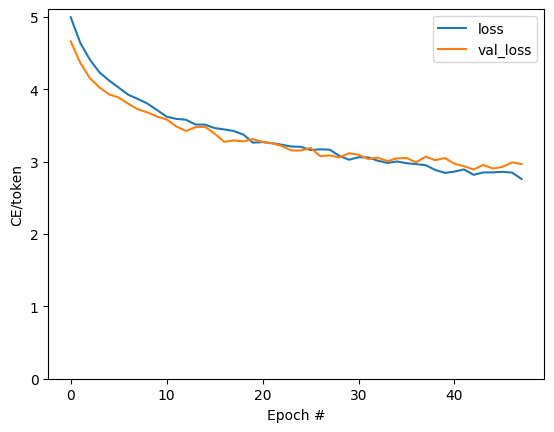

In [54]:
plt.plot(history.history['loss'], label='loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

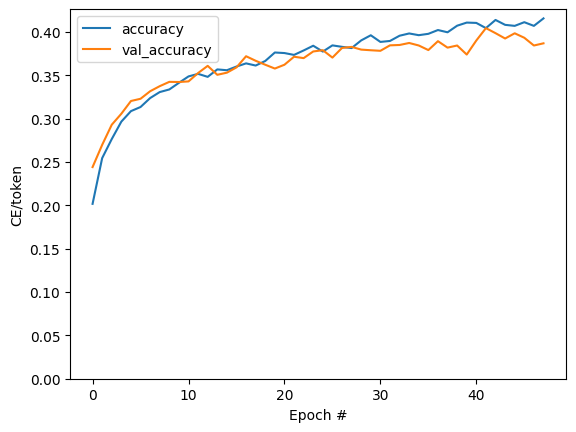

In [55]:
plt.plot(history.history['masked_acc'], label='accuracy')
plt.plot(history.history['val_masked_acc'], label='val_accuracy')
plt.ylim([0, max(plt.ylim())])
plt.xlabel('Epoch #')
plt.ylabel('CE/token')
plt.legend()

## 어텐션 플롯

이제 훈련된 모델을 사용하여 이미지에서 해당 `simple_gen` 메서드를 실행합니다.

In [56]:
result = model.simple_gen(image, temperature=0.0)
result

'a man in a yellow kayak is riding a wave'

출력을 토큰으로 다시 분할합니다.

In [57]:
str_tokens = result.split()
str_tokens.append('[END]')

각 `DecoderLayers`는 `CrossAttention` 레이어에 대한 어텐션 스코어를 캐싱합니다. 각 어텐션 맵의 형태는 `(batch=1, heads, sequence, image)`입니다.

In [58]:
attn_maps = [layer.last_attention_scores for layer in model.decoder_layers]
[map.shape for map in attn_maps]

[TensorShape([1, 2, 11, 49]), TensorShape([1, 2, 11, 49])]

따라서 `image` 축을 `height, width`로 다시 분할하는 한편 `batch` 축을 따라 맵을 스택한 다음 `(batch, heads)` 축에 대해 평균을 냅니다.


In [59]:
attention_maps = tf.concat(attn_maps, axis=0)
attention_maps = einops.reduce(
    attention_maps,
    'batch heads sequence (height width) -> sequence height width',
    height=7, width=7,
    reduction='mean')

이제 각 시퀀스 예측을 위한 단일 어텐션 맵이 하나 있습니다. 각 맵의 값은 합계가 `1`이어야 합니다.

In [60]:
einops.reduce(attention_maps, 'sequence height width -> sequence', reduction='sum')

<tf.Tensor: shape=(11,), dtype=float32, numpy=
array([1.       , 1.       , 1.       , 1.       , 0.9999999, 1.       ,
       1.       , 1.       , 1.       , 1.       , 1.       ],
      dtype=float32)>

따라서 다음은 출력에 대한 각 토큰을 생성하는 동안 모델이 어텐션에 주목하는 곳입니다.

In [61]:
def plot_attention_maps(image, str_tokens, attention_map):
    fig = plt.figure(figsize=(16, 9))

    len_result = len(str_tokens)
    
    titles = []
    for i in range(len_result):
      map = attention_map[i]
      grid_size = max(int(np.ceil(len_result/2)), 2)
      ax = fig.add_subplot(3, grid_size, i+1)
      titles.append(ax.set_title(str_tokens[i]))
      img = ax.imshow(image)
      ax.imshow(map, cmap='gray', alpha=0.6, extent=img.get_extent(),
                clim=[0.0, np.max(map)])

    plt.tight_layout()

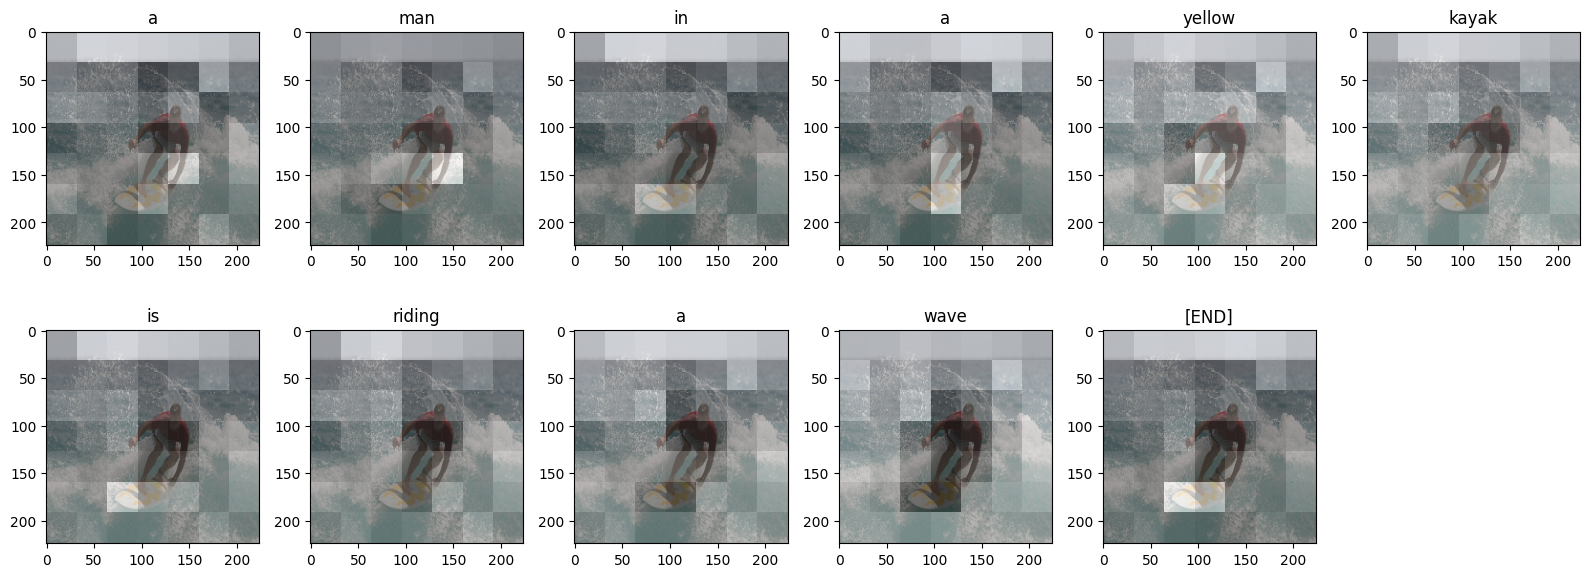

In [62]:
plot_attention_maps(image/255, str_tokens, attention_maps)

이제 더 유용한 함수로 함께 다음과 같이 통합합니다.

In [63]:
@Captioner.add_method
def run_and_show_attention(self, image, temperature=0.0):
  result_txt = self.simple_gen(image, temperature)
  str_tokens = result_txt.split()
  str_tokens.append('[END]')

  attention_maps = [layer.last_attention_scores for layer in self.decoder_layers]
  attention_maps = tf.concat(attention_maps, axis=0)
  attention_maps = einops.reduce(
      attention_maps,
      'batch heads sequence (height width) -> sequence height width',
      height=7, width=7,
      reduction='mean')
  
  plot_attention_maps(image/255, str_tokens, attention_maps)
  t = plt.suptitle(result_txt)
  t.set_y(1.05)


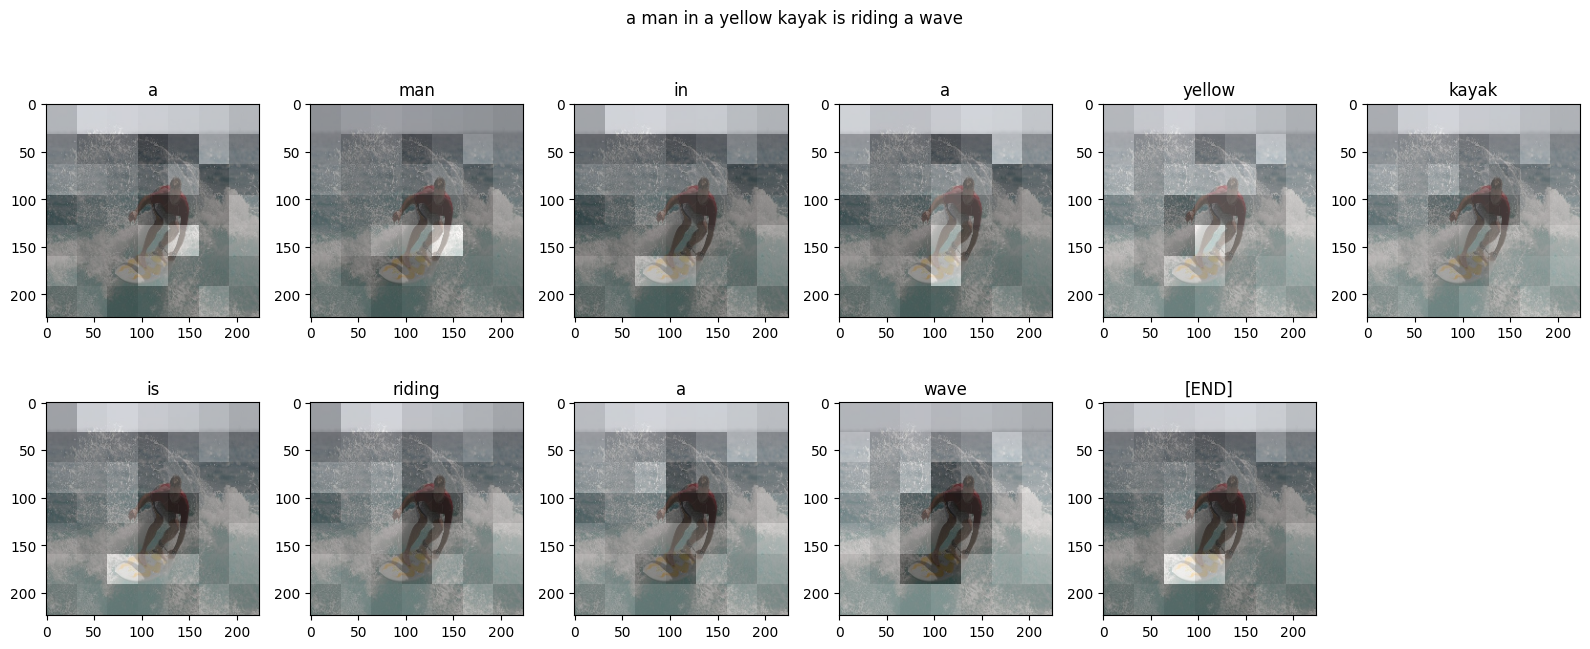

In [64]:
run_and_show_attention(model, image)

## 자체 이미지로 시도해보기

재미를 위해 방금 훈련한 모델로 자체 이미지를 캡션하는 데 사용할 수 있는 방법을 제공했습니다. 상대적으로 적은 양의 데이터로 훈련되었으므로 이미지가 훈련 데이터와 다를 수 있습니다(결과가 이상할 수 있습니다!).


 8192/67460 [==>...........................] - ETA: 0s

67460/67460 [==============================] - 0s 0us/step


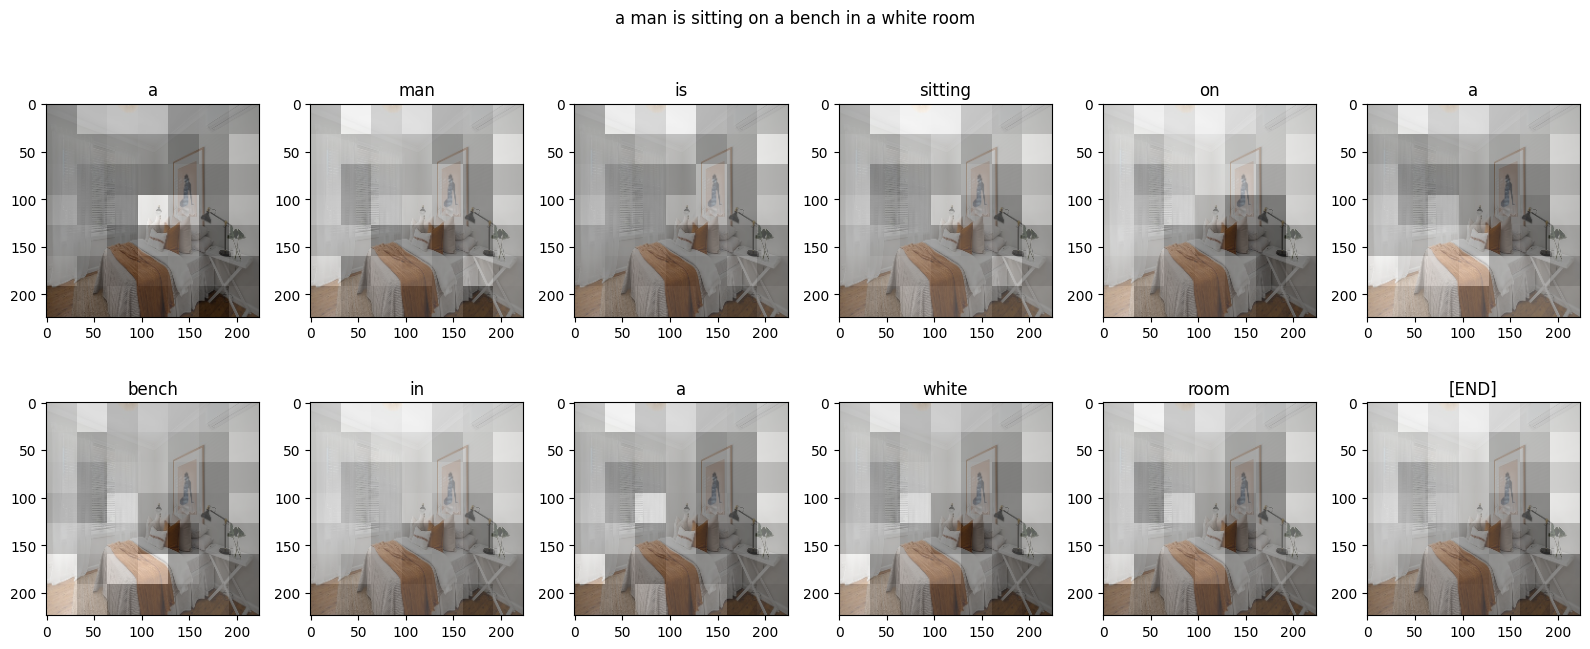

In [65]:
image_url = 'https://tensorflow.org/images/bedroom_hrnet_tutorial.jpg'
image_path = tf.keras.utils.get_file(origin=image_url)
image = load_image(image_path)

run_and_show_attention(model, image)